In [4]:
#Script to obtain data 
from helpers import *
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries to create the multiclass model
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
#Import tensorflow and disable the v2 behavior and eager mode
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

#Library to validate the model
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score

In [5]:
df = pd.read_csv("data/data_moods.csv")

In [6]:
col_features = df.columns[6:-3]
X= MinMaxScaler().fit_transform(df[col_features])
X2 = np.array(df[col_features])
Y = df['mood']

In [7]:
#Encodethe categories
encoder = LabelEncoder()
encoder.fit(Y)
encoded_y = encoder.transform(Y)


#Convert to  dummy (Not necessary in my case)
dummy_y = np_utils.to_categorical(encoded_y)

X_train,X_test,Y_train,Y_test = train_test_split(X,encoded_y,test_size=0.2,random_state=15)

target = pd.DataFrame({'mood':df['mood'].tolist(),'encode':encoded_y}).drop_duplicates().sort_values(['encode'],ascending=True)
target

,mood,encode
5,Calm,0
4,Energetic,1
0,Happy,2
1,Sad,3


In [8]:
def base_model():
    #Create the model
    model = Sequential()
    #Add 1 layer with 8 nodes,input of 4 dim with relu function
    model.add(Dense(8,input_dim=10,activation='relu'))
    #Add 1 layer with output 3 and softmax function
    model.add(Dense(4,activation='softmax'))
    #Compile the model using sigmoid loss function and adam optim
    model.compile(loss='categorical_crossentropy',optimizer='adam',
                 metrics=['accuracy'])
    return model

In [9]:
#Configure the model
estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)

/tmp/ipykernel_3601/2455418095.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=base_model,epochs=300,batch_size=200,verbose=0)


In [10]:
#Evaluate the model using KFold cross validation
kfold = KFold(n_splits=10,shuffle=True)
results = cross_val_score(estimator,X,encoded_y,cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100,results.std()*100))

2023-04-28 10:26:17.563340: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-04-28 10:26:17.625633: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense/kernel/m/Assign' id:206 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense/kernel/m, training/Adam/dense/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_u

Baseline: 78.73% (3.21%)


2023-04-28 10:26:29.568870: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_9/mul' id:2849 op device:{requested: '', assigned: ''} def:{{{node loss_9/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul/x, loss_9/dense_19_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [11]:
estimator.fit(X_train,Y_train)
y_preds = estimator.predict(X_test)

2023-04-28 10:26:29.882107: W tensorflow/c/c_api.cc:300] Operation '{name:'training_20/Adam/dense_20/kernel/m/Assign' id:3236 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_20/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_20/kernel/m, training_20/Adam/dense_20/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:30.857596: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_21/Softmax' id:3076 o

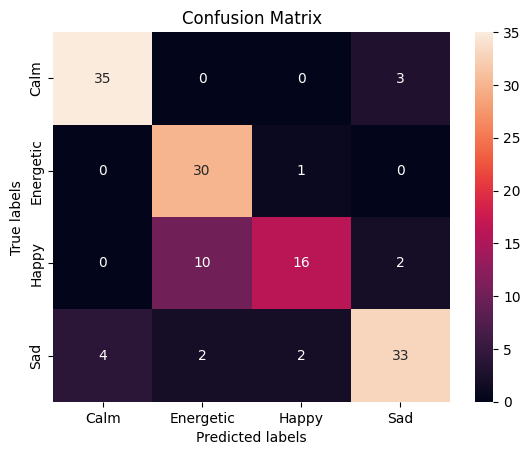

Accuracy Score 0.8260869565217391


In [12]:

cm = confusion_matrix(Y_test,y_preds)
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)

labels = target['mood']
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

print("Accuracy Score",accuracy_score(Y_test,y_preds))

In [13]:
def predict_mood(id_song):
    #Join the model and the scaler in a Pipeline
    pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
                                                                             batch_size=200,verbose=0))])
    #Fit the Pipeline
    pip.fit(X2,encoded_y)

    #Obtain the features of the song
    preds = get_songs_features(id_song)
    #Pre-process the features to input the Model
    preds_features = np.array(preds[0][6:-2]).reshape(-1,1).T

    #Predict the features of the song
    results = pip.predict(preds_features)

    mood = np.array(target['mood'][target['encode']==int(results)])
    name_song = preds[0][0]
    artist = preds[0][2]
    
    return mood[0]
    # return print("{0} by {1} is a {2} song".format(name_song,artist,mood[0].upper()))
    #print(f"{name_song} by {artist} is a {mood[0].upper()} song")
    

In [14]:

data = pd.read_csv('data/data.csv')
for index, row in data.iterrows():
    song_id = row["id"]
    print("This is the song ID: ",song_id)
    mood = predict_mood(song_id)
    data.loc[index, 'mood'] = mood
    data.to_csv('data/data.csv', index=False)
  



This is the song ID:  2J3ajGI1sVj9wnqThJHwPS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:26:31.525409: W tensorflow/c/c_api.cc:300] Operation '{name:'training_22/Adam/dense_22/kernel/m/Assign' id:3539 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/dense_22/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_22/Adam/dense_22/kernel/m, training_22/Adam/dense_22/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pa

This is the song ID:  4tRt91OQSbE9eFA3RwgqSd


2023-04-28 10:26:33.625103: W tensorflow/c/c_api.cc:300] Operation '{name:'training_24/Adam/dense_25/bias/v/Assign' id:3877 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/dense_25/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/dense_25/bias/v, training_24/Adam/dense_25/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:35.315607: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_25/Softmax' id:3682 op device

This is the song ID:  1p2TWJxUlHE5JR0sE6E1d7


2023-04-28 10:26:35.720715: W tensorflow/c/c_api.cc:300] Operation '{name:'count_13/Assign' id:3995 op device:{requested: '', assigned: ''} def:{{{node count_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_13, count_13/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:37.433508: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_27/Softmax' id:3985 op device:{requested: '', assigned: ''} def:{{{node dense_27/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_

This is the song ID:  2WIxwn8LZRI7knO1VbwdaE


2023-04-28 10:26:37.809275: W tensorflow/c/c_api.cc:300] Operation '{name:'training_28/Adam/dense_28/bias/v/Assign' id:4473 op device:{requested: '', assigned: ''} def:{{{node training_28/Adam/dense_28/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/Adam/dense_28/bias/v, training_28/Adam/dense_28/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:39.496852: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_29/Softmax' id:4288 op device

This is the song ID:  4pCvnGkf7jveRMKHZosxxB


2023-04-28 10:26:39.925150: W tensorflow/c/c_api.cc:300] Operation '{name:'training_30/Adam/beta_2/Assign' id:4736 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/beta_2, training_30/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:41.713853: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_31/Softmax' id:4591 op device:{requested: '', assigned: '

This is the song ID:  5LKXxwgll43fxe1lPF7sze


2023-04-28 10:26:42.153242: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_33/bias/Assign' id:4888 op device:{requested: '', assigned: ''} def:{{{node dense_33/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_33/bias, dense_33/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:43.953432: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_33/Softmax' id:4894 op device:{requested: '', assigned: ''} def:{{{node dense_33/Softmax}} = Softmax[T=DT

This is the song ID:  0zXXqCxifU2u8jfW2r4POb


2023-04-28 10:26:44.409667: W tensorflow/c/c_api.cc:300] Operation '{name:'training_34/Adam/dense_34/bias/v/Assign' id:5382 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_34/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_34/bias/v, training_34/Adam/dense_34/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:46.287498: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_35/Softmax' id:5197 op device

This is the song ID:  1NFpzFtGDWbtSCaXzxi1t7


2023-04-28 10:26:46.800575: W tensorflow/c/c_api.cc:300] Operation '{name:'training_36/Adam/iter/Assign' id:5635 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_36/Adam/iter, training_36/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:48.612959: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_37/Softmax' id:5500 op device:{requested: '', assigned: ''} def:{{{node d

This is the song ID:  3A4FRzgve9BjfKbvVXRIFO


2023-04-28 10:26:49.147517: W tensorflow/c/c_api.cc:300] Operation '{name:'training_38/Adam/dense_38/kernel/m/Assign' id:5963 op device:{requested: '', assigned: ''} def:{{{node training_38/Adam/dense_38/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_38/Adam/dense_38/kernel/m, training_38/Adam/dense_38/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:51.163374: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_39/Softmax' id:5803 o

This is the song ID:  4rL1OrbBCOD5hDgXWPCqW3


2023-04-28 10:26:51.659637: W tensorflow/c/c_api.cc:300] Operation '{name:'training_40/Adam/beta_1/Assign' id:6246 op device:{requested: '', assigned: ''} def:{{{node training_40/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_40/Adam/beta_1, training_40/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:53.467752: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_41/Softmax' id:6106 op device:{requested: '', assigned: '

This is the song ID:  51cd3bzVmLAjlnsSZn4ecW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:26:54.026864: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_43/bias/Assign' id:6403 op device:{requested: '', assigned: ''} def:{{{node dense_43/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_43/bias, dense_43/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be 

This is the song ID:  3sgqeL8dmOt1Pw8TkeyjsR


2023-04-28 10:26:56.616039: W tensorflow/c/c_api.cc:300] Operation '{name:'training_44/Adam/dense_45/bias/m/Assign' id:6887 op device:{requested: '', assigned: ''} def:{{{node training_44/Adam/dense_45/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_44/Adam/dense_45/bias/m, training_44/Adam/dense_45/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:26:58.491248: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_45/Softmax' id:6712 op device

This is the song ID:  3CuscN8itbT86pQFKQMIk7


2023-04-28 10:26:59.196595: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_46/kernel/Assign' id:6983 op device:{requested: '', assigned: ''} def:{{{node dense_46/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_46/kernel, dense_46/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:27:01.311881: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_47/Softmax' id:7015 op device:{requested: '', assigned: ''} def:{{{node dense_47/Softmax

This is the song ID:  1obisQNOcikRvTdStbW3pG


2023-04-28 10:27:01.835443: W tensorflow/c/c_api.cc:300] Operation '{name:'training_48/Adam/dense_49/bias/m/Assign' id:7493 op device:{requested: '', assigned: ''} def:{{{node training_48/Adam/dense_49/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_48/Adam/dense_49/bias/m, training_48/Adam/dense_49/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-04-28 10:27:03.800743: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_49/Softmax' id:7318 op device

This is the song ID:  6FWA2CTpr0wtgjK6r2qDgc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:04.392405: W tensorflow/c/c_api.cc:300] Operation '{name:'count_25/Assign' id:7631 op device:{requested: '', assigned: ''} def:{{{node count_25/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_25, count_25/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future 

This is the song ID:  5IdQEHgtmj9th3OkfQKhf8


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:07.166957: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_52/kernel/Assign' id:7892 op device:{requested: '', assigned: ''} def:{{{node dense_52/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_52/kernel, dense_52/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_

This is the song ID:  3LbO439QNr3IX7Ho39Fq8X


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:09.890146: W tensorflow/c/c_api.cc:300] Operation '{name:'training_54/Adam/beta_1/Assign' id:8367 op device:{requested: '', assigned: ''} def:{{{node training_54/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_54/Adam/beta_1, training_54/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2

This is the song ID:  0c2E2zcsp8EoWmfw8YQphH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:12.908088: W tensorflow/c/c_api.cc:300] Operation '{name:'training_56/Adam/beta_1/Assign' id:8670 op device:{requested: '', assigned: ''} def:{{{node training_56/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_56/Adam/beta_1, training_56/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2

This is the song ID:  7mlUgG3YkaE8AWRzsdEcNn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:15.805274: W tensorflow/c/c_api.cc:300] Operation '{name:'training_58/Adam/dense_58/bias/m/Assign' id:8998 op device:{requested: '', assigned: ''} def:{{{node training_58/Adam/dense_58/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_58/Adam/dense_58/bias/m, training_58/Adam/dense_58/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/k

This is the song ID:  3Vpl1HddJXv8LUBWHlQlKF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:19.021405: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_60/kernel/Assign' id:9104 op device:{requested: '', assigned: ''} def:{{{node dense_60/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_60/kernel, dense_60/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_

This is the song ID:  01dVdmSV7eaVgRzUAi6o13


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:22.426584: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_63/bias/Assign' id:9433 op device:{requested: '', assigned: ''} def:{{{node dense_63/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_63/bias, dense_63/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be 

This is the song ID:  6dtWKqqdveI3YvdYJQKWWn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:25.832714: W tensorflow/c/c_api.cc:300] Operation '{name:'training_64/Adam/learning_rate/Assign' id:9897 op device:{requested: '', assigned: ''} def:{{{node training_64/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_64/Adam/learning_rate, training_64/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/k

This is the song ID:  0WCbhE2evMrIwRM0DlMy9k


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:28.925054: W tensorflow/c/c_api.cc:300] Operation '{name:'training_66/Adam/decay/Assign' id:10195 op device:{requested: '', assigned: ''} def:{{{node training_66/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_66/Adam/decay, training_66/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359

This is the song ID:  1py4qzrEEkOvU8uTHYLuOW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:32.250013: W tensorflow/c/c_api.cc:300] Operation '{name:'training_68/Adam/beta_2/Assign' id:10493 op device:{requested: '', assigned: ''} def:{{{node training_68/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_68/Adam/beta_2, training_68/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  0tZIR4O5WX47JBC1TCcxxY


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:35.949333: W tensorflow/c/c_api.cc:300] Operation '{name:'training_70/Adam/decay/Assign' id:10801 op device:{requested: '', assigned: ''} def:{{{node training_70/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_70/Adam/decay, training_70/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359

This is the song ID:  5PnBpKOVvQxeFvXVNYSoxs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:39.254069: W tensorflow/c/c_api.cc:300] Operation '{name:'training_72/Adam/dense_73/bias/m/Assign' id:11129 op device:{requested: '', assigned: ''} def:{{{node training_72/Adam/dense_73/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_72/Adam/dense_73/bias/m, training_72/Adam/dense_73/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/

This is the song ID:  1ogRu1dOUgHvel8To8oQbe


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:42.531723: W tensorflow/c/c_api.cc:300] Operation '{name:'training_74/Adam/dense_75/bias/v/Assign' id:11452 op device:{requested: '', assigned: ''} def:{{{node training_74/Adam/dense_75/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_74/Adam/dense_75/bias/v, training_74/Adam/dense_75/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/

This is the song ID:  5f6esnDQcBiFAm8iMfkw12


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:46.089631: W tensorflow/c/c_api.cc:300] Operation '{name:'training_76/Adam/dense_77/kernel/v/Assign' id:11750 op device:{requested: '', assigned: ''} def:{{{node training_76/Adam/dense_77/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_76/Adam/dense_77/kernel/v, training_76/Adam/dense_77/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3Iju4sprTb8as0be1A41q6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:49.560494: W tensorflow/c/c_api.cc:300] Operation '{name:'training_78/Adam/beta_1/Assign' id:12003 op device:{requested: '', assigned: ''} def:{{{node training_78/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_78/Adam/beta_1, training_78/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  6wfzokDylbrJzrJcpnBkcy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:53.157121: W tensorflow/c/c_api.cc:300] Operation '{name:'total_40/Assign' id:12171 op device:{requested: '', assigned: ''} def:{{{node total_40/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_40, total_40/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future

This is the song ID:  1bVR1UVkeaJRK5LNpIe7Gp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:27:56.780840: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_82/bias/Assign' id:12442 op device:{requested: '', assigned: ''} def:{{{node dense_82/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_82/bias, dense_82/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be

This is the song ID:  2os38o5E7NoO4B2cx42h5V


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:00.386227: W tensorflow/c/c_api.cc:300] Operation '{name:'training_84/Adam/dense_84/bias/m/Assign' id:12937 op device:{requested: '', assigned: ''} def:{{{node training_84/Adam/dense_84/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_84/Adam/dense_84/bias/m, training_84/Adam/dense_84/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/

This is the song ID:  6t2ubAB4iSYOuIpRAOGd4t


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:04.117688: W tensorflow/c/c_api.cc:300] Operation '{name:'training_86/Adam/dense_86/kernel/m/Assign' id:13235 op device:{requested: '', assigned: ''} def:{{{node training_86/Adam/dense_86/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_86/Adam/dense_86/kernel/m, training_86/Adam/dense_86/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  1vG6jMgSoqT3zG9tuDrL2E


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:07.872463: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_88/bias/Assign' id:13351 op device:{requested: '', assigned: ''} def:{{{node dense_88/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_88/bias, dense_88/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be

This is the song ID:  1A8s182NfOT6dOXjPsWfTn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:11.708312: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_90/bias/Assign' id:13654 op device:{requested: '', assigned: ''} def:{{{node dense_90/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_90/bias, dense_90/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be

This is the song ID:  1yIMrzF45Ven2FzPFAr0Gg


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:15.573708: W tensorflow/c/c_api.cc:300] Operation '{name:'training_92/Adam/dense_93/bias/v/Assign' id:14179 op device:{requested: '', assigned: ''} def:{{{node training_92/Adam/dense_93/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_92/Adam/dense_93/bias/v, training_92/Adam/dense_93/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/

This is the song ID:  4AkP8JV90cs05Q8vlVunMe


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:19.522180: W tensorflow/c/c_api.cc:300] Operation '{name:'training_94/Adam/dense_94/bias/v/Assign' id:14472 op device:{requested: '', assigned: ''} def:{{{node training_94/Adam/dense_94/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_94/Adam/dense_94/bias/v, training_94/Adam/dense_94/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/

This is the song ID:  2qLcJOLrh6Djda4uLbldSA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:23.565813: W tensorflow/c/c_api.cc:300] Operation '{name:'training_96/Adam/dense_96/bias/v/Assign' id:14775 op device:{requested: '', assigned: ''} def:{{{node training_96/Adam/dense_96/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_96/Adam/dense_96/bias/v, training_96/Adam/dense_96/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/

This is the song ID:  2DdluBZleLq30PlfUAqSD5


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:27.653274: W tensorflow/c/c_api.cc:300] Operation '{name:'training_98/Adam/dense_99/bias/m/Assign' id:15068 op device:{requested: '', assigned: ''} def:{{{node training_98/Adam/dense_99/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_98/Adam/dense_99/bias/m, training_98/Adam/dense_99/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/

This is the song ID:  453QwgDIG95NmmLqSxnPsR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:31.979309: W tensorflow/c/c_api.cc:300] Operation '{name:'training_100/Adam/dense_100/bias/v/Assign' id:15381 op device:{requested: '', assigned: ''} def:{{{node training_100/Adam/dense_100/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_100/Adam/dense_100/bias/v, training_100/Adam/dense_100/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6MmCP3F50aAlcOhjGJk4r0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:36.329121: W tensorflow/c/c_api.cc:300] Operation '{name:'training_102/Adam/dense_103/bias/v/Assign' id:15694 op device:{requested: '', assigned: ''} def:{{{node training_102/Adam/dense_103/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_102/Adam/dense_103/bias/v, training_102/Adam/dense_103/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6ZPCHQl5bzCBOdMupogB00


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:40.543525: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_105/kernel/Assign' id:15791 op device:{requested: '', assigned: ''} def:{{{node dense_105/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_105/kernel, dense_105/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  5KSNxyuyp5K1kDT6LvX8oZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:44.963523: W tensorflow/c/c_api.cc:300] Operation '{name:'training_106/Adam/dense_107/bias/m/Assign' id:16280 op device:{requested: '', assigned: ''} def:{{{node training_106/Adam/dense_107/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_106/Adam/dense_107/bias/m, training_106/Adam/dense_107/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  7rLDARtJALM7QdiJDMXW7m


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:49.434249: W tensorflow/c/c_api.cc:300] Operation '{name:'training_108/Adam/learning_rate/Assign' id:16563 op device:{requested: '', assigned: ''} def:{{{node training_108/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_108/Adam/learning_rate, training_108/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  1SPBJ5ol7xYyzxt1Gs0MTD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:54.242489: W tensorflow/c/c_api.cc:300] Operation '{name:'training_110/Adam/dense_111/kernel/v/Assign' id:16901 op device:{requested: '', assigned: ''} def:{{{node training_110/Adam/dense_111/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_110/Adam/dense_111/kernel/v, training_110/Adam/dense_111/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  56ZrTFkANjeAMiS14njg4E


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:28:58.814584: W tensorflow/c/c_api.cc:300] Operation '{name:'training_112/Adam/dense_112/bias/m/Assign' id:17179 op device:{requested: '', assigned: ''} def:{{{node training_112/Adam/dense_112/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_112/Adam/dense_112/bias/m, training_112/Adam/dense_112/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0Zyt3eB2Ddhert42wIa181


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:03.488143: W tensorflow/c/c_api.cc:300] Operation '{name:'training_114/Adam/dense_115/bias/v/Assign' id:17512 op device:{requested: '', assigned: ''} def:{{{node training_114/Adam/dense_115/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_114/Adam/dense_115/bias/v, training_114/Adam/dense_115/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3vZM2544ETmOCCHuBPZRzm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:07.897363: W tensorflow/c/c_api.cc:300] Operation '{name:'training_116/Adam/dense_116/kernel/m/Assign' id:17780 op device:{requested: '', assigned: ''} def:{{{node training_116/Adam/dense_116/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_116/Adam/dense_116/kernel/m, training_116/Adam/dense_116/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  3S4tE82kad4ybdfTjpWya3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:12.671684: W tensorflow/c/c_api.cc:300] Operation '{name:'training_118/Adam/dense_118/bias/m/Assign' id:18088 op device:{requested: '', assigned: ''} def:{{{node training_118/Adam/dense_118/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_118/Adam/dense_118/bias/m, training_118/Adam/dense_118/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  5mEqD00bdFcsiVd0MfvEeF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:17.401209: W tensorflow/c/c_api.cc:300] Operation '{name:'training_120/Adam/dense_121/kernel/m/Assign' id:18396 op device:{requested: '', assigned: ''} def:{{{node training_120/Adam/dense_121/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_120/Adam/dense_121/kernel/m, training_120/Adam/dense_121/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  2XrM7sxDMFn2LaKB7ITlJs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:22.980749: W tensorflow/c/c_api.cc:300] Operation '{name:'training_122/Adam/dense_122/bias/v/Assign' id:18714 op device:{requested: '', assigned: ''} def:{{{node training_122/Adam/dense_122/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_122/Adam/dense_122/bias/v, training_122/Adam/dense_122/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  5HiSc2ZCGn8L3cH3qSwzBT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:27.853917: W tensorflow/c/c_api.cc:300] Operation '{name:'training_124/Adam/dense_124/kernel/m/Assign' id:18992 op device:{requested: '', assigned: ''} def:{{{node training_124/Adam/dense_124/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_124/Adam/dense_124/kernel/m, training_124/Adam/dense_124/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  3toYHht60pj16nNK0e2HZy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:32.693338: W tensorflow/c/c_api.cc:300] Operation '{name:'training_126/Adam/dense_127/kernel/m/Assign' id:19305 op device:{requested: '', assigned: ''} def:{{{node training_126/Adam/dense_127/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_126/Adam/dense_127/kernel/m, training_126/Adam/dense_127/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  1FlYPPzFJUNh3KRE36pYbe


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:37.722293: W tensorflow/c/c_api.cc:300] Operation '{name:'training_128/Adam/dense_129/bias/v/Assign' id:19633 op device:{requested: '', assigned: ''} def:{{{node training_128/Adam/dense_129/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_128/Adam/dense_129/bias/v, training_128/Adam/dense_129/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  4d9dLobDQ4BcfNbOnSPHQC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:42.831821: W tensorflow/c/c_api.cc:300] Operation '{name:'training_130/Adam/dense_131/kernel/v/Assign' id:19931 op device:{requested: '', assigned: ''} def:{{{node training_130/Adam/dense_131/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_130/Adam/dense_131/kernel/v, training_130/Adam/dense_131/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  6AiZAvK2mGrdQQhcJde1Nh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:47.938267: W tensorflow/c/c_api.cc:300] Operation '{name:'training_132/Adam/decay/Assign' id:20194 op device:{requested: '', assigned: ''} def:{{{node training_132/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_132/Adam/decay, training_132/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  34b7J43bozWsfeo4sqEViN


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:53.186877: W tensorflow/c/c_api.cc:300] Operation '{name:'count_67/Assign' id:20357 op device:{requested: '', assigned: ''} def:{{{node count_67/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_67, count_67/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future

This is the song ID:  35zkqY6kIGshmm8HhE3eSi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:29:58.467496: W tensorflow/c/c_api.cc:300] Operation '{name:'training_136/Adam/beta_2/Assign' id:20795 op device:{requested: '', assigned: ''} def:{{{node training_136/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_136/Adam/beta_2, training_136/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  38wDkBNOGJJ0YtqWOaLEFh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:03.661940: W tensorflow/c/c_api.cc:300] Operation '{name:'total_69/Assign' id:20958 op device:{requested: '', assigned: ''} def:{{{node total_69/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_69, total_69/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future

This is the song ID:  3v10vlZlZPApvDz3kE4aNe


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:08.951344: W tensorflow/c/c_api.cc:300] Operation '{name:'training_140/Adam/beta_2/Assign' id:21401 op device:{requested: '', assigned: ''} def:{{{node training_140/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_140/Adam/beta_2, training_140/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  5RH7e8dotrJNLdfbDgXkxG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:14.232371: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_143/bias/Assign' id:21553 op device:{requested: '', assigned: ''} def:{{{node dense_143/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_143/bias, dense_143/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  3IL8NIwz2vZpy7fettGnZk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:19.579773: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_145/kernel/Assign' id:21851 op device:{requested: '', assigned: ''} def:{{{node dense_145/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_145/kernel, dense_145/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  3f2k8op0nWDoZM4pXim6wG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:24.960290: W tensorflow/c/c_api.cc:300] Operation '{name:'training_146/Adam/dense_147/bias/m/Assign' id:22340 op device:{requested: '', assigned: ''} def:{{{node training_146/Adam/dense_147/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_146/Adam/dense_147/bias/m, training_146/Adam/dense_147/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  1j0Rb762xxT0eccglHKsRv


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:30.433967: W tensorflow/c/c_api.cc:300] Operation '{name:'training_148/Adam/dense_148/kernel/m/Assign' id:22628 op device:{requested: '', assigned: ''} def:{{{node training_148/Adam/dense_148/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_148/Adam/dense_148/kernel/m, training_148/Adam/dense_148/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  0t0WIrjRcvgBAwLlby2gsZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:35.941010: W tensorflow/c/c_api.cc:300] Operation '{name:'training_150/Adam/beta_2/Assign' id:22916 op device:{requested: '', assigned: ''} def:{{{node training_150/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_150/Adam/beta_2, training_150/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  6aommJFM8i3iT4inKuDSXh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:41.566905: W tensorflow/c/c_api.cc:300] Operation '{name:'training_152/Adam/dense_152/kernel/m/Assign' id:23234 op device:{requested: '', assigned: ''} def:{{{node training_152/Adam/dense_152/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_152/Adam/dense_152/kernel/m, training_152/Adam/dense_152/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  03PTvKwCBFNGxIqvzVWHwg


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:47.158741: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_154/bias/Assign' id:23350 op device:{requested: '', assigned: ''} def:{{{node dense_154/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_154/bias, dense_154/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  7pamxApUs3CE8t7tKmUJ6Z


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:52.921333: W tensorflow/c/c_api.cc:300] Operation '{name:'training_156/Adam/dense_156/bias/m/Assign' id:23845 op device:{requested: '', assigned: ''} def:{{{node training_156/Adam/dense_156/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_156/Adam/dense_156/bias/m, training_156/Adam/dense_156/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  44Ssjb20kLO6FshLp0gNZE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:30:58.947683: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_158/bias/Assign' id:23956 op device:{requested: '', assigned: ''} def:{{{node dense_158/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_158/bias, dense_158/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  1SbsbLsUMnAKWHx1zAV6ER


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:05.247217: W tensorflow/c/c_api.cc:300] Operation '{name:'training_160/Adam/iter/Assign' id:24421 op device:{requested: '', assigned: ''} def:{{{node training_160/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_160/Adam/iter, training_160/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  3TTVgqpcMhzeymFY0OJ4Ia


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:11.291143: W tensorflow/c/c_api.cc:300] Operation '{name:'training_162/Adam/decay/Assign' id:24739 op device:{requested: '', assigned: ''} def:{{{node training_162/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_162/Adam/decay, training_162/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  6E5PU4i61dEahmW37mTtk9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:17.446191: W tensorflow/c/c_api.cc:300] Operation '{name:'training_164/Adam/dense_164/bias/m/Assign' id:25057 op device:{requested: '', assigned: ''} def:{{{node training_164/Adam/dense_164/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_164/Adam/dense_164/bias/m, training_164/Adam/dense_164/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3U1ebcYLCZGhXUefbLM80m


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:23.950205: W tensorflow/c/c_api.cc:300] Operation '{name:'training_166/Adam/dense_167/kernel/v/Assign' id:25385 op device:{requested: '', assigned: ''} def:{{{node training_166/Adam/dense_167/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_166/Adam/dense_167/kernel/v, training_166/Adam/dense_167/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  6Kfg9m0rNTOIvZPMkVar88


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:30.251279: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_169/kernel/Assign' id:25487 op device:{requested: '', assigned: ''} def:{{{node dense_169/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_169/kernel, dense_169/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  6xL9MJ2yt39HPPZPyGkRy8


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:36.544116: W tensorflow/c/c_api.cc:300] Operation '{name:'training_170/Adam/dense_171/bias/v/Assign' id:25996 op device:{requested: '', assigned: ''} def:{{{node training_170/Adam/dense_171/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_170/Adam/dense_171/bias/v, training_170/Adam/dense_171/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6ImNTJH4BqGfcx45IueM38


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:42.975020: W tensorflow/c/c_api.cc:300] Operation '{name:'training_172/Adam/dense_172/kernel/v/Assign' id:26284 op device:{requested: '', assigned: ''} def:{{{node training_172/Adam/dense_172/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_172/Adam/dense_172/kernel/v, training_172/Adam/dense_172/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  3Y6L3oiUydJIGsmk5zHlDO


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:49.339492: W tensorflow/c/c_api.cc:300] Operation '{name:'count_87/Assign' id:26417 op device:{requested: '', assigned: ''} def:{{{node count_87/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_87, count_87/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future

This is the song ID:  5Nq6lLSxphlsA6nQB0KtES


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:31:55.750571: W tensorflow/c/c_api.cc:300] Operation '{name:'count_88/Assign' id:26720 op device:{requested: '', assigned: ''} def:{{{node count_88/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_88, count_88/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future

This is the song ID:  0ghq9ciZLPrFmlRCIUXgj0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:02.252022: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_179/kernel/Assign' id:27002 op device:{requested: '', assigned: ''} def:{{{node dense_179/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_179/kernel, dense_179/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  1QSMyV4BAvNRwIpRzS8zWn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:08.893600: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_181/bias/Assign' id:27310 op device:{requested: '', assigned: ''} def:{{{node dense_181/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_181/bias, dense_181/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  5n4ZzdO7KtpxsDpoDTa3D6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:15.513666: W tensorflow/c/c_api.cc:300] Operation '{name:'training_182/Adam/dense_182/kernel/m/Assign' id:27779 op device:{requested: '', assigned: ''} def:{{{node training_182/Adam/dense_182/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_182/Adam/dense_182/kernel/m, training_182/Adam/dense_182/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  2pJZ1v8HezrAoZ0Fhzby92


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:22.196188: W tensorflow/c/c_api.cc:300] Operation '{name:'training_184/Adam/dense_184/kernel/v/Assign' id:28102 op device:{requested: '', assigned: ''} def:{{{node training_184/Adam/dense_184/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_184/Adam/dense_184/kernel/v, training_184/Adam/dense_184/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  2FIm6YsSGL5acOqSuJDh5s


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:28.966447: W tensorflow/c/c_api.cc:300] Operation '{name:'training_186/Adam/beta_1/Assign' id:28365 op device:{requested: '', assigned: ''} def:{{{node training_186/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_186/Adam/beta_1, training_186/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  172zA5Yn0YzayQWvEJuGAm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:35.743046: W tensorflow/c/c_api.cc:300] Operation '{name:'training_188/Adam/dense_188/bias/v/Assign' id:28713 op device:{requested: '', assigned: ''} def:{{{node training_188/Adam/dense_188/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_188/Adam/dense_188/bias/v, training_188/Adam/dense_188/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6NWl2m8asvH83xjuXVNsuG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:42.622511: W tensorflow/c/c_api.cc:300] Operation '{name:'training_190/Adam/dense_191/kernel/v/Assign' id:29021 op device:{requested: '', assigned: ''} def:{{{node training_190/Adam/dense_191/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_190/Adam/dense_191/kernel/v, training_190/Adam/dense_191/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  2UDoZZSrs3NxlmvFZbffr4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:49.620825: W tensorflow/c/c_api.cc:300] Operation '{name:'training_192/Adam/beta_2/Assign' id:29279 op device:{requested: '', assigned: ''} def:{{{node training_192/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_192/Adam/beta_2, training_192/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  0zL4obhcqLn9Ke2G3iNMd9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:32:56.673928: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_195/bias/Assign' id:29431 op device:{requested: '', assigned: ''} def:{{{node dense_195/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_195/bias, dense_195/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  0gg5h5BgdjVlXTti79TUao


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:33:03.755997: W tensorflow/c/c_api.cc:300] Operation '{name:'training_196/Adam/dense_197/kernel/m/Assign' id:29910 op device:{requested: '', assigned: ''} def:{{{node training_196/Adam/dense_197/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_196/Adam/dense_197/kernel/m, training_196/Adam/dense_197/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  6p8DGrcAUBuLUgDIKcUn0P


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:33:10.903191: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_199/kernel/Assign' id:30032 op device:{requested: '', assigned: ''} def:{{{node dense_199/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_199/kernel, dense_199/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  5z1wOyEyoRu0HTkXYvuqiH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:33:18.091235: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_200/kernel/Assign' id:30314 op device:{requested: '', assigned: ''} def:{{{node dense_200/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_200/kernel, dense_200/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  1SyVxxXzBEXtyP2duLCgT9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:33:25.618092: W tensorflow/c/c_api.cc:300] Operation '{name:'training_202/Adam/dense_203/bias/m/Assign' id:30824 op device:{requested: '', assigned: ''} def:{{{node training_202/Adam/dense_203/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_202/Adam/dense_203/bias/m, training_202/Adam/dense_203/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  4BGfM7Faj0dyEnSuaOw67j


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:33:33.005737: W tensorflow/c/c_api.cc:300] Operation '{name:'training_204/Adam/dense_204/kernel/m/Assign' id:31112 op device:{requested: '', assigned: ''} def:{{{node training_204/Adam/dense_204/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_204/Adam/dense_204/kernel/m, training_204/Adam/dense_204/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  6Z85UCEueQcgSyChlrEu5G


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:33:40.380533: W tensorflow/c/c_api.cc:300] Operation '{name:'training_206/Adam/dense_207/bias/v/Assign' id:31450 op device:{requested: '', assigned: ''} def:{{{node training_206/Adam/dense_207/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_206/Adam/dense_207/bias/v, training_206/Adam/dense_207/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  5p3NP9mQblDsVJLdfNZJ3I


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:33:47.779773: W tensorflow/c/c_api.cc:300] Operation '{name:'training_208/Adam/dense_209/bias/v/Assign' id:31753 op device:{requested: '', assigned: ''} def:{{{node training_208/Adam/dense_209/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_208/Adam/dense_209/bias/v, training_208/Adam/dense_209/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3zoFkjJCH2ntsad8kfRhyi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:33:55.309980: W tensorflow/c/c_api.cc:300] Operation '{name:'training_210/Adam/dense_210/bias/m/Assign' id:32026 op device:{requested: '', assigned: ''} def:{{{node training_210/Adam/dense_210/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_210/Adam/dense_210/bias/m, training_210/Adam/dense_210/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0vMI3AJPQMjytAu8XMWr65


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:34:02.894235: W tensorflow/c/c_api.cc:300] Operation '{name:'training_212/Adam/dense_213/kernel/v/Assign' id:32354 op device:{requested: '', assigned: ''} def:{{{node training_212/Adam/dense_213/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_212/Adam/dense_213/kernel/v, training_212/Adam/dense_213/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  3ojTJaonfkL96iIWa47SU3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:34:10.506611: W tensorflow/c/c_api.cc:300] Operation '{name:'training_214/Adam/dense_214/bias/v/Assign' id:32652 op device:{requested: '', assigned: ''} def:{{{node training_214/Adam/dense_214/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_214/Adam/dense_214/bias/v, training_214/Adam/dense_214/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  5aVTpbRU7DM9GfCNydb9MR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:34:18.318533: W tensorflow/c/c_api.cc:300] Operation '{name:'total_108/Assign' id:32775 op device:{requested: '', assigned: ''} def:{{{node total_108/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_108, total_108/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  3NuN59jpH3B5cNa2M4r7XG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:34:26.163695: W tensorflow/c/c_api.cc:300] Operation '{name:'training_218/Adam/beta_2/Assign' id:33218 op device:{requested: '', assigned: ''} def:{{{node training_218/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_218/Adam/beta_2, training_218/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  2btKtacOXuMtC9WjcNRvAA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:34:34.096063: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_220/bias/Assign' id:33349 op device:{requested: '', assigned: ''} def:{{{node dense_220/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_220/bias, dense_220/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  5u9cuDcYdOpSRB7fAYXXdp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:34:42.140834: W tensorflow/c/c_api.cc:300] Operation '{name:'count_111/Assign' id:33689 op device:{requested: '', assigned: ''} def:{{{node count_111/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_111, count_111/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  6XiSceaDaO2vaYF2B2A70t


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:34:50.069911: W tensorflow/c/c_api.cc:300] Operation '{name:'training_224/Adam/beta_2/Assign' id:34127 op device:{requested: '', assigned: ''} def:{{{node training_224/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_224/Adam/beta_2, training_224/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  5WPXnJulBVflChZ8qIe91d


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:34:58.238993: W tensorflow/c/c_api.cc:300] Operation '{name:'total_113/Assign' id:34290 op device:{requested: '', assigned: ''} def:{{{node total_113/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_113, total_113/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  27vTihlWXiz9f9lJM3XGVU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:35:06.336321: W tensorflow/c/c_api.cc:300] Operation '{name:'training_228/Adam/beta_1/Assign' id:34728 op device:{requested: '', assigned: ''} def:{{{node training_228/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_228/Adam/beta_1, training_228/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  0q7oMII7kWTj1ZSX6GT6LU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:35:14.472435: W tensorflow/c/c_api.cc:300] Operation '{name:'training_230/Adam/decay/Assign' id:35041 op device:{requested: '', assigned: ''} def:{{{node training_230/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_230/Adam/decay, training_230/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  6TFUZ8Bt1brEwomY90SKXi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:35:22.807890: W tensorflow/c/c_api.cc:300] Operation '{name:'training_232/Adam/dense_232/bias/v/Assign' id:35379 op device:{requested: '', assigned: ''} def:{{{node training_232/Adam/dense_232/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_232/Adam/dense_232/bias/v, training_232/Adam/dense_232/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  4j6NKbX08MJRruVUttANU8


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:35:31.073337: W tensorflow/c/c_api.cc:300] Operation '{name:'training_234/Adam/dense_235/bias/v/Assign' id:35692 op device:{requested: '', assigned: ''} def:{{{node training_234/Adam/dense_235/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_234/Adam/dense_235/bias/v, training_234/Adam/dense_235/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3iGNoYKIabGohB9A0C7dKU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:35:39.476460: W tensorflow/c/c_api.cc:300] Operation '{name:'training_236/Adam/learning_rate/Assign' id:35955 op device:{requested: '', assigned: ''} def:{{{node training_236/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_236/Adam/learning_rate, training_236/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  2bPYtv3okqX5zpSxtwLBuu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:35:47.847335: W tensorflow/c/c_api.cc:300] Operation '{name:'training_238/Adam/dense_238/kernel/v/Assign' id:36283 op device:{requested: '', assigned: ''} def:{{{node training_238/Adam/dense_238/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_238/Adam/dense_238/kernel/v, training_238/Adam/dense_238/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  4HQYvC3uJxW3KDGxMln19H


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:35:56.240129: W tensorflow/c/c_api.cc:300] Operation '{name:'training_240/Adam/dense_241/kernel/v/Assign' id:36596 op device:{requested: '', assigned: ''} def:{{{node training_240/Adam/dense_241/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_240/Adam/dense_241/kernel/v, training_240/Adam/dense_241/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  4yWCiMOk150jbE3NPuhXHu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:36:04.812847: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_242/bias/Assign' id:36682 op device:{requested: '', assigned: ''} def:{{{node dense_242/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_242/bias, dense_242/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  5g97GAdru7XfeJyJhViIll


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:36:13.380463: W tensorflow/c/c_api.cc:300] Operation '{name:'training_244/Adam/dense_244/kernel/v/Assign' id:37192 op device:{requested: '', assigned: ''} def:{{{node training_244/Adam/dense_244/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_244/Adam/dense_244/kernel/v, training_244/Adam/dense_244/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  0QfmQhr5npxuWQ4zzUDUhB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:36:22.073992: W tensorflow/c/c_api.cc:300] Operation '{name:'training_246/Adam/learning_rate/Assign' id:37470 op device:{requested: '', assigned: ''} def:{{{node training_246/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_246/Adam/learning_rate, training_246/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  1BfR5GMOgW0peHkPxrwf11


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:36:30.912078: W tensorflow/c/c_api.cc:300] Operation '{name:'training_248/Adam/dense_248/bias/v/Assign' id:37803 op device:{requested: '', assigned: ''} def:{{{node training_248/Adam/dense_248/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_248/Adam/dense_248/bias/v, training_248/Adam/dense_248/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0u4rkpmNtgcFxYHepnVF4v


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:36:39.614868: W tensorflow/c/c_api.cc:300] Operation '{name:'training_250/Adam/decay/Assign' id:38071 op device:{requested: '', assigned: ''} def:{{{node training_250/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_250/Adam/decay, training_250/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  5ZJ9wxMqAhIOekYLmukc2L


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:36:48.296570: W tensorflow/c/c_api.cc:300] Operation '{name:'count_126/Assign' id:38234 op device:{requested: '', assigned: ''} def:{{{node count_126/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_126, count_126/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  2eWqBNH136U8Et0UTxBacB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:36:57.029921: W tensorflow/c/c_api.cc:300] Operation '{name:'total_127/Assign' id:38532 op device:{requested: '', assigned: ''} def:{{{node total_127/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_127, total_127/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  49K3jbwZmZKaDGTfjpIVg0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:37:05.858225: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_256/bias/Assign' id:38803 op device:{requested: '', assigned: ''} def:{{{node dense_256/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_256/bias, dense_256/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  0xl1w2q4VLojeXp4JfazPL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:37:15.022883: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_258/bias/Assign' id:39106 op device:{requested: '', assigned: ''} def:{{{node dense_258/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_258/bias, dense_258/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  6xTU6B6nFwKKTSZ9ySXS80


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:37:24.230656: W tensorflow/c/c_api.cc:300] Operation '{name:'training_260/Adam/dense_260/kernel/m/Assign' id:39596 op device:{requested: '', assigned: ''} def:{{{node training_260/Adam/dense_260/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_260/Adam/dense_260/kernel/m, training_260/Adam/dense_260/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  2Tbym0L4Xlox9nol0YzPct


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:37:33.314117: W tensorflow/c/c_api.cc:300] Operation '{name:'training_262/Adam/dense_262/kernel/v/Assign' id:39919 op device:{requested: '', assigned: ''} def:{{{node training_262/Adam/dense_262/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_262/Adam/dense_262/kernel/v, training_262/Adam/dense_262/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  75NhhYjHO43mvZgYtnXgti


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:37:42.460710: W tensorflow/c/c_api.cc:300] Operation '{name:'training_264/Adam/dense_264/bias/v/Assign' id:40227 op device:{requested: '', assigned: ''} def:{{{node training_264/Adam/dense_264/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_264/Adam/dense_264/bias/v, training_264/Adam/dense_264/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  42tFTth2jcF7iSo0RBjfJF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:37:51.688410: W tensorflow/c/c_api.cc:300] Operation '{name:'training_266/Adam/dense_266/bias/v/Assign' id:40530 op device:{requested: '', assigned: ''} def:{{{node training_266/Adam/dense_266/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_266/Adam/dense_266/bias/v, training_266/Adam/dense_266/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6q22ySlGYH8PEcciOeN1Ki


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:38:01.055857: W tensorflow/c/c_api.cc:300] Operation '{name:'training_268/Adam/beta_2/Assign' id:40793 op device:{requested: '', assigned: ''} def:{{{node training_268/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_268/Adam/beta_2, training_268/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  6f8b6mxNNDJdE5tC4MCTxt


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:38:10.406614: W tensorflow/c/c_api.cc:300] Operation '{name:'training_270/Adam/dense_271/kernel/v/Assign' id:41141 op device:{requested: '', assigned: ''} def:{{{node training_270/Adam/dense_271/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_270/Adam/dense_271/kernel/v, training_270/Adam/dense_271/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  4MVk79dmYqi7HQs0bMgboy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:38:19.762326: W tensorflow/c/c_api.cc:300] Operation '{name:'training_272/Adam/dense_272/bias/v/Assign' id:41439 op device:{requested: '', assigned: ''} def:{{{node training_272/Adam/dense_272/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_272/Adam/dense_272/bias/v, training_272/Adam/dense_272/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  77lGafvlU68CeHgB2pkHC9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:38:29.230414: W tensorflow/c/c_api.cc:300] Operation '{name:'training_274/Adam/decay/Assign' id:41707 op device:{requested: '', assigned: ''} def:{{{node training_274/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_274/Adam/decay, training_274/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  6kVku2CoE7fbD29miiutzw


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:38:38.779991: W tensorflow/c/c_api.cc:300] Operation '{name:'training_276/Adam/dense_276/kernel/v/Assign' id:42040 op device:{requested: '', assigned: ''} def:{{{node training_276/Adam/dense_276/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_276/Adam/dense_276/kernel/v, training_276/Adam/dense_276/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  7IHznpBxFDKwGSFFZitRk2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:38:48.311750: W tensorflow/c/c_api.cc:300] Operation '{name:'training_278/Adam/beta_2/Assign' id:42308 op device:{requested: '', assigned: ''} def:{{{node training_278/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_278/Adam/beta_2, training_278/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  5fhZ8Pd7ieNCeebaLZDjN3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:38:58.288467: W tensorflow/c/c_api.cc:300] Operation '{name:'training_280/Adam/iter/Assign' id:42601 op device:{requested: '', assigned: ''} def:{{{node training_280/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_280/Adam/iter, training_280/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  27iksNpaur1CcH0w8703by


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:39:08.017008: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_283/bias/Assign' id:42763 op device:{requested: '', assigned: ''} def:{{{node dense_283/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_283/bias, dense_283/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  7Ay41oJQbfdIrhfNy46PuD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:39:17.524421: W tensorflow/c/c_api.cc:300] Operation '{name:'count_142/Assign' id:43082 op device:{requested: '', assigned: ''} def:{{{node count_142/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_142, count_142/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  5jsDxDkJ1PqyYUWhDMr86B


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:39:27.030912: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_286/kernel/Assign' id:43343 op device:{requested: '', assigned: ''} def:{{{node dense_286/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_286/kernel, dense_286/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  6iF5JgF1GNUQwlnsgnMzUu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:39:36.614904: W tensorflow/c/c_api.cc:300] Operation '{name:'count_144/Assign' id:43688 op device:{requested: '', assigned: ''} def:{{{node count_144/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_144, count_144/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  0pJPdSVti6cTM1Q6xYGmcf


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:39:46.309155: W tensorflow/c/c_api.cc:300] Operation '{name:'training_290/Adam/dense_290/kernel/v/Assign' id:44161 op device:{requested: '', assigned: ''} def:{{{node training_290/Adam/dense_290/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_290/Adam/dense_290/kernel/v, training_290/Adam/dense_290/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  16aNJYinJv9AAetWD5yJen


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:39:55.928819: W tensorflow/c/c_api.cc:300] Operation '{name:'training_292/Adam/dense_293/bias/v/Assign' id:44479 op device:{requested: '', assigned: ''} def:{{{node training_292/Adam/dense_293/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_292/Adam/dense_293/bias/v, training_292/Adam/dense_293/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  7KcGEssn7BnJdTgildK5y0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:40:05.774886: W tensorflow/c/c_api.cc:300] Operation '{name:'training_294/Adam/dense_294/bias/m/Assign' id:44752 op device:{requested: '', assigned: ''} def:{{{node training_294/Adam/dense_294/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_294/Adam/dense_294/bias/m, training_294/Adam/dense_294/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  72UCHNyJcymw81x0AKevho


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:40:15.610474: W tensorflow/c/c_api.cc:300] Operation '{name:'training_296/Adam/decay/Assign' id:45040 op device:{requested: '', assigned: ''} def:{{{node training_296/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_296/Adam/decay, training_296/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  3MJov5mT64K42o1Rffhblq


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:40:25.493371: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_299/kernel/Assign' id:45182 op device:{requested: '', assigned: ''} def:{{{node dense_299/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_299/kernel, dense_299/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  6ACiYjq5Q7e6BlhZEHz7cd


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:40:35.401376: W tensorflow/c/c_api.cc:300] Operation '{name:'training_300/Adam/dense_301/bias/v/Assign' id:45691 op device:{requested: '', assigned: ''} def:{{{node training_300/Adam/dense_301/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_300/Adam/dense_301/bias/v, training_300/Adam/dense_301/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  7LtqwGP2UIj0FHbOsqm6VG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:40:45.361585: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_303/bias/Assign' id:45793 op device:{requested: '', assigned: ''} def:{{{node dense_303/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_303/bias, dense_303/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  5y4XJ9UFS5eOdoYPF5pSAE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:40:55.327370: W tensorflow/c/c_api.cc:300] Operation '{name:'training_304/Adam/iter/Assign' id:46237 op device:{requested: '', assigned: ''} def:{{{node training_304/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_304/Adam/iter, training_304/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  5xbrhx2tMMcN68IT3cJbhS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:41:05.450360: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_307/bias/Assign' id:46399 op device:{requested: '', assigned: ''} def:{{{node dense_307/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_307/bias, dense_307/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  3e7sxremeOE3wTySiOhGiP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:41:15.644538: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_309/bias/Assign' id:46702 op device:{requested: '', assigned: ''} def:{{{node dense_309/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_309/bias, dense_309/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  2j8MsmmNqmc6UBEA54KOlY


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:41:25.844542: W tensorflow/c/c_api.cc:300] Operation '{name:'training_310/Adam/decay/Assign' id:47161 op device:{requested: '', assigned: ''} def:{{{node training_310/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_310/Adam/decay, training_310/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  5tRmoZRoupvMYPV1oezFrH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:41:36.217308: W tensorflow/c/c_api.cc:300] Operation '{name:'training_312/Adam/beta_1/Assign' id:47454 op device:{requested: '', assigned: ''} def:{{{node training_312/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_312/Adam/beta_1, training_312/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  7dI3HTnuicC2aKkXigoFS2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:41:46.612387: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_315/kernel/Assign' id:47606 op device:{requested: '', assigned: ''} def:{{{node dense_315/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_315/kernel, dense_315/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  7Es2OBtD2DPHfz6gqSWH8Z


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:41:57.075704: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_316/kernel/Assign' id:47888 op device:{requested: '', assigned: ''} def:{{{node dense_316/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_316/kernel, dense_316/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  2ahwerIzRcGeSMQnZ2DDJa


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:42:07.546784: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_319/bias/Assign' id:48217 op device:{requested: '', assigned: ''} def:{{{node dense_319/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_319/bias, dense_319/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  1fnRwgZLgAYMM1dVL1oqwG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:42:18.100743: W tensorflow/c/c_api.cc:300] Operation '{name:'total_160/Assign' id:48531 op device:{requested: '', assigned: ''} def:{{{node total_160/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_160, total_160/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  6AgtouHw1KrKy1PsoLjY3o


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:42:28.684464: W tensorflow/c/c_api.cc:300] Operation '{name:'training_322/Adam/dense_322/kernel/v/Assign' id:49009 op device:{requested: '', assigned: ''} def:{{{node training_322/Adam/dense_322/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_322/Adam/dense_322/kernel/v, training_322/Adam/dense_322/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  6IMPIkbRTfw1GIb4w270Vr


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:42:39.318167: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_325/bias/Assign' id:49126 op device:{requested: '', assigned: ''} def:{{{node dense_325/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_325/bias, dense_325/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  4P66rfizAl2nIJCICSMymC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:42:49.939164: W tensorflow/c/c_api.cc:300] Operation '{name:'training_326/Adam/decay/Assign' id:49585 op device:{requested: '', assigned: ''} def:{{{node training_326/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_326/Adam/decay, training_326/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  00iwQgjIgoGO94BRBDyClo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:43:00.697613: W tensorflow/c/c_api.cc:300] Operation '{name:'training_328/Adam/beta_2/Assign' id:49883 op device:{requested: '', assigned: ''} def:{{{node training_328/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_328/Adam/beta_2, training_328/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  628Ueb4sRiXApObhcU9iPU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:43:11.537116: W tensorflow/c/c_api.cc:300] Operation '{name:'total_165/Assign' id:50046 op device:{requested: '', assigned: ''} def:{{{node total_165/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_165, total_165/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  5HtziFfFGxXpugCqZaAHoY


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:43:22.471245: W tensorflow/c/c_api.cc:300] Operation '{name:'training_332/Adam/learning_rate/Assign' id:50499 op device:{requested: '', assigned: ''} def:{{{node training_332/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_332/Adam/learning_rate, training_332/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  4A0LV6W7IUKPP2pyAZ356E


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:43:33.416666: W tensorflow/c/c_api.cc:300] Operation '{name:'training_334/Adam/dense_335/kernel/v/Assign' id:50837 op device:{requested: '', assigned: ''} def:{{{node training_334/Adam/dense_335/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_334/Adam/dense_335/kernel/v, training_334/Adam/dense_335/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  1LszjjoVwDDZcWUQbzeDLG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:43:44.388113: W tensorflow/c/c_api.cc:300] Operation '{name:'training_336/Adam/beta_1/Assign' id:51090 op device:{requested: '', assigned: ''} def:{{{node training_336/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_336/Adam/beta_1, training_336/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  53MHr9cjIlwet0mpmqNvjC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:43:55.344365: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_338/kernel/Assign' id:51221 op device:{requested: '', assigned: ''} def:{{{node dense_338/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_338/kernel, dense_338/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  7eSWgAlmLPXbGxgH3RNoWh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:44:06.609215: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_340/kernel/Assign' id:51524 op device:{requested: '', assigned: ''} def:{{{node dense_340/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_340/kernel, dense_340/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  15VIPlqNYLgN6T43kBAClE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:44:17.763320: W tensorflow/c/c_api.cc:300] Operation '{name:'count_171/Assign' id:51869 op device:{requested: '', assigned: ''} def:{{{node count_171/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_171, count_171/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  430qNtapCS3Ue1yoSql1oV


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:44:29.007861: W tensorflow/c/c_api.cc:300] Operation '{name:'training_344/Adam/beta_2/Assign' id:52307 op device:{requested: '', assigned: ''} def:{{{node training_344/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_344/Adam/beta_2, training_344/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  17aDyX39gb1iV1ZWvD1ffE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:44:40.245258: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_347/bias/Assign' id:52459 op device:{requested: '', assigned: ''} def:{{{node dense_347/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_347/bias, dense_347/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  4SfkdEVtC16VvjCyDvN60N


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:44:51.609898: W tensorflow/c/c_api.cc:300] Operation '{name:'training_348/Adam/beta_2/Assign' id:52913 op device:{requested: '', assigned: ''} def:{{{node training_348/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_348/Adam/beta_2, training_348/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  2yuyaYAELoMG4ApV5wJsWR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:45:03.050935: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_350/kernel/Assign' id:53039 op device:{requested: '', assigned: ''} def:{{{node dense_350/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_350/kernel, dense_350/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  5SxlUF7J8tyFIEF22EomeP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:45:14.530892: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_353/kernel/Assign' id:53363 op device:{requested: '', assigned: ''} def:{{{node dense_353/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_353/kernel, dense_353/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  1Dy3UTkDu5vO1cPgiFYdSE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:45:26.035231: W tensorflow/c/c_api.cc:300] Operation '{name:'training_354/Adam/dense_355/bias/v/Assign' id:53872 op device:{requested: '', assigned: ''} def:{{{node training_354/Adam/dense_355/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_354/Adam/dense_355/bias/v, training_354/Adam/dense_355/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0xx5CXMss5CFv2GPkg97aC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:45:37.622834: W tensorflow/c/c_api.cc:300] Operation '{name:'training_356/Adam/dense_356/kernel/m/Assign' id:54140 op device:{requested: '', assigned: ''} def:{{{node training_356/Adam/dense_356/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_356/Adam/dense_356/kernel/m, training_356/Adam/dense_356/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  23gcQr3NRKzLXsP9H5jFQ1


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:45:49.283319: W tensorflow/c/c_api.cc:300] Operation '{name:'training_358/Adam/learning_rate/Assign' id:54438 op device:{requested: '', assigned: ''} def:{{{node training_358/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_358/Adam/learning_rate, training_358/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  3Z6DV0jsGqCs4whsfda7lX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:46:01.199735: W tensorflow/c/c_api.cc:300] Operation '{name:'training_360/Adam/dense_360/bias/m/Assign' id:54751 op device:{requested: '', assigned: ''} def:{{{node training_360/Adam/dense_360/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_360/Adam/dense_360/bias/m, training_360/Adam/dense_360/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  2IgbYlOlFpiSFYnsqB39lM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:46:12.974591: W tensorflow/c/c_api.cc:300] Operation '{name:'training_362/Adam/beta_2/Assign' id:55034 op device:{requested: '', assigned: ''} def:{{{node training_362/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_362/Adam/beta_2, training_362/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  2qcHhMi1MQBDEtzy8p4tRR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:46:24.920370: W tensorflow/c/c_api.cc:300] Operation '{name:'training_364/Adam/learning_rate/Assign' id:55347 op device:{requested: '', assigned: ''} def:{{{node training_364/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_364/Adam/learning_rate, training_364/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  7l9CE3wmEGOUYw1j4ETjnL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:46:36.845058: W tensorflow/c/c_api.cc:300] Operation '{name:'training_366/Adam/dense_366/bias/m/Assign' id:55660 op device:{requested: '', assigned: ''} def:{{{node training_366/Adam/dense_366/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_366/Adam/dense_366/bias/m, training_366/Adam/dense_366/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3mmLyEhphJAaW7hyEXAD8l


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:46:48.828838: W tensorflow/c/c_api.cc:300] Operation '{name:'training_368/Adam/dense_368/kernel/v/Assign' id:55978 op device:{requested: '', assigned: ''} def:{{{node training_368/Adam/dense_368/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_368/Adam/dense_368/kernel/v, training_368/Adam/dense_368/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  2WrzwxqDxBWcWYkk9DAJ9j


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:47:00.791755: W tensorflow/c/c_api.cc:300] Operation '{name:'training_370/Adam/decay/Assign' id:56251 op device:{requested: '', assigned: ''} def:{{{node training_370/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_370/Adam/decay, training_370/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  3zxrecYFao03IrrcyFiaMU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:47:12.932808: W tensorflow/c/c_api.cc:300] Operation '{name:'training_372/Adam/iter/Assign' id:56539 op device:{requested: '', assigned: ''} def:{{{node training_372/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_372/Adam/iter, training_372/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  270aLuFCbX32hhBr8MQyPM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:47:25.059499: W tensorflow/c/c_api.cc:300] Operation '{name:'training_374/Adam/dense_375/kernel/v/Assign' id:56897 op device:{requested: '', assigned: ''} def:{{{node training_374/Adam/dense_375/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_374/Adam/dense_375/kernel/v, training_374/Adam/dense_375/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  1LjsSXsKZ4mi7eP6NA8Au8


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:47:37.313452: W tensorflow/c/c_api.cc:300] Operation '{name:'training_376/Adam/learning_rate/Assign' id:57165 op device:{requested: '', assigned: ''} def:{{{node training_376/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_376/Adam/learning_rate, training_376/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  2uQNcZYa0SEbfW4cj0d9OS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:47:49.478261: W tensorflow/c/c_api.cc:300] Operation '{name:'count_189/Assign' id:57323 op device:{requested: '', assigned: ''} def:{{{node count_189/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_189, count_189/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  05IyD7K9Q4lgu8W4Xfi9Lx


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:48:01.882791: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_380/kernel/Assign' id:57584 op device:{requested: '', assigned: ''} def:{{{node dense_380/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_380/kernel, dense_380/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  7wOv2XP17ZZHzEWoBmbi9t


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:48:14.295457: W tensorflow/c/c_api.cc:300] Operation '{name:'training_382/Adam/dense_382/bias/m/Assign' id:58084 op device:{requested: '', assigned: ''} def:{{{node training_382/Adam/dense_382/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_382/Adam/dense_382/bias/m, training_382/Adam/dense_382/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0ZWW07BD8W85lUbgx2sn7E


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:48:26.781617: W tensorflow/c/c_api.cc:300] Operation '{name:'training_384/Adam/dense_385/bias/m/Assign' id:58397 op device:{requested: '', assigned: ''} def:{{{node training_384/Adam/dense_385/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_384/Adam/dense_385/bias/m, training_384/Adam/dense_385/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0Zbbxnx4SGGHoIow4PpISP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:48:39.244555: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_387/bias/Assign' id:58519 op device:{requested: '', assigned: ''} def:{{{node dense_387/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_387/bias, dense_387/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  1H47LILEj9nGb74EPcZKWw


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:48:51.762108: W tensorflow/c/c_api.cc:300] Operation '{name:'training_388/Adam/dense_388/bias/m/Assign' id:58993 op device:{requested: '', assigned: ''} def:{{{node training_388/Adam/dense_388/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_388/Adam/dense_388/bias/m, training_388/Adam/dense_388/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  5aWhs651KYM26HYM16kRdk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:49:04.413182: W tensorflow/c/c_api.cc:300] Operation '{name:'training_390/Adam/learning_rate/Assign' id:59286 op device:{requested: '', assigned: ''} def:{{{node training_390/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_390/Adam/learning_rate, training_390/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  0we7ShV1o6cPTFjxOADPbC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:49:17.165498: W tensorflow/c/c_api.cc:300] Operation '{name:'training_392/Adam/decay/Assign' id:59584 op device:{requested: '', assigned: ''} def:{{{node training_392/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_392/Adam/decay, training_392/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  492PZFHvGTm3RZZYeeUVWT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:49:29.898715: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_395/kernel/Assign' id:59726 op device:{requested: '', assigned: ''} def:{{{node dense_395/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_395/kernel, dense_395/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  6Upu6yjkdi0DVI8E3IBZEU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:49:42.782443: W tensorflow/c/c_api.cc:300] Operation '{name:'training_396/Adam/dense_396/kernel/v/Assign' id:60220 op device:{requested: '', assigned: ''} def:{{{node training_396/Adam/dense_396/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_396/Adam/dense_396/kernel/v, training_396/Adam/dense_396/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  11EDhDAVDtGPoSar6ootYA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:49:55.517412: W tensorflow/c/c_api.cc:300] Operation '{name:'total_199/Assign' id:60348 op device:{requested: '', assigned: ''} def:{{{node total_199/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_199, total_199/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  1Eck97uRMlprKOOJN9oO1E


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:50:08.479053: W tensorflow/c/c_api.cc:300] Operation '{name:'count_200/Assign' id:60656 op device:{requested: '', assigned: ''} def:{{{node count_200/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_200, count_200/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  6GsNYeGGsV4nz3IqRLAMjK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:50:21.542995: W tensorflow/c/c_api.cc:300] Operation '{name:'training_402/Adam/dense_402/bias/v/Assign' id:61134 op device:{requested: '', assigned: ''} def:{{{node training_402/Adam/dense_402/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_402/Adam/dense_402/bias/v, training_402/Adam/dense_402/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  2xGjteMU3E1tkEPVFBO08U


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:50:34.556660: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_405/kernel/Assign' id:61241 op device:{requested: '', assigned: ''} def:{{{node dense_405/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_405/kernel, dense_405/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  59acp1OhcvxwVBwQJBYKuX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:50:47.710660: W tensorflow/c/c_api.cc:300] Operation '{name:'training_406/Adam/dense_407/bias/m/Assign' id:61730 op device:{requested: '', assigned: ''} def:{{{node training_406/Adam/dense_407/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_406/Adam/dense_407/bias/m, training_406/Adam/dense_407/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3lUg5sjsXAJD6BAULCFTA5


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:51:00.920530: W tensorflow/c/c_api.cc:300] Operation '{name:'training_408/Adam/dense_408/kernel/v/Assign' id:62038 op device:{requested: '', assigned: ''} def:{{{node training_408/Adam/dense_408/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_408/Adam/dense_408/kernel/v, training_408/Adam/dense_408/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  19EnyPZhNPbRoCxAuv5pKD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:51:14.086853: W tensorflow/c/c_api.cc:300] Operation '{name:'training_410/Adam/dense_410/bias/v/Assign' id:62346 op device:{requested: '', assigned: ''} def:{{{node training_410/Adam/dense_410/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_410/Adam/dense_410/bias/v, training_410/Adam/dense_410/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  5kp3JbZL1ROMxc32pcpn29


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:51:27.421567: W tensorflow/c/c_api.cc:300] Operation '{name:'training_412/Adam/dense_413/bias/v/Assign' id:62659 op device:{requested: '', assigned: ''} def:{{{node training_412/Adam/dense_413/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_412/Adam/dense_413/bias/v, training_412/Adam/dense_413/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  1MxHIIzcTeFnaNsDGY3pfj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:51:40.792433: W tensorflow/c/c_api.cc:300] Operation '{name:'training_414/Adam/dense_414/kernel/v/Assign' id:62947 op device:{requested: '', assigned: ''} def:{{{node training_414/Adam/dense_414/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_414/Adam/dense_414/kernel/v, training_414/Adam/dense_414/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  5IdaVuUzEDF3T56U5vS5ck


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:51:54.211070: W tensorflow/c/c_api.cc:300] Operation '{name:'training_416/Adam/learning_rate/Assign' id:63225 op device:{requested: '', assigned: ''} def:{{{node training_416/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_416/Adam/learning_rate, training_416/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  3APlmd8L4fTpLioW9i8WhZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:52:07.744891: W tensorflow/c/c_api.cc:300] Operation '{name:'training_418/Adam/dense_419/bias/v/Assign' id:63568 op device:{requested: '', assigned: ''} def:{{{node training_418/Adam/dense_419/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_418/Adam/dense_419/bias/v, training_418/Adam/dense_419/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  595FX7UUfZmbFgf0LzrwSX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:52:21.365828: W tensorflow/c/c_api.cc:300] Operation '{name:'training_420/Adam/dense_421/kernel/v/Assign' id:63866 op device:{requested: '', assigned: ''} def:{{{node training_420/Adam/dense_421/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_420/Adam/dense_421/kernel/v, training_420/Adam/dense_421/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  2KvbRojbZGMsWr1Nuj5n2f


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:52:34.941154: W tensorflow/c/c_api.cc:300] Operation '{name:'total_211/Assign' id:63984 op device:{requested: '', assigned: ''} def:{{{node total_211/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_211, total_211/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  1QstbjmlSF0xMxGIdvhiGh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:52:48.652459: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_425/kernel/Assign' id:64271 op device:{requested: '', assigned: ''} def:{{{node dense_425/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_425/kernel, dense_425/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  4a7pHqkM05VQj1ZH5onbHx


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:53:02.426830: W tensorflow/c/c_api.cc:300] Operation '{name:'training_426/Adam/decay/Assign' id:64735 op device:{requested: '', assigned: ''} def:{{{node training_426/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_426/Adam/decay, training_426/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  6btkdvumrTmcFzy3oFpZqS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:53:16.265238: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_429/bias/Assign' id:64882 op device:{requested: '', assigned: ''} def:{{{node dense_429/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_429/bias, dense_429/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  2bPAX8bgA99aDcLveZpZeW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:53:30.119790: W tensorflow/c/c_api.cc:300] Operation '{name:'training_430/Adam/beta_2/Assign' id:65336 op device:{requested: '', assigned: ''} def:{{{node training_430/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_430/Adam/beta_2, training_430/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  7d0XkI4iJ32nxeFAHFXbLQ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:53:44.073121: W tensorflow/c/c_api.cc:300] Operation '{name:'training_432/Adam/dense_432/kernel/m/Assign' id:65654 op device:{requested: '', assigned: ''} def:{{{node training_432/Adam/dense_432/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_432/Adam/dense_432/kernel/m, training_432/Adam/dense_432/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  2UduNMj9tpsEcBTur8VwH2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:53:57.996027: W tensorflow/c/c_api.cc:300] Operation '{name:'training_434/Adam/dense_434/bias/m/Assign' id:65962 op device:{requested: '', assigned: ''} def:{{{node training_434/Adam/dense_434/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_434/Adam/dense_434/bias/m, training_434/Adam/dense_434/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6AvslIXIi9iaGvukefyVVK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:54:12.331695: W tensorflow/c/c_api.cc:300] Operation '{name:'training_436/Adam/decay/Assign' id:66250 op device:{requested: '', assigned: ''} def:{{{node training_436/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_436/Adam/decay, training_436/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  1kcfGBb6kSrGqNIMW7rAlB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:54:26.534394: W tensorflow/c/c_api.cc:300] Operation '{name:'training_438/Adam/dense_439/bias/v/Assign' id:66598 op device:{requested: '', assigned: ''} def:{{{node training_438/Adam/dense_439/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_438/Adam/dense_439/bias/v, training_438/Adam/dense_439/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  1ewDC0xdTNVmzszuZ93BiO


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:54:40.711132: W tensorflow/c/c_api.cc:300] Operation '{name:'training_440/Adam/dense_440/bias/v/Assign' id:66891 op device:{requested: '', assigned: ''} def:{{{node training_440/Adam/dense_440/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_440/Adam/dense_440/bias/v, training_440/Adam/dense_440/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  7tjLhVohcthjLc72nXrWT2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:54:55.003990: W tensorflow/c/c_api.cc:300] Operation '{name:'training_442/Adam/dense_442/kernel/m/Assign' id:67169 op device:{requested: '', assigned: ''} def:{{{node training_442/Adam/dense_442/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_442/Adam/dense_442/kernel/m, training_442/Adam/dense_442/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  3BtA1koBtnClfirgg4BpjI


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:55:09.363729: W tensorflow/c/c_api.cc:300] Operation '{name:'training_444/Adam/dense_444/bias/m/Assign' id:67477 op device:{requested: '', assigned: ''} def:{{{node training_444/Adam/dense_444/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_444/Adam/dense_444/bias/m, training_444/Adam/dense_444/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6413UUgINHbZsCJeJBFlmT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:55:23.777504: W tensorflow/c/c_api.cc:300] Operation '{name:'total_223/Assign' id:67620 op device:{requested: '', assigned: ''} def:{{{node total_223/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_223, total_223/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  03E06FTE8LrhTfdOfDBb2q


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:55:38.186110: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_449/bias/Assign' id:67912 op device:{requested: '', assigned: ''} def:{{{node dense_449/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_449/bias, dense_449/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  6UsoV6X96Rox9mfxoz7SFy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:55:52.733990: W tensorflow/c/c_api.cc:300] Operation '{name:'training_450/Adam/decay/Assign' id:68371 op device:{requested: '', assigned: ''} def:{{{node training_450/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_450/Adam/decay, training_450/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  2KEnu7ABoDpekTUae5rrU0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:56:07.308104: W tensorflow/c/c_api.cc:300] Operation '{name:'training_452/Adam/dense_452/bias/m/Assign' id:68689 op device:{requested: '', assigned: ''} def:{{{node training_452/Adam/dense_452/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_452/Adam/dense_452/bias/m, training_452/Adam/dense_452/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  4iLeL1aYGcQBsYcWIhXIUO


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:56:21.942508: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_454/kernel/Assign' id:68795 op device:{requested: '', assigned: ''} def:{{{node dense_454/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_454/kernel, dense_454/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  1VfrDK40zAC1jzk1Rp6R1j


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:56:36.660611: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_457/kernel/Assign' id:69119 op device:{requested: '', assigned: ''} def:{{{node dense_457/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_457/kernel, dense_457/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  2cOzI3LOIkRIKEidcGZ1Bc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:56:51.510874: W tensorflow/c/c_api.cc:300] Operation '{name:'training_458/Adam/decay/Assign' id:69583 op device:{requested: '', assigned: ''} def:{{{node training_458/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_458/Adam/decay, training_458/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  31VOknKjFrEX47bZXzqcoF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:57:06.248643: W tensorflow/c/c_api.cc:300] Operation '{name:'training_460/Adam/dense_460/kernel/v/Assign' id:69916 op device:{requested: '', assigned: ''} def:{{{node training_460/Adam/dense_460/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_460/Adam/dense_460/kernel/v, training_460/Adam/dense_460/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  3rFeq7vjP5iyhEDssZV49n


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:57:21.127050: W tensorflow/c/c_api.cc:300] Operation '{name:'training_462/Adam/iter/Assign' id:70174 op device:{requested: '', assigned: ''} def:{{{node training_462/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_462/Adam/iter, training_462/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  2ziVTVizQdVNC2QhQhNGvg


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:57:35.963483: W tensorflow/c/c_api.cc:300] Operation '{name:'training_464/Adam/iter/Assign' id:70477 op device:{requested: '', assigned: ''} def:{{{node training_464/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_464/Adam/iter, training_464/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  2QQDH8gt4nyxFu2XX6bhG8


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:57:50.986059: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_466/kernel/Assign' id:70613 op device:{requested: '', assigned: ''} def:{{{node dense_466/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_466/kernel, dense_466/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  4kfEy7h6bWBS5OaDpccTap


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:58:06.022114: W tensorflow/c/c_api.cc:300] Operation '{name:'training_468/Adam/beta_1/Assign' id:71088 op device:{requested: '', assigned: ''} def:{{{node training_468/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_468/Adam/beta_1, training_468/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  65kp3OFn7JXbCvkm3m2Ui2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:58:21.146508: W tensorflow/c/c_api.cc:300] Operation '{name:'training_470/Adam/beta_2/Assign' id:71396 op device:{requested: '', assigned: ''} def:{{{node training_470/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_470/Adam/beta_2, training_470/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  240audWazVjwvwh7XwfSZE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:58:36.335236: W tensorflow/c/c_api.cc:300] Operation '{name:'training_472/Adam/beta_2/Assign' id:71699 op device:{requested: '', assigned: ''} def:{{{node training_472/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_472/Adam/beta_2, training_472/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  1xpv74iYg4ZSKHX1WcnTQF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:58:51.503626: W tensorflow/c/c_api.cc:300] Operation '{name:'training_474/Adam/dense_475/bias/m/Assign' id:72032 op device:{requested: '', assigned: ''} def:{{{node training_474/Adam/dense_475/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_474/Adam/dense_475/bias/m, training_474/Adam/dense_475/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6NblUCwJXYkQlQ6LhcmSlQ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:59:06.802378: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_477/kernel/Assign' id:72149 op device:{requested: '', assigned: ''} def:{{{node dense_477/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_477/kernel, dense_477/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  3o8QzWsiiqTUVgBZfHgF58


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:59:22.162689: W tensorflow/c/c_api.cc:300] Operation '{name:'training_478/Adam/dense_479/kernel/m/Assign' id:72633 op device:{requested: '', assigned: ''} def:{{{node training_478/Adam/dense_479/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_478/Adam/dense_479/kernel/m, training_478/Adam/dense_479/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  44ApO1Q5s0dXveC0zRlWxi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:59:37.598347: W tensorflow/c/c_api.cc:300] Operation '{name:'training_480/Adam/learning_rate/Assign' id:72921 op device:{requested: '', assigned: ''} def:{{{node training_480/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_480/Adam/learning_rate, training_480/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  2169IKAivSUUFGcedGASXc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 10:59:53.056911: W tensorflow/c/c_api.cc:300] Operation '{name:'training_482/Adam/beta_1/Assign' id:73209 op device:{requested: '', assigned: ''} def:{{{node training_482/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_482/Adam/beta_1, training_482/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  0lgiIwUU7Y10uXfKkgXdjk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:00:08.657208: W tensorflow/c/c_api.cc:300] Operation '{name:'training_484/Adam/iter/Assign' id:73507 op device:{requested: '', assigned: ''} def:{{{node training_484/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_484/Adam/iter, training_484/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  3NgCzSW98SsqBdpYcnm4kv


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:00:24.293044: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_487/bias/Assign' id:73669 op device:{requested: '', assigned: ''} def:{{{node dense_487/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_487/bias, dense_487/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  5PxFv9yJEg9dxvbZggykro


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:00:39.947584: W tensorflow/c/c_api.cc:300] Operation '{name:'training_488/Adam/beta_1/Assign' id:74118 op device:{requested: '', assigned: ''} def:{{{node training_488/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_488/Adam/beta_1, training_488/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  53QeelegqpAqMah5XNh5ef


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:00:55.729649: W tensorflow/c/c_api.cc:300] Operation '{name:'training_490/Adam/dense_491/bias/v/Assign' id:74476 op device:{requested: '', assigned: ''} def:{{{node training_490/Adam/dense_491/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_490/Adam/dense_491/bias/v, training_490/Adam/dense_491/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  2bCjaF7cRm53Wdq9RtkYJu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:01:11.555152: W tensorflow/c/c_api.cc:300] Operation '{name:'training_492/Adam/dense_492/kernel/v/Assign' id:74764 op device:{requested: '', assigned: ''} def:{{{node training_492/Adam/dense_492/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_492/Adam/dense_492/kernel/v, training_492/Adam/dense_492/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  78YfFq0BoyU3liELT9xm5D


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:01:27.401741: W tensorflow/c/c_api.cc:300] Operation '{name:'training_494/Adam/dense_495/bias/m/Assign' id:75062 op device:{requested: '', assigned: ''} def:{{{node training_494/Adam/dense_495/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_494/Adam/dense_495/bias/m, training_494/Adam/dense_495/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3zT2616WcD9Df5m21OsCX0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:01:43.261555: W tensorflow/c/c_api.cc:300] Operation '{name:'training_496/Adam/decay/Assign' id:75340 op device:{requested: '', assigned: ''} def:{{{node training_496/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_496/Adam/decay, training_496/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  1OhTW1OIZW8g0PrRuccUtZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:01:59.271605: W tensorflow/c/c_api.cc:300] Operation '{name:'training_498/Adam/dense_498/kernel/m/Assign' id:75653 op device:{requested: '', assigned: ''} def:{{{node training_498/Adam/dense_498/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_498/Adam/dense_498/kernel/m, training_498/Adam/dense_498/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  6acDlNeA06MCVCzsTVGr9V


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:02:15.704660: W tensorflow/c/c_api.cc:300] Operation '{name:'training_500/Adam/decay/Assign' id:75946 op device:{requested: '', assigned: ''} def:{{{node training_500/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_500/Adam/decay, training_500/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  4eyOZVDzYlVslh6POZ9AVP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:02:31.781390: W tensorflow/c/c_api.cc:300] Operation '{name:'training_502/Adam/decay/Assign' id:76249 op device:{requested: '', assigned: ''} def:{{{node training_502/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_502/Adam/decay, training_502/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  2z4pcBLQXF2BXKFvd0BuB6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:02:47.930230: W tensorflow/c/c_api.cc:300] Operation '{name:'training_504/Adam/learning_rate/Assign' id:76557 op device:{requested: '', assigned: ''} def:{{{node training_504/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_504/Adam/learning_rate, training_504/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  5UOXwSPgkkOf8Ba9ehmDgu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:03:04.118301: W tensorflow/c/c_api.cc:300] Operation '{name:'training_506/Adam/dense_507/bias/v/Assign' id:76900 op device:{requested: '', assigned: ''} def:{{{node training_506/Adam/dense_507/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_506/Adam/dense_507/bias/v, training_506/Adam/dense_507/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0ygOBx60exSPPvnI4sS28r


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:03:20.411095: W tensorflow/c/c_api.cc:300] Operation '{name:'training_508/Adam/dense_508/kernel/v/Assign' id:77188 op device:{requested: '', assigned: ''} def:{{{node training_508/Adam/dense_508/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_508/Adam/dense_508/kernel/v, training_508/Adam/dense_508/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  1rM0CnyUiiw6A9CHJRXjZA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:03:36.778450: W tensorflow/c/c_api.cc:300] Operation '{name:'training_510/Adam/beta_2/Assign' id:77456 op device:{requested: '', assigned: ''} def:{{{node training_510/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_510/Adam/beta_2, training_510/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  6canmpFnLHVUzvVWAodifz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:03:53.197519: W tensorflow/c/c_api.cc:300] Operation '{name:'training_512/Adam/dense_513/bias/m/Assign' id:77789 op device:{requested: '', assigned: ''} def:{{{node training_512/Adam/dense_513/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_512/Adam/dense_513/bias/m, training_512/Adam/dense_513/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  5QqyRUZeBE04yJxsD1OC0I


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:04:10.073077: W tensorflow/c/c_api.cc:300] Operation '{name:'training_514/Adam/beta_2/Assign' id:78062 op device:{requested: '', assigned: ''} def:{{{node training_514/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_514/Adam/beta_2, training_514/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  61FnfOx61kMlzmVfbl5Jtx


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:04:26.723968: W tensorflow/c/c_api.cc:300] Operation '{name:'count_258/Assign' id:78230 op device:{requested: '', assigned: ''} def:{{{node count_258/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_258, count_258/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  2Nk3gXgekore0lfB7PCnub


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:04:43.298214: W tensorflow/c/c_api.cc:300] Operation '{name:'training_518/Adam/iter/Assign' id:78658 op device:{requested: '', assigned: ''} def:{{{node training_518/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_518/Adam/iter, training_518/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  3paOSlqrFcMhdGDZ5513AJ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:05:00.004875: W tensorflow/c/c_api.cc:300] Operation '{name:'training_520/Adam/decay/Assign' id:78976 op device:{requested: '', assigned: ''} def:{{{node training_520/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_520/Adam/decay, training_520/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  4qmT806nB5E33pZSYYqWcU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:05:16.790972: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_523/kernel/Assign' id:79118 op device:{requested: '', assigned: ''} def:{{{node dense_523/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_523/kernel, dense_523/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  193Dm5SqYy3hTSbuzxbwKc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:05:33.535847: W tensorflow/c/c_api.cc:300] Operation '{name:'total_262/Assign' id:79437 op device:{requested: '', assigned: ''} def:{{{node total_262/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_262, total_262/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  3zUwwYcmob803s2Bkck8GY


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:05:50.363253: W tensorflow/c/c_api.cc:300] Operation '{name:'count_263/Assign' id:79745 op device:{requested: '', assigned: ''} def:{{{node count_263/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_263, count_263/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  5AKYyNPYhumqKeOMhdEgQO


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:06:07.270543: W tensorflow/c/c_api.cc:300] Operation '{name:'training_528/Adam/decay/Assign' id:80188 op device:{requested: '', assigned: ''} def:{{{node training_528/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_528/Adam/decay, training_528/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  5RRNZFyOi17nTh2bPEKPtp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:06:24.334802: W tensorflow/c/c_api.cc:300] Operation '{name:'training_530/Adam/dense_530/bias/m/Assign' id:80506 op device:{requested: '', assigned: ''} def:{{{node training_530/Adam/dense_530/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_530/Adam/dense_530/bias/m, training_530/Adam/dense_530/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  11fWR3u9wjDMW4oVDbUbyT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:06:41.407326: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_533/bias/Assign' id:80638 op device:{requested: '', assigned: ''} def:{{{node dense_533/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_533/bias, dense_533/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  3jZV2hlM8mPyEKL0RhLJzF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:06:58.528637: W tensorflow/c/c_api.cc:300] Operation '{name:'training_534/Adam/dense_535/bias/v/Assign' id:81142 op device:{requested: '', assigned: ''} def:{{{node training_534/Adam/dense_535/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_534/Adam/dense_535/bias/v, training_534/Adam/dense_535/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  78zUxUPvONPgMIt46q5be6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:07:15.750103: W tensorflow/c/c_api.cc:300] Operation '{name:'training_536/Adam/dense_536/kernel/v/Assign' id:81430 op device:{requested: '', assigned: ''} def:{{{node training_536/Adam/dense_536/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_536/Adam/dense_536/kernel/v, training_536/Adam/dense_536/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  0ro5QCkSCtbfhMHnvMase3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:07:33.053897: W tensorflow/c/c_api.cc:300] Operation '{name:'training_538/Adam/dense_539/kernel/v/Assign' id:81743 op device:{requested: '', assigned: ''} def:{{{node training_538/Adam/dense_539/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_538/Adam/dense_539/kernel/v, training_538/Adam/dense_539/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  0jFHMDRXxKaREor3hBEEST


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:07:50.411769: W tensorflow/c/c_api.cc:300] Operation '{name:'total_270/Assign' id:81861 op device:{requested: '', assigned: ''} def:{{{node total_270/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_270, total_270/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  3Ga6eKrUFf12ouh9Yw3v2D


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:08:07.840440: W tensorflow/c/c_api.cc:300] Operation '{name:'training_542/Adam/dense_543/bias/m/Assign' id:82334 op device:{requested: '', assigned: ''} def:{{{node training_542/Adam/dense_543/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_542/Adam/dense_543/bias/m, training_542/Adam/dense_543/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  5PfTI3zrQbZEWcQdycMqJM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:08:25.347356: W tensorflow/c/c_api.cc:300] Operation '{name:'training_544/Adam/dense_544/bias/v/Assign' id:82647 op device:{requested: '', assigned: ''} def:{{{node training_544/Adam/dense_544/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_544/Adam/dense_544/bias/v, training_544/Adam/dense_544/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6eL1ncVDtQHgSm3E288TS7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:08:42.962099: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_546/kernel/Assign' id:82733 op device:{requested: '', assigned: ''} def:{{{node dense_546/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_546/kernel, dense_546/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  7HgBLJT1daE6jTNJ1bnCPF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:09:00.474238: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_549/bias/Assign' id:83062 op device:{requested: '', assigned: ''} def:{{{node dense_549/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_549/bias, dense_549/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  62oCnK99vT8HOgwPsvXuiM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:09:18.138538: W tensorflow/c/c_api.cc:300] Operation '{name:'training_550/Adam/dense_551/bias/v/Assign' id:83566 op device:{requested: '', assigned: ''} def:{{{node training_550/Adam/dense_551/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_550/Adam/dense_551/bias/v, training_550/Adam/dense_551/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  57p8CBvPOxrvyCbn6ttl5r


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:09:35.883552: W tensorflow/c/c_api.cc:300] Operation '{name:'training_552/Adam/dense_553/kernel/m/Assign' id:83844 op device:{requested: '', assigned: ''} def:{{{node training_552/Adam/dense_553/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_552/Adam/dense_553/kernel/m, training_552/Adam/dense_553/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  3tcoEYOZUHKB3RKNByIN13


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:09:53.672403: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_555/kernel/Assign' id:83966 op device:{requested: '', assigned: ''} def:{{{node dense_555/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_555/kernel, dense_555/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  4xBjsLUSjcx2h7PcRikpQp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:10:11.477762: W tensorflow/c/c_api.cc:300] Operation '{name:'training_556/Adam/dense_556/bias/v/Assign' id:84465 op device:{requested: '', assigned: ''} def:{{{node training_556/Adam/dense_556/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_556/Adam/dense_556/bias/v, training_556/Adam/dense_556/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  6yHkPtl6UQ7RjtJLBPzbJw


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:10:29.260754: W tensorflow/c/c_api.cc:300] Operation '{name:'training_558/Adam/dense_558/bias/v/Assign' id:84768 op device:{requested: '', assigned: ''} def:{{{node training_558/Adam/dense_558/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_558/Adam/dense_558/bias/v, training_558/Adam/dense_558/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3A2OHirUAlQp2x73BJlEDA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:10:47.228437: W tensorflow/c/c_api.cc:300] Operation '{name:'training_560/Adam/dense_561/bias/v/Assign' id:85081 op device:{requested: '', assigned: ''} def:{{{node training_560/Adam/dense_561/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_560/Adam/dense_561/bias/v, training_560/Adam/dense_561/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  4F7GcPH79KzsQfNphjtkGx


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:11:05.249142: W tensorflow/c/c_api.cc:300] Operation '{name:'training_562/Adam/dense_562/bias/m/Assign' id:85354 op device:{requested: '', assigned: ''} def:{{{node training_562/Adam/dense_562/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_562/Adam/dense_562/bias/m, training_562/Adam/dense_562/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3YM0vEH7taFj7OLW3dWfiu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:11:23.361270: W tensorflow/c/c_api.cc:300] Operation '{name:'training_564/Adam/beta_1/Assign' id:85632 op device:{requested: '', assigned: ''} def:{{{node training_564/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_564/Adam/beta_1, training_564/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  5Y3Tj0wJhKAaPbwWxXxZGS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:11:41.590933: W tensorflow/c/c_api.cc:300] Operation '{name:'training_566/Adam/dense_566/kernel/v/Assign' id:85975 op device:{requested: '', assigned: ''} def:{{{node training_566/Adam/dense_566/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_566/Adam/dense_566/kernel/v, training_566/Adam/dense_566/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  6fS1CEMY4LlvQNWuUMoWEQ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:11:59.798227: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_568/bias/Assign' id:86071 op device:{requested: '', assigned: ''} def:{{{node dense_568/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_568/bias, dense_568/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  4QVS8YCpK71R4FsxSMCjhP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:12:18.140209: W tensorflow/c/c_api.cc:300] Operation '{name:'training_570/Adam/dense_571/kernel/m/Assign' id:86571 op device:{requested: '', assigned: ''} def:{{{node training_570/Adam/dense_571/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_570/Adam/dense_571/kernel/m, training_570/Adam/dense_571/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  5kqr6EkKEafBGKxzjdXOVP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:12:36.522794: W tensorflow/c/c_api.cc:300] Operation '{name:'training_572/Adam/dense_572/kernel/m/Assign' id:86864 op device:{requested: '', assigned: ''} def:{{{node training_572/Adam/dense_572/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_572/Adam/dense_572/kernel/m, training_572/Adam/dense_572/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  7gQ7DfSSc3b8e4cHtFnDxu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:12:54.916858: W tensorflow/c/c_api.cc:300] Operation '{name:'total_287/Assign' id:87012 op device:{requested: '', assigned: ''} def:{{{node total_287/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_287, total_287/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  5cepAtqnEQ6yVG6088zMMu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:13:13.457913: W tensorflow/c/c_api.cc:300] Operation '{name:'training_576/Adam/dense_576/bias/m/Assign' id:87475 op device:{requested: '', assigned: ''} def:{{{node training_576/Adam/dense_576/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_576/Adam/dense_576/bias/m, training_576/Adam/dense_576/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  1OKQIvaO7yn7R2BpdUFG7D


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:13:32.127289: W tensorflow/c/c_api.cc:300] Operation '{name:'training_578/Adam/dense_579/kernel/v/Assign' id:87803 op device:{requested: '', assigned: ''} def:{{{node training_578/Adam/dense_579/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_578/Adam/dense_579/kernel/v, training_578/Adam/dense_579/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  32OkBQinMWqa7ZydEkHqVi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:13:50.662705: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_581/bias/Assign' id:87910 op device:{requested: '', assigned: ''} def:{{{node dense_581/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_581/bias, dense_581/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  6KuqAtoeVzxAYOaMveLNpH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:14:09.318460: W tensorflow/c/c_api.cc:300] Operation '{name:'training_582/Adam/dense_583/bias/m/Assign' id:88394 op device:{requested: '', assigned: ''} def:{{{node training_582/Adam/dense_583/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_582/Adam/dense_583/bias/m, training_582/Adam/dense_583/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  19Fcrc0nJiwMKom00gS9SW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:14:28.051852: W tensorflow/c/c_api.cc:300] Operation '{name:'training_584/Adam/dense_584/bias/m/Assign' id:88687 op device:{requested: '', assigned: ''} def:{{{node training_584/Adam/dense_584/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_584/Adam/dense_584/bias/m, training_584/Adam/dense_584/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0wdV94AXGRphrbkDWLNzVC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:14:46.956862: W tensorflow/c/c_api.cc:300] Operation '{name:'training_586/Adam/dense_586/kernel/m/Assign' id:88985 op device:{requested: '', assigned: ''} def:{{{node training_586/Adam/dense_586/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_586/Adam/dense_586/kernel/m, training_586/Adam/dense_586/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  7d06uajfr1DZUeKVCaE9BS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:15:06.149330: W tensorflow/c/c_api.cc:300] Operation '{name:'training_588/Adam/dense_588/bias/m/Assign' id:89293 op device:{requested: '', assigned: ''} def:{{{node training_588/Adam/dense_588/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_588/Adam/dense_588/bias/m, training_588/Adam/dense_588/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  3u5bTqHMM1P34ZkbwzdckV


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:15:25.265501: W tensorflow/c/c_api.cc:300] Operation '{name:'training_590/Adam/dense_590/kernel/m/Assign' id:89591 op device:{requested: '', assigned: ''} def:{{{node training_590/Adam/dense_590/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_590/Adam/dense_590/kernel/m, training_590/Adam/dense_590/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  3hc7PLcmuZbJGPjhIore1i


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:15:44.352674: W tensorflow/c/c_api.cc:300] Operation '{name:'training_592/Adam/dense_592/kernel/m/Assign' id:89894 op device:{requested: '', assigned: ''} def:{{{node training_592/Adam/dense_592/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_592/Adam/dense_592/kernel/m, training_592/Adam/dense_592/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  54iSfkh69fxhnSNrgvTEBp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:16:03.529586: W tensorflow/c/c_api.cc:300] Operation '{name:'training_594/Adam/learning_rate/Assign' id:90192 op device:{requested: '', assigned: ''} def:{{{node training_594/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_594/Adam/learning_rate, training_594/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  6sUQqRmOcRyAG5M3EWXzr3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:16:22.740369: W tensorflow/c/c_api.cc:300] Operation '{name:'training_596/Adam/iter/Assign' id:90475 op device:{requested: '', assigned: ''} def:{{{node training_596/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_596/Adam/iter, training_596/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWa

This is the song ID:  1GpPsjjd4D1jsteGYpGGIN


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:16:42.009691: W tensorflow/c/c_api.cc:300] Operation '{name:'training_598/Adam/dense_599/kernel/m/Assign' id:90813 op device:{requested: '', assigned: ''} def:{{{node training_598/Adam/dense_599/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_598/Adam/dense_599/kernel/m, training_598/Adam/dense_599/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  5WA2SHuL5eesmPnYflNzlT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:17:01.125242: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_601/kernel/Assign' id:90935 op device:{requested: '', assigned: ''} def:{{{node dense_601/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_601/kernel, dense_601/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  0jZO7p0nBUi9VHedWUBS9l


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:17:20.502270: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_603/kernel/Assign' id:91238 op device:{requested: '', assigned: ''} def:{{{node dense_603/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_603/kernel, dense_603/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  0h31TZMlv0ZLc5yppKngwk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:17:40.073324: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_605/bias/Assign' id:91546 op device:{requested: '', assigned: ''} def:{{{node dense_605/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_605/bias, dense_605/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  2QihWAl9xAwGPm5vGoO7uM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:17:59.642033: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_606/bias/Assign' id:91828 op device:{requested: '', assigned: ''} def:{{{node dense_606/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_606/bias, dense_606/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  1YLxrvfvFivQj7eh3Y5yxA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:18:19.248199: W tensorflow/c/c_api.cc:300] Operation '{name:'training_608/Adam/beta_2/Assign' id:92303 op device:{requested: '', assigned: ''} def:{{{node training_608/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_608/Adam/beta_2, training_608/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  41a7dZcq30Ss5kPMayWRV0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:18:38.924236: W tensorflow/c/c_api.cc:300] Operation '{name:'training_610/Adam/beta_2/Assign' id:92606 op device:{requested: '', assigned: ''} def:{{{node training_610/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_610/Adam/beta_2, training_610/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  4Uy3kNxW2kB8AEoXljEcth


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:18:58.534370: W tensorflow/c/c_api.cc:300] Operation '{name:'training_612/Adam/dense_613/kernel/v/Assign' id:92954 op device:{requested: '', assigned: ''} def:{{{node training_612/Adam/dense_613/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_612/Adam/dense_613/kernel/v, training_612/Adam/dense_613/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  7narbj6zkSW1SnMhAPep0u


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:19:18.276392: W tensorflow/c/c_api.cc:300] Operation '{name:'training_614/Adam/dense_614/bias/m/Assign' id:93232 op device:{requested: '', assigned: ''} def:{{{node training_614/Adam/dense_614/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_614/Adam/dense_614/bias/m, training_614/Adam/dense_614/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  2wRkBumdItthjYP9XknImg


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:19:38.065264: W tensorflow/c/c_api.cc:300] Operation '{name:'training_616/Adam/beta_2/Assign' id:93515 op device:{requested: '', assigned: ''} def:{{{node training_616/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_616/Adam/beta_2, training_616/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  0EQMrxdeiBhry9JCxskko3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:19:58.008708: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_618/kernel/Assign' id:93641 op device:{requested: '', assigned: ''} def:{{{node dense_618/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_618/kernel, dense_618/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  2zhPy8zbBf53XgTtkEbnbO


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:20:17.920720: W tensorflow/c/c_api.cc:300] Operation '{name:'training_620/Adam/learning_rate/Assign' id:94131 op device:{requested: '', assigned: ''} def:{{{node training_620/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_620/Adam/learning_rate, training_620/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packa

This is the song ID:  3oHkMCVJyOcjg5FhfLc2Rq


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:20:38.005702: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_622/bias/Assign' id:94252 op device:{requested: '', assigned: ''} def:{{{node dense_622/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_622/bias, dense_622/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  1RagpNpkD3KcjXMLGMe99V


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:20:58.047791: W tensorflow/c/c_api.cc:300] Operation '{name:'training_624/Adam/dense_624/bias/m/Assign' id:94747 op device:{requested: '', assigned: ''} def:{{{node training_624/Adam/dense_624/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_624/Adam/dense_624/bias/m, training_624/Adam/dense_624/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-p

This is the song ID:  0Xcy81PsJCOO6mhLZaQyQ4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:21:18.274355: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_626/kernel/Assign' id:94853 op device:{requested: '', assigned: ''} def:{{{node dense_626/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_626/kernel, dense_626/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  5JboK5zbbhXIN7iN9NHS8t


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:21:38.516560: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_628/kernel/Assign' id:95156 op device:{requested: '', assigned: ''} def:{{{node dense_628/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_628/kernel, dense_628/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  20dkebBtPR4AJ8vVos41Gw


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:21:58.674779: W tensorflow/c/c_api.cc:300] Operation '{name:'training_630/Adam/decay/Assign' id:95641 op device:{requested: '', assigned: ''} def:{{{node training_630/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_630/Adam/decay, training_630/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  1h0yImRPIVAjhhHeNVlTuC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:22:19.011217: W tensorflow/c/c_api.cc:300] Operation '{name:'training_632/Adam/beta_2/Assign' id:95939 op device:{requested: '', assigned: ''} def:{{{node training_632/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_632/Adam/beta_2, training_632/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  0rrVn0KMlLHtAklzUrrfoj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:22:39.425876: W tensorflow/c/c_api.cc:300] Operation '{name:'training_634/Adam/beta_2/Assign' id:96242 op device:{requested: '', assigned: ''} def:{{{node training_634/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_634/Adam/beta_2, training_634/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  0MO1qNhm8aRZchi8CJlIRo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:22:59.845596: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_637/kernel/Assign' id:96389 op device:{requested: '', assigned: ''} def:{{{node dense_637/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_637/kernel, dense_637/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  575NJxNUVDqwJGdzBrlLbv


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:23:20.455429: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_638/bias/Assign' id:96676 op device:{requested: '', assigned: ''} def:{{{node dense_638/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_638/bias, dense_638/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  6TA5aymvVrtiPVbuAwmPIc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:23:41.102096: W tensorflow/c/c_api.cc:300] Operation '{name:'training_640/Adam/dense_641/kernel/v/Assign' id:97196 op device:{requested: '', assigned: ''} def:{{{node training_640/Adam/dense_641/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_640/Adam/dense_641/kernel/v, training_640/Adam/dense_641/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  1YLfaRr3QIW1fF3nvDO0gX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:24:01.732647: W tensorflow/c/c_api.cc:300] Operation '{name:'training_642/Adam/dense_643/kernel/v/Assign' id:97499 op device:{requested: '', assigned: ''} def:{{{node training_642/Adam/dense_643/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_642/Adam/dense_643/kernel/v, training_642/Adam/dense_643/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.1

This is the song ID:  0HCnj7pfrvshnocOJUFeit


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:24:23.000529: W tensorflow/c/c_api.cc:300] Operation '{name:'count_322/Assign' id:97622 op device:{requested: '', assigned: ''} def:{{{node count_322/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_322, count_322/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  3z1QH1O1h15lFROjcECqgi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:24:43.779662: W tensorflow/c/c_api.cc:300] Operation '{name:'total_323/Assign' id:97920 op device:{requested: '', assigned: ''} def:{{{node total_323/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_323, total_323/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a fu

This is the song ID:  72gv4zhNvRVdQA0eOenCal


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:25:04.655722: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_648/kernel/Assign' id:98186 op device:{requested: '', assigned: ''} def:{{{node dense_648/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_648/kernel, dense_648/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  5MknXpAUgINT11lxoobaJK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:25:25.966105: W tensorflow/c/c_api.cc:300] Operation '{name:'training_650/Adam/decay/Assign' id:98671 op device:{requested: '', assigned: ''} def:{{{node training_650/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_650/Adam/decay, training_650/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  7CoMBpPTwQi2wPT0U0Nr9b


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:25:46.996562: W tensorflow/c/c_api.cc:300] Operation '{name:'training_652/Adam/beta_2/Assign' id:98969 op device:{requested: '', assigned: ''} def:{{{node training_652/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_652/Adam/beta_2, training_652/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1

This is the song ID:  05zt3H2jdG0MA1V6Q2t2Et


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:26:08.006395: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_655/bias/Assign' id:99121 op device:{requested: '', assigned: ''} def:{{{node dense_655/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_655/bias, dense_655/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wil

This is the song ID:  3UpEsDQyd6eyRQzgQdNyGo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:26:29.046002: W tensorflow/c/c_api.cc:300] Operation '{name:'training_656/Adam/decay/Assign' id:99580 op device:{requested: '', assigned: ''} def:{{{node training_656/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_656/Adam/decay, training_656/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:

This is the song ID:  045NQr6Xvm5o9YFUMwbMzG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:26:50.375203: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_659/kernel/Assign' id:99722 op device:{requested: '', assigned: ''} def:{{{node dense_659/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_659/kernel, dense_659/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.s

This is the song ID:  04MoJkJzCoU9ukeewv5Vzu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:27:11.752721: W tensorflow/c/c_api.cc:300] Operation '{name:'training_660/Adam/learning_rate/Assign' id:100191 op device:{requested: '', assigned: ''} def:{{{node training_660/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_660/Adam/learning_rate, training_660/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  2rPSFKzGeqUWwfcCFVkkq3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:27:33.162851: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_663/bias/Assign' id:100333 op device:{requested: '', assigned: ''} def:{{{node dense_663/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_663/bias, dense_663/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  1AKGJQIHP3dIPuhOjdxD6a


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:27:54.621037: W tensorflow/c/c_api.cc:300] Operation '{name:'training_664/Adam/decay/Assign' id:100792 op device:{requested: '', assigned: ''} def:{{{node training_664/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_664/Adam/decay, training_664/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  2ynHMuxTmMJ8DXfV49xsWA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:28:16.159259: W tensorflow/c/c_api.cc:300] Operation '{name:'training_666/Adam/beta_1/Assign' id:101085 op device:{requested: '', assigned: ''} def:{{{node training_666/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_666/Adam/beta_1, training_666/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  1h9P5WJwyvK8OB7O2YiXgp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:28:37.727706: W tensorflow/c/c_api.cc:300] Operation '{name:'training_668/Adam/dense_668/bias/m/Assign' id:101413 op device:{requested: '', assigned: ''} def:{{{node training_668/Adam/dense_668/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_668/Adam/dense_668/bias/m, training_668/Adam/dense_668/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  0z9dPcBhJvqO06QMaKelUE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:28:59.375113: W tensorflow/c/c_api.cc:300] Operation '{name:'training_670/Adam/dense_670/bias/m/Assign' id:101716 op device:{requested: '', assigned: ''} def:{{{node training_670/Adam/dense_670/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_670/Adam/dense_670/bias/m, training_670/Adam/dense_670/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  6wxZq37sANWYDJiDN5khyL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:29:21.024974: W tensorflow/c/c_api.cc:300] Operation '{name:'total_336/Assign' id:101859 op device:{requested: '', assigned: ''} def:{{{node total_336/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_336, total_336/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  7iMDaY1LnASwCk2uUpMtii


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:29:42.700258: W tensorflow/c/c_api.cc:300] Operation '{name:'training_674/Adam/dense_674/kernel/m/Assign' id:102317 op device:{requested: '', assigned: ''} def:{{{node training_674/Adam/dense_674/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_674/Adam/dense_674/kernel/m, training_674/Adam/dense_674/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1s9DTymg5UQrdorZf43JQm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:30:04.443007: W tensorflow/c/c_api.cc:300] Operation '{name:'training_676/Adam/iter/Assign' id:102595 op device:{requested: '', assigned: ''} def:{{{node training_676/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_676/Adam/iter, training_676/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserW

This is the song ID:  0b11D9D0hMOYCIMN3OKreM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:30:26.223227: W tensorflow/c/c_api.cc:300] Operation '{name:'training_678/Adam/dense_678/kernel/v/Assign' id:102943 op device:{requested: '', assigned: ''} def:{{{node training_678/Adam/dense_678/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_678/Adam/dense_678/kernel/v, training_678/Adam/dense_678/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1D23GEeQ32aqLw5ZnY3Ivp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:30:48.094050: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_681/kernel/Assign' id:103055 op device:{requested: '', assigned: ''} def:{{{node dense_681/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_681/kernel, dense_681/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  6TLcWhEFySe0lTNgUWVPc4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:31:10.096489: W tensorflow/c/c_api.cc:300] Operation '{name:'total_341/Assign' id:103374 op device:{requested: '', assigned: ''} def:{{{node total_341/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_341, total_341/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  0eBOVXdnrVQ0rITgKXBAA7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:31:32.133763: W tensorflow/c/c_api.cc:300] Operation '{name:'total_342/Assign' id:103677 op device:{requested: '', assigned: ''} def:{{{node total_342/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_342, total_342/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  6ioeN8jQ8Qc3tS8dhpoAVi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:31:54.097349: W tensorflow/c/c_api.cc:300] Operation '{name:'training_686/Adam/dense_687/kernel/m/Assign' id:104145 op device:{requested: '', assigned: ''} def:{{{node training_686/Adam/dense_687/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_686/Adam/dense_687/kernel/m, training_686/Adam/dense_687/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  057sdYirt745dVbe48m7Hl


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:32:16.205001: W tensorflow/c/c_api.cc:300] Operation '{name:'training_688/Adam/dense_689/kernel/v/Assign' id:104468 op device:{requested: '', assigned: ''} def:{{{node training_688/Adam/dense_689/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_688/Adam/dense_689/kernel/v, training_688/Adam/dense_689/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2UeOsbOZ3h1QxUX2Jfw42j


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:32:38.368942: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_691/kernel/Assign' id:104570 op device:{requested: '', assigned: ''} def:{{{node dense_691/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_691/kernel, dense_691/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  7gwLQ4tZ5UdZ7qNcDyJ8wr


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:33:00.604457: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_692/kernel/Assign' id:104852 op device:{requested: '', assigned: ''} def:{{{node dense_692/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_692/kernel, dense_692/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  7L95O7D34EWhwtDCQkwGMR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:33:22.900785: W tensorflow/c/c_api.cc:300] Operation '{name:'training_694/Adam/dense_695/kernel/v/Assign' id:105377 op device:{requested: '', assigned: ''} def:{{{node training_694/Adam/dense_695/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_694/Adam/dense_695/kernel/v, training_694/Adam/dense_695/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  3nBXOlFTADNvG9nkqy2O2W


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:33:45.204819: W tensorflow/c/c_api.cc:300] Operation '{name:'training_696/Adam/dense_697/bias/v/Assign' id:105685 op device:{requested: '', assigned: ''} def:{{{node training_696/Adam/dense_697/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_696/Adam/dense_697/bias/v, training_696/Adam/dense_697/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  01gUlvzAPiwB9Ekq9kGVCM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:34:07.627863: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_699/kernel/Assign' id:105782 op device:{requested: '', assigned: ''} def:{{{node dense_699/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_699/kernel, dense_699/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  2D3z17LBMJ2HEHeBFFjTLi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:34:30.036991: W tensorflow/c/c_api.cc:300] Operation '{name:'training_700/Adam/learning_rate/Assign' id:106251 op device:{requested: '', assigned: ''} def:{{{node training_700/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_700/Adam/learning_rate, training_700/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  4Zc4kyc7VSdZNF9wFeBIcz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:34:52.559252: W tensorflow/c/c_api.cc:300] Operation '{name:'training_702/Adam/learning_rate/Assign' id:106554 op device:{requested: '', assigned: ''} def:{{{node training_702/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_702/Adam/learning_rate, training_702/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  5IpIl6c14WCJhjlIl6poVD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:35:15.142208: W tensorflow/c/c_api.cc:300] Operation '{name:'training_704/Adam/dense_705/kernel/v/Assign' id:106892 op device:{requested: '', assigned: ''} def:{{{node training_704/Adam/dense_705/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_704/Adam/dense_705/kernel/v, training_704/Adam/dense_705/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  04oS27FkMKZ68VBkzx7JKN


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:35:37.776615: W tensorflow/c/c_api.cc:300] Operation '{name:'training_706/Adam/iter/Assign' id:107140 op device:{requested: '', assigned: ''} def:{{{node training_706/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_706/Adam/iter, training_706/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserW

This is the song ID:  4VeCmOb1rAEZQfH7Rlms9C


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:36:00.402459: W tensorflow/c/c_api.cc:300] Operation '{name:'total_354/Assign' id:107313 op device:{requested: '', assigned: ''} def:{{{node total_354/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_354, total_354/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  2tMBCYj22KxtmkAACIvvk4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:36:23.057465: W tensorflow/c/c_api.cc:300] Operation '{name:'training_710/Adam/dense_710/kernel/v/Assign' id:107791 op device:{requested: '', assigned: ''} def:{{{node training_710/Adam/dense_710/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_710/Adam/dense_710/kernel/v, training_710/Adam/dense_710/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2lUgap86Pux7qAgvWzuJWs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:36:45.687739: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_712/kernel/Assign' id:107882 op device:{requested: '', assigned: ''} def:{{{node dense_712/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_712/kernel, dense_712/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  6SkHm6poyKfzV6kc9any8k


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:37:08.816759: W tensorflow/c/c_api.cc:300] Operation '{name:'training_714/Adam/dense_714/bias/v/Assign' id:108402 op device:{requested: '', assigned: ''} def:{{{node training_714/Adam/dense_714/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_714/Adam/dense_714/bias/v, training_714/Adam/dense_714/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  1YmF9PvLhIISIANoMLIYGq


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:37:31.740372: W tensorflow/c/c_api.cc:300] Operation '{name:'total_358/Assign' id:108525 op device:{requested: '', assigned: ''} def:{{{node total_358/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_358, total_358/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  3LlmKSHR3Rs0Y3KHQLAYDk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:37:54.638446: W tensorflow/c/c_api.cc:300] Operation '{name:'training_718/Adam/beta_1/Assign' id:108963 op device:{requested: '', assigned: ''} def:{{{node training_718/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_718/Adam/beta_1, training_718/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  36V4aP2bpDUuvBYcpku9LI


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:38:17.615086: W tensorflow/c/c_api.cc:300] Operation '{name:'training_720/Adam/decay/Assign' id:109276 op device:{requested: '', assigned: ''} def:{{{node training_720/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_720/Adam/decay, training_720/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  1AfImPZFi9IMKqUUBLK7in


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:38:40.665332: W tensorflow/c/c_api.cc:300] Operation '{name:'training_722/Adam/decay/Assign' id:109579 op device:{requested: '', assigned: ''} def:{{{node training_722/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_722/Adam/decay, training_722/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  74ZovzRxHBvCq5yIwe8boh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:39:03.810097: W tensorflow/c/c_api.cc:300] Operation '{name:'training_724/Adam/dense_724/bias/m/Assign' id:109897 op device:{requested: '', assigned: ''} def:{{{node training_724/Adam/dense_724/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_724/Adam/dense_724/bias/m, training_724/Adam/dense_724/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  0FbSpY8RPxTRxi1Fpj9Dz9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:39:26.904072: W tensorflow/c/c_api.cc:300] Operation '{name:'training_726/Adam/dense_727/kernel/v/Assign' id:110225 op device:{requested: '', assigned: ''} def:{{{node training_726/Adam/dense_727/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_726/Adam/dense_727/kernel/v, training_726/Adam/dense_727/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  7EAaSaj1OgZgMX5yZyFXFC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:39:50.042085: W tensorflow/c/c_api.cc:300] Operation '{name:'training_728/Adam/dense_728/kernel/m/Assign' id:110498 op device:{requested: '', assigned: ''} def:{{{node training_728/Adam/dense_728/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_728/Adam/dense_728/kernel/m, training_728/Adam/dense_728/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6tarvNiKnEjYMj1VZhlDqR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:40:13.201711: W tensorflow/c/c_api.cc:300] Operation '{name:'total_365/Assign' id:110646 op device:{requested: '', assigned: ''} def:{{{node total_365/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_365, total_365/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  0OGw7V8wAI6OsZIQ12JkTP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:40:36.446516: W tensorflow/c/c_api.cc:300] Operation '{name:'training_732/Adam/iter/Assign' id:111079 op device:{requested: '', assigned: ''} def:{{{node training_732/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_732/Adam/iter, training_732/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserW

This is the song ID:  5ubwXXOsH9bUhZsQ0Cybha


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:40:59.686842: W tensorflow/c/c_api.cc:300] Operation '{name:'training_734/Adam/dense_735/bias/v/Assign' id:111442 op device:{requested: '', assigned: ''} def:{{{node training_734/Adam/dense_735/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_734/Adam/dense_735/bias/v, training_734/Adam/dense_735/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  6l0Ky2PycJV1Bz88kFeVGL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:41:22.944540: W tensorflow/c/c_api.cc:300] Operation '{name:'training_736/Adam/learning_rate/Assign' id:111705 op device:{requested: '', assigned: ''} def:{{{node training_736/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_736/Adam/learning_rate, training_736/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  1lsBTdE6MGsKeZCD6llNu7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:41:46.385305: W tensorflow/c/c_api.cc:300] Operation '{name:'training_738/Adam/beta_2/Assign' id:111998 op device:{requested: '', assigned: ''} def:{{{node training_738/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_738/Adam/beta_2, training_738/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3NSmC1EQKOdUe6KhMrDDk5


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:42:09.902229: W tensorflow/c/c_api.cc:300] Operation '{name:'count_370/Assign' id:112166 op device:{requested: '', assigned: ''} def:{{{node count_370/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_370, count_370/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1dinW5tLGDdPhxtW8vMkUn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:42:33.308831: W tensorflow/c/c_api.cc:300] Operation '{name:'training_742/Adam/beta_2/Assign' id:112604 op device:{requested: '', assigned: ''} def:{{{node training_742/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_742/Adam/beta_2, training_742/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  1ydOxBgLmEMfWffu6t4H5x


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:42:56.829272: W tensorflow/c/c_api.cc:300] Operation '{name:'training_744/Adam/beta_1/Assign' id:112902 op device:{requested: '', assigned: ''} def:{{{node training_744/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_744/Adam/beta_1, training_744/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  33b2wX9d0kxqxhi7lcsC1A


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:43:20.369191: W tensorflow/c/c_api.cc:300] Operation '{name:'training_746/Adam/beta_2/Assign' id:113210 op device:{requested: '', assigned: ''} def:{{{node training_746/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_746/Adam/beta_2, training_746/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  4tQhxBKakIwoWZ7tuGBr7d


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:43:43.985383: W tensorflow/c/c_api.cc:300] Operation '{name:'training_748/Adam/dense_749/kernel/v/Assign' id:113558 op device:{requested: '', assigned: ''} def:{{{node training_748/Adam/dense_749/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_748/Adam/dense_749/kernel/v, training_748/Adam/dense_749/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6u8MYoxXvAHNR0enhdUqgd


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:44:07.676549: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_751/kernel/Assign' id:113660 op device:{requested: '', assigned: ''} def:{{{node dense_751/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_751/kernel, dense_751/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  5IPT4Noqvo7bsfbWUOHcG4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:44:31.421179: W tensorflow/c/c_api.cc:300] Operation '{name:'training_752/Adam/learning_rate/Assign' id:114129 op device:{requested: '', assigned: ''} def:{{{node training_752/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_752/Adam/learning_rate, training_752/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  6fbYL76UWbHdYq4B91TPQi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:44:55.113945: W tensorflow/c/c_api.cc:300] Operation '{name:'training_754/Adam/dense_755/kernel/v/Assign' id:114467 op device:{requested: '', assigned: ''} def:{{{node training_754/Adam/dense_755/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_754/Adam/dense_755/kernel/v, training_754/Adam/dense_755/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  4qjLvvBh5ZeKEPyShKRf06


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:45:18.966969: W tensorflow/c/c_api.cc:300] Operation '{name:'training_756/Adam/beta_2/Assign' id:114725 op device:{requested: '', assigned: ''} def:{{{node training_756/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_756/Adam/beta_2, training_756/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  415dK4glwDO7fXxYg3np8B


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:45:42.957989: W tensorflow/c/c_api.cc:300] Operation '{name:'training_758/Adam/iter/Assign' id:115018 op device:{requested: '', assigned: ''} def:{{{node training_758/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_758/Adam/iter, training_758/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserW

This is the song ID:  5RLDbZPiqULNl4cr17eoIV


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:46:06.765559: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_761/kernel/Assign' id:115175 op device:{requested: '', assigned: ''} def:{{{node dense_761/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_761/kernel, dense_761/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  46aopTu45teng25ROkoeXk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:46:30.788521: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_763/kernel/Assign' id:115478 op device:{requested: '', assigned: ''} def:{{{node dense_763/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_763/kernel, dense_763/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  1pNAf6W7POwjOD8x8mWf8G


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:46:54.882612: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_765/bias/Assign' id:115786 op device:{requested: '', assigned: ''} def:{{{node dense_765/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_765/bias, dense_765/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  6MJUCumnQsQEKbCy28tbCP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:47:18.985487: W tensorflow/c/c_api.cc:300] Operation '{name:'count_383/Assign' id:116105 op device:{requested: '', assigned: ''} def:{{{node count_383/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_383, count_383/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  0Jr4zQh5i3vrKFEcXrhhxl


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:47:43.202699: W tensorflow/c/c_api.cc:300] Operation '{name:'training_768/Adam/dense_768/bias/v/Assign' id:116583 op device:{requested: '', assigned: ''} def:{{{node training_768/Adam/dense_768/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_768/Adam/dense_768/bias/v, training_768/Adam/dense_768/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  1E2WTcYLP1dFe1tiGDwRmT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:48:07.496098: W tensorflow/c/c_api.cc:300] Operation '{name:'training_770/Adam/learning_rate/Assign' id:116856 op device:{requested: '', assigned: ''} def:{{{node training_770/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_770/Adam/learning_rate, training_770/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  1uqjLVaSyTkdDvfGAmXrHo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:48:31.734256: W tensorflow/c/c_api.cc:300] Operation '{name:'training_772/Adam/dense_772/kernel/m/Assign' id:117164 op device:{requested: '', assigned: ''} def:{{{node training_772/Adam/dense_772/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_772/Adam/dense_772/kernel/m, training_772/Adam/dense_772/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  3T4UodGkfZObJ43RtA5KFU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:48:55.990476: W tensorflow/c/c_api.cc:300] Operation '{name:'total_387/Assign' id:117312 op device:{requested: '', assigned: ''} def:{{{node total_387/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_387, total_387/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  2CWOMDYFK4Ef3867nEhnVM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:49:20.354944: W tensorflow/c/c_api.cc:300] Operation '{name:'training_776/Adam/dense_777/bias/m/Assign' id:117785 op device:{requested: '', assigned: ''} def:{{{node training_776/Adam/dense_777/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_776/Adam/dense_777/bias/m, training_776/Adam/dense_777/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  5ToJzoVfLYyF7ohMOBNObi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:49:45.132884: W tensorflow/c/c_api.cc:300] Operation '{name:'total_389/Assign' id:117918 op device:{requested: '', assigned: ''} def:{{{node total_389/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_389, total_389/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  6eIEJLVaPTU3NuctqdWCzJ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:50:10.019343: W tensorflow/c/c_api.cc:300] Operation '{name:'training_780/Adam/learning_rate/Assign' id:118371 op device:{requested: '', assigned: ''} def:{{{node training_780/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_780/Adam/learning_rate, training_780/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  46Lx5epWOQBA3J86ovnxmV


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:50:34.621398: W tensorflow/c/c_api.cc:300] Operation '{name:'count_391/Assign' id:118529 op device:{requested: '', assigned: ''} def:{{{node count_391/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_391, count_391/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1VFbHdNzYUJr0FsxoayP1N


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:50:59.296744: W tensorflow/c/c_api.cc:300] Operation '{name:'count_392/Assign' id:118832 op device:{requested: '', assigned: ''} def:{{{node count_392/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_392, count_392/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  4LngVAmigX4WrBEDfonBlU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:51:24.044408: W tensorflow/c/c_api.cc:300] Operation '{name:'training_786/Adam/dense_786/kernel/m/Assign' id:119285 op device:{requested: '', assigned: ''} def:{{{node training_786/Adam/dense_786/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_786/Adam/dense_786/kernel/m, training_786/Adam/dense_786/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2Cu5ExXidcoE4vF5hIYict


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:51:48.764137: W tensorflow/c/c_api.cc:300] Operation '{name:'training_788/Adam/dense_789/bias/v/Assign' id:119623 op device:{requested: '', assigned: ''} def:{{{node training_788/Adam/dense_789/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_788/Adam/dense_789/bias/v, training_788/Adam/dense_789/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  3MoV1UsAJmz64LHqyiRMp0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:52:13.587677: W tensorflow/c/c_api.cc:300] Operation '{name:'training_790/Adam/beta_2/Assign' id:119876 op device:{requested: '', assigned: ''} def:{{{node training_790/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_790/Adam/beta_2, training_790/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  62d6YXEYxmMWAuLpw1EysL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:52:38.510575: W tensorflow/c/c_api.cc:300] Operation '{name:'training_792/Adam/beta_2/Assign' id:120179 op device:{requested: '', assigned: ''} def:{{{node training_792/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_792/Adam/beta_2, training_792/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3sfJXqWV7sr2aQiSaahbZc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:53:03.354194: W tensorflow/c/c_api.cc:300] Operation '{name:'training_794/Adam/decay/Assign' id:120487 op device:{requested: '', assigned: ''} def:{{{node training_794/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_794/Adam/decay, training_794/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  7pBsquIkbED6W6uSQJGbkn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:53:28.327315: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_797/kernel/Assign' id:120629 op device:{requested: '', assigned: ''} def:{{{node dense_797/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_797/kernel, dense_797/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  4Pbg79cTBu4vgSphoyNq3j


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:53:53.347102: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_799/bias/Assign' id:120937 op device:{requested: '', assigned: ''} def:{{{node dense_799/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_799/bias, dense_799/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  3F57PtOdqRpD6euFYqtKXX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:54:18.318637: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_801/bias/Assign' id:121240 op device:{requested: '', assigned: ''} def:{{{node dense_801/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_801/bias, dense_801/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  4j3X4KX8rURekAVIFUhI23


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:54:43.397540: W tensorflow/c/c_api.cc:300] Operation '{name:'training_802/Adam/dense_802/bias/m/Assign' id:121714 op device:{requested: '', assigned: ''} def:{{{node training_802/Adam/dense_802/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_802/Adam/dense_802/bias/m, training_802/Adam/dense_802/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  53AiGAa0Qi2VbX7eUpur1U


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:55:08.496767: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_805/bias/Assign' id:121846 op device:{requested: '', assigned: ''} def:{{{node dense_805/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_805/bias, dense_805/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  0q2e5jdjxFaaYRf49b1vLj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:55:33.781072: W tensorflow/c/c_api.cc:300] Operation '{name:'training_806/Adam/learning_rate/Assign' id:122310 op device:{requested: '', assigned: ''} def:{{{node training_806/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_806/Adam/learning_rate, training_806/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  66XDf77gBcfQKi4I2vIbTj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:55:58.975073: W tensorflow/c/c_api.cc:300] Operation '{name:'training_808/Adam/dense_809/kernel/v/Assign' id:122648 op device:{requested: '', assigned: ''} def:{{{node training_808/Adam/dense_809/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_808/Adam/dense_809/kernel/v, training_808/Adam/dense_809/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2kYB66omjIRkqPx8zRPEAH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:56:24.335863: W tensorflow/c/c_api.cc:300] Operation '{name:'training_810/Adam/dense_810/bias/v/Assign' id:122946 op device:{requested: '', assigned: ''} def:{{{node training_810/Adam/dense_810/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_810/Adam/dense_810/bias/v, training_810/Adam/dense_810/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  5MsydV2Ii4A7r85gSgh90x


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:56:49.750372: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_813/bias/Assign' id:123058 op device:{requested: '', assigned: ''} def:{{{node dense_813/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_813/bias, dense_813/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  2IRH2r95UDqvlrrMOgOXjU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:57:15.197279: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_814/bias/Assign' id:123340 op device:{requested: '', assigned: ''} def:{{{node dense_814/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_814/bias, dense_814/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  4rCKRVJZKVysScn2piDuOT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:57:40.753773: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_817/bias/Assign' id:123664 op device:{requested: '', assigned: ''} def:{{{node dense_817/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_817/bias, dense_817/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  6sToW2vF0y8ZEXuHoMQob9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:58:06.307633: W tensorflow/c/c_api.cc:300] Operation '{name:'training_818/Adam/learning_rate/Assign' id:124128 op device:{requested: '', assigned: ''} def:{{{node training_818/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_818/Adam/learning_rate, training_818/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  0CuXzMEgFzuQhLEYQHYas4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:58:31.963127: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_820/bias/Assign' id:124249 op device:{requested: '', assigned: ''} def:{{{node dense_820/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_820/bias, dense_820/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  2YVt7k1qZXFhzYDe8FMDW6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:58:57.665328: W tensorflow/c/c_api.cc:300] Operation '{name:'total_411/Assign' id:124584 op device:{requested: '', assigned: ''} def:{{{node total_411/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_411, total_411/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  4YAgH8s0JFfwikTNwe0aIk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:59:23.417794: W tensorflow/c/c_api.cc:300] Operation '{name:'training_824/Adam/decay/Assign' id:125032 op device:{requested: '', assigned: ''} def:{{{node training_824/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_824/Adam/decay, training_824/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  0I3Lzmf3JDIOyFLcrruRjO


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 11:59:49.204297: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_827/bias/Assign' id:125179 op device:{requested: '', assigned: ''} def:{{{node dense_827/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_827/bias, dense_827/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  7jp3STyCSsoakSPUoKTtFX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:00:15.116867: W tensorflow/c/c_api.cc:300] Operation '{name:'training_828/Adam/decay/Assign' id:125638 op device:{requested: '', assigned: ''} def:{{{node training_828/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_828/Adam/decay, training_828/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  2xBfOUdiRafSWGqTj4yToU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:00:41.043159: W tensorflow/c/c_api.cc:300] Operation '{name:'training_830/Adam/dense_831/kernel/v/Assign' id:125981 op device:{requested: '', assigned: ''} def:{{{node training_830/Adam/dense_831/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_830/Adam/dense_831/kernel/v, training_830/Adam/dense_831/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1VMSib83ZkffP22T64hxot


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:01:07.113162: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_833/bias/Assign' id:126088 op device:{requested: '', assigned: ''} def:{{{node dense_833/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_833/bias, dense_833/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  610z3fv4hqlH5eff9yBJTN


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:01:33.535771: W tensorflow/c/c_api.cc:300] Operation '{name:'training_834/Adam/learning_rate/Assign' id:126552 op device:{requested: '', assigned: ''} def:{{{node training_834/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_834/Adam/learning_rate, training_834/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  1ok4gxOv8cg5WLjWK6TQhD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:01:59.624632: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_836/bias/Assign' id:126673 op device:{requested: '', assigned: ''} def:{{{node dense_836/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_836/bias, dense_836/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  2lRe5wBRm4xaSKTbDn2vLD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:02:25.761373: W tensorflow/c/c_api.cc:300] Operation '{name:'total_419/Assign' id:127008 op device:{requested: '', assigned: ''} def:{{{node total_419/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_419, total_419/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  7f4bRMqRKRfUNPW2gbTHSt


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:02:52.471935: W tensorflow/c/c_api.cc:300] Operation '{name:'training_840/Adam/learning_rate/Assign' id:127461 op device:{requested: '', assigned: ''} def:{{{node training_840/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_840/Adam/learning_rate, training_840/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  4n1bdaKwynQndm47x5HqWX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:03:18.863859: W tensorflow/c/c_api.cc:300] Operation '{name:'training_842/Adam/dense_843/kernel/m/Assign' id:127779 op device:{requested: '', assigned: ''} def:{{{node training_842/Adam/dense_843/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_842/Adam/dense_843/kernel/m, training_842/Adam/dense_843/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  0VKkyBKCXyR99navhVRqcP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:03:45.175955: W tensorflow/c/c_api.cc:300] Operation '{name:'training_844/Adam/dense_844/bias/m/Assign' id:128077 op device:{requested: '', assigned: ''} def:{{{node training_844/Adam/dense_844/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_844/Adam/dense_844/bias/m, training_844/Adam/dense_844/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  0DrxFkuc1mpxdbUbssLQ4d


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:04:11.644366: W tensorflow/c/c_api.cc:300] Operation '{name:'total_423/Assign' id:128220 op device:{requested: '', assigned: ''} def:{{{node total_423/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_423, total_423/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  0WpDeBJ22LcwF4QoERQOTv


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:04:38.149083: W tensorflow/c/c_api.cc:300] Operation '{name:'training_848/Adam/dense_848/bias/m/Assign' id:128683 op device:{requested: '', assigned: ''} def:{{{node training_848/Adam/dense_848/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_848/Adam/dense_848/bias/m, training_848/Adam/dense_848/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  0FDMH2ahuIVzCybwHJK9zh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:05:04.788172: W tensorflow/c/c_api.cc:300] Operation '{name:'training_850/Adam/beta_2/Assign' id:128966 op device:{requested: '', assigned: ''} def:{{{node training_850/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_850/Adam/beta_2, training_850/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  0xKNTDmIym4R2TfKnS4FQo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:05:31.275833: W tensorflow/c/c_api.cc:300] Operation '{name:'training_852/Adam/dense_853/bias/v/Assign' id:129319 op device:{requested: '', assigned: ''} def:{{{node training_852/Adam/dense_853/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_852/Adam/dense_853/bias/v, training_852/Adam/dense_853/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  4CALLtGlZBwdpfQvMQvhH2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:05:57.765595: W tensorflow/c/c_api.cc:300] Operation '{name:'training_854/Adam/dense_854/bias/v/Assign' id:129612 op device:{requested: '', assigned: ''} def:{{{node training_854/Adam/dense_854/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_854/Adam/dense_854/bias/v, training_854/Adam/dense_854/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  64FxpKdU055iIaMDY441Qc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:06:24.393576: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_856/kernel/Assign' id:129698 op device:{requested: '', assigned: ''} def:{{{node dense_856/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_856/kernel, dense_856/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  27YD36FUikKxbp3bKSiKGZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:06:51.110118: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_858/bias/Assign' id:130006 op device:{requested: '', assigned: ''} def:{{{node dense_858/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_858/bias, dense_858/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  48QmG1dfvMuYLxMPt7KSRA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:07:17.914673: W tensorflow/c/c_api.cc:300] Operation '{name:'training_860/Adam/beta_2/Assign' id:130481 op device:{requested: '', assigned: ''} def:{{{node training_860/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_860/Adam/beta_2, training_860/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  5Zlo5ZYjrr6DwQw1kBi5bA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:07:44.871010: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_863/bias/Assign' id:130633 op device:{requested: '', assigned: ''} def:{{{node dense_863/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_863/bias, dense_863/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  33MU3TnkqOle5HjXefemdx


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:08:11.813723: W tensorflow/c/c_api.cc:300] Operation '{name:'training_864/Adam/beta_2/Assign' id:131087 op device:{requested: '', assigned: ''} def:{{{node training_864/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_864/Adam/beta_2, training_864/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  37b1KAbfOZeBzeMB0LGO3g


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:08:38.818307: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_866/kernel/Assign' id:131213 op device:{requested: '', assigned: ''} def:{{{node dense_866/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_866/kernel, dense_866/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  7hZoTr4ffMGqm9opMiGmBp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:09:05.835548: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_868/kernel/Assign' id:131516 op device:{requested: '', assigned: ''} def:{{{node dense_868/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_868/kernel, dense_868/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  29ZZAShKhwRUuKULSNtxX6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:09:32.899653: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_871/bias/Assign' id:131845 op device:{requested: '', assigned: ''} def:{{{node dense_871/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_871/bias, dense_871/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  2c9iVAV8Vte2POKrVZFC02


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:10:00.012449: W tensorflow/c/c_api.cc:300] Operation '{name:'total_436/Assign' id:132159 op device:{requested: '', assigned: ''} def:{{{node total_436/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_436, total_436/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  4ut5G4rgB1ClpMTMfjoIuy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:10:27.201464: W tensorflow/c/c_api.cc:300] Operation '{name:'training_874/Adam/decay/Assign' id:132607 op device:{requested: '', assigned: ''} def:{{{node training_874/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_874/Adam/decay, training_874/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  7yB6GF5kgPEoeGE4EAWiJU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:10:54.481260: W tensorflow/c/c_api.cc:300] Operation '{name:'training_876/Adam/beta_2/Assign' id:132905 op device:{requested: '', assigned: ''} def:{{{node training_876/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_876/Adam/beta_2, training_876/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  6U2NuJILEOEpW2tVCuqKHb


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:11:21.753219: W tensorflow/c/c_api.cc:300] Operation '{name:'training_878/Adam/dense_878/bias/v/Assign' id:133248 op device:{requested: '', assigned: ''} def:{{{node training_878/Adam/dense_878/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_878/Adam/dense_878/bias/v, training_878/Adam/dense_878/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  0CfmNX2TXk7yoJqHJiixnp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:11:49.143671: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_881/bias/Assign' id:133360 op device:{requested: '', assigned: ''} def:{{{node dense_881/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_881/bias, dense_881/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  6kN06eEOblRAuWI0xUUS91


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:12:16.491507: W tensorflow/c/c_api.cc:300] Operation '{name:'count_441/Assign' id:133679 op device:{requested: '', assigned: ''} def:{{{node count_441/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_441, count_441/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  43TP6JCWXgkc2D7Xjz5hBr


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:12:43.847862: W tensorflow/c/c_api.cc:300] Operation '{name:'total_442/Assign' id:133977 op device:{requested: '', assigned: ''} def:{{{node total_442/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_442, total_442/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  6SOBCABlykuNrO04rmXpLs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:13:11.422017: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_887/bias/Assign' id:134269 op device:{requested: '', assigned: ''} def:{{{node dense_887/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_887/bias, dense_887/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  3u1S1OmAUhx5DRlLrXqyp3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:13:38.945269: W tensorflow/c/c_api.cc:300] Operation '{name:'count_444/Assign' id:134588 op device:{requested: '', assigned: ''} def:{{{node count_444/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_444, count_444/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1mT47pKLXUwPYGwB91GcNz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:14:06.575045: W tensorflow/c/c_api.cc:300] Operation '{name:'training_890/Adam/learning_rate/Assign' id:135036 op device:{requested: '', assigned: ''} def:{{{node training_890/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_890/Adam/learning_rate, training_890/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  1LO951RWD10l9Vys0NrFty


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:14:34.222657: W tensorflow/c/c_api.cc:300] Operation '{name:'training_892/Adam/decay/Assign' id:135334 op device:{requested: '', assigned: ''} def:{{{node training_892/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_892/Adam/decay, training_892/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  5w5fbyYHo5129Ce4c7qeWa


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:15:01.904968: W tensorflow/c/c_api.cc:300] Operation '{name:'training_894/Adam/decay/Assign' id:135637 op device:{requested: '', assigned: ''} def:{{{node training_894/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_894/Adam/decay, training_894/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  4RgDgaohkG08f630ZT9QKc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:15:29.722652: W tensorflow/c/c_api.cc:300] Operation '{name:'training_896/Adam/dense_897/kernel/m/Assign' id:135960 op device:{requested: '', assigned: ''} def:{{{node training_896/Adam/dense_897/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_896/Adam/dense_897/kernel/m, training_896/Adam/dense_897/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  4BHzHISX21PYwGXiBEUQ70


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:15:58.031542: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_898/kernel/Assign' id:136061 op device:{requested: '', assigned: ''} def:{{{node dense_898/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_898/kernel, dense_898/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  3cLLfUGDcr5VSU3R4GsAOG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:16:26.108432: W tensorflow/c/c_api.cc:300] Operation '{name:'total_450/Assign' id:136401 op device:{requested: '', assigned: ''} def:{{{node total_450/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_450, total_450/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  0ChBY4SDZOrsfRCRiXAVXz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:16:54.100306: W tensorflow/c/c_api.cc:300] Operation '{name:'total_451/Assign' id:136704 op device:{requested: '', assigned: ''} def:{{{node total_451/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_451, total_451/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  439X8jGytErRiPnaoUJHju


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:17:22.185615: W tensorflow/c/c_api.cc:300] Operation '{name:'training_904/Adam/decay/Assign' id:137152 op device:{requested: '', assigned: ''} def:{{{node training_904/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_904/Adam/decay, training_904/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  2AF5Kzxb4pz7j79Ity84pP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:17:50.253232: W tensorflow/c/c_api.cc:300] Operation '{name:'training_906/Adam/iter/Assign' id:137440 op device:{requested: '', assigned: ''} def:{{{node training_906/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_906/Adam/iter, training_906/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserW

This is the song ID:  7a5RvlW5tMU0AZ4tvbGLhn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:18:18.313240: W tensorflow/c/c_api.cc:300] Operation '{name:'training_908/Adam/dense_909/bias/m/Assign' id:137783 op device:{requested: '', assigned: ''} def:{{{node training_908/Adam/dense_909/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_908/Adam/dense_909/bias/m, training_908/Adam/dense_909/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  3BUWNzPWz2mDbptZmGEXpB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:18:46.414379: W tensorflow/c/c_api.cc:300] Operation '{name:'training_910/Adam/dense_911/kernel/v/Assign' id:138101 op device:{requested: '', assigned: ''} def:{{{node training_910/Adam/dense_911/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_910/Adam/dense_911/kernel/v, training_910/Adam/dense_911/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  7LoWAhcGbxSkT6trTqXQR6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:19:14.487768: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_913/bias/Assign' id:138208 op device:{requested: '', assigned: ''} def:{{{node dense_913/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_913/bias, dense_913/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  38ofGhTF7TlGS4HkM6e2VS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:19:42.612699: W tensorflow/c/c_api.cc:300] Operation '{name:'training_914/Adam/iter/Assign' id:138652 op device:{requested: '', assigned: ''} def:{{{node training_914/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_914/Adam/iter, training_914/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserW

This is the song ID:  6vAQtUlYrzolE6SS9QCTs5


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:20:10.913427: W tensorflow/c/c_api.cc:300] Operation '{name:'count_458/Assign' id:138830 op device:{requested: '', assigned: ''} def:{{{node count_458/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_458, count_458/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  6fZpcVRr45Z6fLtciswBBU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:20:39.289293: W tensorflow/c/c_api.cc:300] Operation '{name:'total_459/Assign' id:139128 op device:{requested: '', assigned: ''} def:{{{node total_459/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_459, total_459/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1hkm127hnTSa2xjGNw8IAE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:21:07.772925: W tensorflow/c/c_api.cc:300] Operation '{name:'training_920/Adam/decay/Assign' id:139576 op device:{requested: '', assigned: ''} def:{{{node training_920/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_920/Adam/decay, training_920/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  00gLisxOrLruNwJFdpkHc2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:21:36.277979: W tensorflow/c/c_api.cc:300] Operation '{name:'training_922/Adam/iter/Assign' id:139864 op device:{requested: '', assigned: ''} def:{{{node training_922/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_922/Adam/iter, training_922/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserW

This is the song ID:  01vv2AjxgP4uUyb8waYO5Y


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:22:04.865476: W tensorflow/c/c_api.cc:300] Operation '{name:'training_924/Adam/dense_925/bias/v/Assign' id:140227 op device:{requested: '', assigned: ''} def:{{{node training_924/Adam/dense_925/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_924/Adam/dense_925/bias/v, training_924/Adam/dense_925/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  1aEvsjCo142yxn02ACMCd7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:22:33.470050: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_927/bias/Assign' id:140329 op device:{requested: '', assigned: ''} def:{{{node dense_927/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_927/bias, dense_927/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  4HOg84QsolNLzNp08qZ3sX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:23:02.180478: W tensorflow/c/c_api.cc:300] Operation '{name:'total_464/Assign' id:140643 op device:{requested: '', assigned: ''} def:{{{node total_464/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_464, total_464/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1746Hs7bQJMMYAZvVYM3ig


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:23:30.922965: W tensorflow/c/c_api.cc:300] Operation '{name:'training_930/Adam/beta_1/Assign' id:141081 op device:{requested: '', assigned: ''} def:{{{node training_930/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_930/Adam/beta_1, training_930/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  4IGgG3xT8XL64Mf2P69F9d


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:23:59.796830: W tensorflow/c/c_api.cc:300] Operation '{name:'training_932/Adam/beta_2/Assign' id:141389 op device:{requested: '', assigned: ''} def:{{{node training_932/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_932/Adam/beta_2, training_932/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3V3JxDpiUg0RAt1Mfbn6Ht


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:24:28.712933: W tensorflow/c/c_api.cc:300] Operation '{name:'training_934/Adam/learning_rate/Assign' id:141702 op device:{requested: '', assigned: ''} def:{{{node training_934/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_934/Adam/learning_rate, training_934/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  2F6JxWMP2ZfmVErc3ZTmqQ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:24:57.737296: W tensorflow/c/c_api.cc:300] Operation '{name:'training_936/Adam/decay/Assign' id:142000 op device:{requested: '', assigned: ''} def:{{{node training_936/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_936/Adam/decay, training_936/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  0qp8MuZNKelOGTK2HPlXBA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:25:26.832499: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_939/bias/Assign' id:142147 op device:{requested: '', assigned: ''} def:{{{node dense_939/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_939/bias, dense_939/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  6nIcGJK6Pj1ThzC6r8O8hA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:25:55.975417: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_941/bias/Assign' id:142450 op device:{requested: '', assigned: ''} def:{{{node dense_941/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_941/bias, dense_941/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  0jqBo5RYn008f4ZY8kPewW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:26:25.111202: W tensorflow/c/c_api.cc:300] Operation '{name:'training_942/Adam/dense_942/bias/m/Assign' id:142924 op device:{requested: '', assigned: ''} def:{{{node training_942/Adam/dense_942/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_942/Adam/dense_942/bias/m, training_942/Adam/dense_942/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  3P3pw6C19j31Rnzgo3JG7o


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:26:54.381399: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_944/kernel/Assign' id:143030 op device:{requested: '', assigned: ''} def:{{{node dense_944/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_944/kernel, dense_944/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  531MBHrtGF6nAkK4zUafi9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:27:23.601980: W tensorflow/c/c_api.cc:300] Operation '{name:'total_473/Assign' id:143370 op device:{requested: '', assigned: ''} def:{{{node total_473/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_473, total_473/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  5Mn3siu0XehRb9kTEPqotX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:27:52.898244: W tensorflow/c/c_api.cc:300] Operation '{name:'training_948/Adam/decay/Assign' id:143818 op device:{requested: '', assigned: ''} def:{{{node training_948/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_948/Adam/decay, training_948/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  6mRmaBAb8ysO3pcGDaegL2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:28:22.310410: W tensorflow/c/c_api.cc:300] Operation '{name:'training_950/Adam/dense_950/kernel/v/Assign' id:144151 op device:{requested: '', assigned: ''} def:{{{node training_950/Adam/dense_950/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_950/Adam/dense_950/kernel/v, training_950/Adam/dense_950/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  0ileL1L3Vtpf5VZ5RQZ94m


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:28:51.729436: W tensorflow/c/c_api.cc:300] Operation '{name:'training_952/Adam/beta_2/Assign' id:144419 op device:{requested: '', assigned: ''} def:{{{node training_952/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_952/Adam/beta_2, training_952/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  0p0ljM6RxgpGt7wthGqBZa


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:29:21.566328: W tensorflow/c/c_api.cc:300] Operation '{name:'training_954/Adam/dense_954/kernel/v/Assign' id:144757 op device:{requested: '', assigned: ''} def:{{{node training_954/Adam/dense_954/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_954/Adam/dense_954/kernel/v, training_954/Adam/dense_954/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  49COPp81lGS9Hl9OwKlsKl


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:29:51.154717: W tensorflow/c/c_api.cc:300] Operation '{name:'training_956/Adam/dense_957/kernel/v/Assign' id:145070 op device:{requested: '', assigned: ''} def:{{{node training_956/Adam/dense_957/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_956/Adam/dense_957/kernel/v, training_956/Adam/dense_957/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1SxagO9GK0UUeEYLmH8Pln


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:30:20.760365: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_959/kernel/Assign' id:145172 op device:{requested: '', assigned: ''} def:{{{node dense_959/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_959/kernel, dense_959/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  171PWhxgdrIOgcAiBPO3Gr


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:30:50.417472: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_960/kernel/Assign' id:145454 op device:{requested: '', assigned: ''} def:{{{node dense_960/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_960/kernel, dense_960/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  0akyEssGRVHstqCSWXusJL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:31:20.159853: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_963/kernel/Assign' id:145778 op device:{requested: '', assigned: ''} def:{{{node dense_963/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_963/kernel, dense_963/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  4axYWgXASdsCBHuwInAubT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:31:49.888888: W tensorflow/c/c_api.cc:300] Operation '{name:'training_964/Adam/learning_rate/Assign' id:146247 op device:{requested: '', assigned: ''} def:{{{node training_964/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_964/Adam/learning_rate, training_964/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  27Y4mbj2tHmCrM3BdSmlVP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:32:19.758777: W tensorflow/c/c_api.cc:300] Operation '{name:'count_483/Assign' id:146405 op device:{requested: '', assigned: ''} def:{{{node count_483/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_483, count_483/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  44r4zta6P9flkhKaVnbsvG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:32:49.538379: W tensorflow/c/c_api.cc:300] Operation '{name:'training_968/Adam/learning_rate/Assign' id:146853 op device:{requested: '', assigned: ''} def:{{{node training_968/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_968/Adam/learning_rate, training_968/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-pack

This is the song ID:  5fbpA0qTcTDd4I5h39ox4a


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:33:19.515598: W tensorflow/c/c_api.cc:300] Operation '{name:'training_970/Adam/dense_971/kernel/m/Assign' id:147171 op device:{requested: '', assigned: ''} def:{{{node training_970/Adam/dense_971/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_970/Adam/dense_971/kernel/m, training_970/Adam/dense_971/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  65mPCrY32YMQlBnmWVrKNa


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:33:49.505593: W tensorflow/c/c_api.cc:300] Operation '{name:'training_972/Adam/iter/Assign' id:147439 op device:{requested: '', assigned: ''} def:{{{node training_972/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_972/Adam/iter, training_972/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserW

This is the song ID:  5M3KOe4FGUidvRDUbFFdFk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:34:19.471337: W tensorflow/c/c_api.cc:300] Operation '{name:'total_487/Assign' id:147612 op device:{requested: '', assigned: ''} def:{{{node total_487/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_487, total_487/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  23tJmuwvUOa2kTsOlNMWCS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:34:49.561996: W tensorflow/c/c_api.cc:300] Operation '{name:'training_976/Adam/decay/Assign' id:148060 op device:{requested: '', assigned: ''} def:{{{node training_976/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_976/Adam/decay, training_976/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py

This is the song ID:  1sUdq3kWa9dJXHu3eYOUll


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:35:19.778568: W tensorflow/c/c_api.cc:300] Operation '{name:'training_978/Adam/dense_979/kernel/v/Assign' id:148403 op device:{requested: '', assigned: ''} def:{{{node training_978/Adam/dense_979/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_978/Adam/dense_979/kernel/v, training_978/Adam/dense_979/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  7rC3P7tpWriaC4hYWKwGQd


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:35:49.924391: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_980/bias/Assign' id:148489 op device:{requested: '', assigned: ''} def:{{{node dense_980/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_980/bias, dense_980/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  1nocRtwyNPVtGcIJqfgdzZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:36:20.139634: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_982/bias/Assign' id:148792 op device:{requested: '', assigned: ''} def:{{{node dense_982/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_982/bias, dense_982/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  1opARDDYaOeE1QUdwXmBGu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:36:50.475580: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_984/bias/Assign' id:149095 op device:{requested: '', assigned: ''} def:{{{node dense_984/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_984/bias, dense_984/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  6UjZ2Yx2g2a52XxiA8ONxZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:37:20.712312: W tensorflow/c/c_api.cc:300] Operation '{name:'total_493/Assign' id:149430 op device:{requested: '', assigned: ''} def:{{{node total_493/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_493, total_493/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  5Jdob8VuV2VzvOx1IUn5jm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:37:51.199327: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_989/kernel/Assign' id:149717 op device:{requested: '', assigned: ''} def:{{{node dense_989/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_989/kernel, dense_989/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.

This is the song ID:  1gilgPrTkkZTp09Xf8zCmK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:38:21.738523: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_990/bias/Assign' id:150004 op device:{requested: '', assigned: ''} def:{{{node dense_990/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_990/bias, dense_990/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  4zMmqb0pYwX6b0qc0slCoT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:38:52.249296: W tensorflow/c/c_api.cc:300] Operation '{name:'count_496/Assign' id:150344 op device:{requested: '', assigned: ''} def:{{{node count_496/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_496, count_496/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1CxYDvfq3KVvsPSZ9NCdM9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:39:22.988770: W tensorflow/c/c_api.cc:300] Operation '{name:'training_994/Adam/dense_994/kernel/m/Assign' id:150797 op device:{requested: '', assigned: ''} def:{{{node training_994/Adam/dense_994/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_994/Adam/dense_994/kernel/m, training_994/Adam/dense_994/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  3AEgic4yp82NxMWUjHtxnO


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:39:53.632243: W tensorflow/c/c_api.cc:300] Operation '{name:'training_996/Adam/beta_1/Assign' id:151080 op device:{requested: '', assigned: ''} def:{{{node training_996/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_996/Adam/beta_1, training_996/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  5LKzqs734Xs528hqK8bGS1


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:40:24.251622: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_999/bias/Assign' id:151237 op device:{requested: '', assigned: ''} def:{{{node dense_999/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_999/bias, dense_999/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` wi

This is the song ID:  6eDfe957aV4sqGnDhlSikJ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:40:55.084228: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1000/Adam/dense_1000/bias/m/Assign' id:151711 op device:{requested: '', assigned: ''} def:{{{node training_1000/Adam/dense_1000/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1000/Adam/dense_1000/bias/m, training_1000/Adam/dense_1000/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  7tGEAA1f8MydT7eVbbO9Zy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:41:25.859683: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1003/kernel/Assign' id:151838 op device:{requested: '', assigned: ''} def:{{{node dense_1003/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1003/kernel, dense_1003/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  3WJu00SBajX0tuNfg53yKU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:41:56.699640: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1004/Adam/learning_rate/Assign' id:152307 op device:{requested: '', assigned: ''} def:{{{node training_1004/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1004/Adam/learning_rate, training_1004/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  7w09r53aPON8ZUvEAnPe94


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:42:27.693491: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1006/Adam/dense_1006/bias/m/Assign' id:152620 op device:{requested: '', assigned: ''} def:{{{node training_1006/Adam/dense_1006/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1006/Adam/dense_1006/bias/m, training_1006/Adam/dense_1006/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1GeFOFZjBs91Dl9vXQSNOR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:42:58.617448: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1008/Adam/dense_1008/kernel/v/Assign' id:152938 op device:{requested: '', assigned: ''} def:{{{node training_1008/Adam/dense_1008/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1008/Adam/dense_1008/kernel/v, training_1008/Adam/dense_1008/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6PyZGb1rB7oLKCICWTmGYa


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:43:30.180416: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1010/bias/Assign' id:153034 op device:{requested: '', assigned: ''} def:{{{node dense_1010/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1010/bias, dense_1010/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  1dGF5ymTyBB2ZmOypkeU1F


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:44:01.357930: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1012/Adam/dense_1013/kernel/m/Assign' id:153534 op device:{requested: '', assigned: ''} def:{{{node training_1012/Adam/dense_1013/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1012/Adam/dense_1013/kernel/m, training_1012/Adam/dense_1013/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2Yr2BzqNDpIh0YQcnFqM09


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:44:32.614495: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1014/Adam/learning_rate/Assign' id:153822 op device:{requested: '', assigned: ''} def:{{{node training_1014/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1014/Adam/learning_rate, training_1014/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  2weL2wx1EVyZ8srNtRIs6T


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:45:03.902163: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1016/Adam/beta_1/Assign' id:154110 op device:{requested: '', assigned: ''} def:{{{node training_1016/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1016/Adam/beta_1, training_1016/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  4XiGKQqbmnMVxDzUj6j3f2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:45:35.234318: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1018/Adam/learning_rate/Assign' id:154428 op device:{requested: '', assigned: ''} def:{{{node training_1018/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1018/Adam/learning_rate, training_1018/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  0bgujdpFkvd6vmQpqmT2pz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:46:06.639389: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1021/kernel/Assign' id:154565 op device:{requested: '', assigned: ''} def:{{{node dense_1021/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1021/kernel, dense_1021/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  1ODtZW4pDlZtl0UyPg0ax3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:46:37.909151: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1022/Adam/dense_1022/bias/m/Assign' id:155044 op device:{requested: '', assigned: ''} def:{{{node training_1022/Adam/dense_1022/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1022/Adam/dense_1022/bias/m, training_1022/Adam/dense_1022/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  56fiFTRrSiHHH3gBeaTg2P


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:47:09.286065: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1024/Adam/decay/Assign' id:155332 op device:{requested: '', assigned: ''} def:{{{node training_1024/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1024/Adam/decay, training_1024/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  0vpo0LIlSsiqIWf44ydK2z


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:47:40.674551: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1026/Adam/dense_1026/kernel/m/Assign' id:155645 op device:{requested: '', assigned: ''} def:{{{node training_1026/Adam/dense_1026/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1026/Adam/dense_1026/kernel/m, training_1026/Adam/dense_1026/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  7caP3UAf8ZtIMVpWfEIA4H


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:48:12.424058: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1029/kernel/Assign' id:155777 op device:{requested: '', assigned: ''} def:{{{node dense_1029/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1029/kernel, dense_1029/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  4kgZoTVXtWLcDgs0M5Coiz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:48:44.046815: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1030/Adam/learning_rate/Assign' id:156246 op device:{requested: '', assigned: ''} def:{{{node training_1030/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1030/Adam/learning_rate, training_1030/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  77Ht6FFAeyHgKl6X87mnTk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:49:15.667790: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1032/Adam/dense_1032/kernel/v/Assign' id:156574 op device:{requested: '', assigned: ''} def:{{{node training_1032/Adam/dense_1032/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1032/Adam/dense_1032/kernel/v, training_1032/Adam/dense_1032/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2MsNSKQNQNRklkKFxxvIav


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:49:47.299237: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1034/kernel/Assign' id:156665 op device:{requested: '', assigned: ''} def:{{{node dense_1034/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1034/kernel, dense_1034/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  3h0xzCrYEVVFhhycY7jGBs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:50:19.075916: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1036/Adam/dense_1037/bias/v/Assign' id:157195 op device:{requested: '', assigned: ''} def:{{{node training_1036/Adam/dense_1037/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1036/Adam/dense_1037/bias/v, training_1036/Adam/dense_1037/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  3JyvSSU0VnlMUsQckyEVfX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:50:50.931436: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1038/Adam/dense_1039/kernel/m/Assign' id:157473 op device:{requested: '', assigned: ''} def:{{{node training_1038/Adam/dense_1039/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1038/Adam/dense_1039/kernel/m, training_1038/Adam/dense_1039/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6e9biVAugkOfydEN8OiJpi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:51:22.962197: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1040/kernel/Assign' id:157574 op device:{requested: '', assigned: ''} def:{{{node dense_1040/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1040/kernel, dense_1040/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  0rNpm25xLsckCS9JPAgpwP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:51:55.013101: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1042/Adam/iter/Assign' id:158044 op device:{requested: '', assigned: ''} def:{{{node training_1042/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1042/Adam/iter, training_1042/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  4HP7ZEPa8nCVhKsGK9gzKM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:52:27.346826: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1044/Adam/decay/Assign' id:158362 op device:{requested: '', assigned: ''} def:{{{node training_1044/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1044/Adam/decay, training_1044/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3Z9vR8JrHFyyjB0JoHzx6p


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:52:59.449393: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1046/Adam/dense_1046/kernel/v/Assign' id:158695 op device:{requested: '', assigned: ''} def:{{{node training_1046/Adam/dense_1046/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1046/Adam/dense_1046/kernel/v, training_1046/Adam/dense_1046/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6viCrMdt8zgjOygIuJMC5X


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:53:31.577977: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1048/Adam/learning_rate/Assign' id:158973 op device:{requested: '', assigned: ''} def:{{{node training_1048/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1048/Adam/learning_rate, training_1048/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  4otQJBpb8okSeykALR3eCH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:54:03.889898: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1050/Adam/decay/Assign' id:159271 op device:{requested: '', assigned: ''} def:{{{node training_1050/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1050/Adam/decay, training_1050/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  54GASuUdLbhhdyECNUp3Pb


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:54:36.283593: W tensorflow/c/c_api.cc:300] Operation '{name:'count_526/Assign' id:159434 op device:{requested: '', assigned: ''} def:{{{node count_526/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_526, count_526/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  2KMPEI406H9G8UqiWDfuTK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:55:08.556251: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1054/Adam/beta_1/Assign' id:159867 op device:{requested: '', assigned: ''} def:{{{node training_1054/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1054/Adam/beta_1, training_1054/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  4tViDtaHuSLnh7HVJTrKhs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:55:40.824011: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1056/Adam/decay/Assign' id:160180 op device:{requested: '', assigned: ''} def:{{{node training_1056/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1056/Adam/decay, training_1056/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  4gH4e5ENzVDg4N8fOp2vDP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:56:13.284925: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1058/Adam/dense_1058/bias/v/Assign' id:160518 op device:{requested: '', assigned: ''} def:{{{node training_1058/Adam/dense_1058/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1058/Adam/dense_1058/bias/v, training_1058/Adam/dense_1058/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2VdWzhJDjWaELCEhwyO8Q4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:56:45.734403: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1060/Adam/decay/Assign' id:160786 op device:{requested: '', assigned: ''} def:{{{node training_1060/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1060/Adam/decay, training_1060/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  71pEiUWwfDFiRO6RmFpnBf


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:57:18.281887: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1062/kernel/Assign' id:160907 op device:{requested: '', assigned: ''} def:{{{node dense_1062/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1062/kernel, dense_1062/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  5yK37zazHUe3WxEvymZs20


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:57:50.924683: W tensorflow/c/c_api.cc:300] Operation '{name:'total_532/Assign' id:161247 op device:{requested: '', assigned: ''} def:{{{node total_532/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_532, total_532/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  6N22Yl2nHPnksP1hu3mxJE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:58:23.614434: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1066/Adam/dense_1066/bias/v/Assign' id:161730 op device:{requested: '', assigned: ''} def:{{{node training_1066/Adam/dense_1066/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1066/Adam/dense_1066/bias/v, training_1066/Adam/dense_1066/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  5BkCDt5w0WOGgBgDC7T39i


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:58:56.318804: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1068/Adam/iter/Assign' id:161983 op device:{requested: '', assigned: ''} def:{{{node training_1068/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1068/Adam/iter, training_1068/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  5icbZiF6lcuEORG0UzMsS2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 12:59:29.671605: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1070/Adam/dense_1070/kernel/v/Assign' id:162331 op device:{requested: '', assigned: ''} def:{{{node training_1070/Adam/dense_1070/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1070/Adam/dense_1070/kernel/v, training_1070/Adam/dense_1070/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1ymvyDsiAUbzEhmSkfCSYh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:00:02.549219: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1072/Adam/learning_rate/Assign' id:162609 op device:{requested: '', assigned: ''} def:{{{node training_1072/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1072/Adam/learning_rate, training_1072/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  7MPc82UJLQm5VasRVkwquM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:00:35.560985: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1074/Adam/dense_1075/kernel/m/Assign' id:162927 op device:{requested: '', assigned: ''} def:{{{node training_1074/Adam/dense_1075/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1074/Adam/dense_1075/kernel/m, training_1074/Adam/dense_1075/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  0T6DHuLI3NANOAFPgE8AXR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:01:08.852767: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1076/Adam/dense_1076/bias/m/Assign' id:163225 op device:{requested: '', assigned: ''} def:{{{node training_1076/Adam/dense_1076/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1076/Adam/dense_1076/bias/m, training_1076/Adam/dense_1076/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2FhJvFKyZng57iVQmFayVw


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:01:41.994232: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1078/Adam/dense_1078/kernel/v/Assign' id:163543 op device:{requested: '', assigned: ''} def:{{{node training_1078/Adam/dense_1078/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1078/Adam/dense_1078/kernel/v, training_1078/Adam/dense_1078/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6Fv9r2ov4aWPArkb5cKIZR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:02:15.175748: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1080/Adam/dense_1080/kernel/v/Assign' id:163846 op device:{requested: '', assigned: ''} def:{{{node training_1080/Adam/dense_1080/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1080/Adam/dense_1080/kernel/v, training_1080/Adam/dense_1080/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2vXKRlJBXyOcvZYTdNeckS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:02:48.305593: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1082/Adam/learning_rate/Assign' id:164124 op device:{requested: '', assigned: ''} def:{{{node training_1082/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1082/Adam/learning_rate, training_1082/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  78X9D3v7OarDPNdTPUV4CQ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:03:21.550113: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1084/Adam/iter/Assign' id:164407 op device:{requested: '', assigned: ''} def:{{{node training_1084/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1084/Adam/iter, training_1084/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  5PXsZaT8cOxb4mXrA20PMQ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:03:54.852242: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1086/Adam/decay/Assign' id:164725 op device:{requested: '', assigned: ''} def:{{{node training_1086/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1086/Adam/decay, training_1086/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  7fm5r6dD04emTplbHD5wDP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:04:28.370004: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1088/Adam/dense_1088/bias/v/Assign' id:165063 op device:{requested: '', assigned: ''} def:{{{node training_1088/Adam/dense_1088/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1088/Adam/dense_1088/bias/v, training_1088/Adam/dense_1088/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  5h0Jgt873QtgL6nJRBGfT6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:05:01.744942: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1091/bias/Assign' id:165175 op device:{requested: '', assigned: ''} def:{{{node dense_1091/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1091/bias, dense_1091/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  6CYyxobulcKumfeV6e2I9g


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:05:35.339734: W tensorflow/c/c_api.cc:300] Operation '{name:'count_546/Assign' id:165494 op device:{requested: '', assigned: ''} def:{{{node count_546/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_546, count_546/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1gUAX2ImxDsB3YDcyxMXlB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:06:08.959896: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1094/Adam/learning_rate/Assign' id:165942 op device:{requested: '', assigned: ''} def:{{{node training_1094/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1094/Adam/learning_rate, training_1094/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  5AmTHXOp1sTFkYZBRBQ7zt


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:06:42.427816: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1096/Adam/learning_rate/Assign' id:166245 op device:{requested: '', assigned: ''} def:{{{node training_1096/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1096/Adam/learning_rate, training_1096/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  2BuJrxYKhYky20dQqTlobO


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:07:16.022588: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1098/Adam/dense_1098/kernel/m/Assign' id:166553 op device:{requested: '', assigned: ''} def:{{{node training_1098/Adam/dense_1098/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1098/Adam/dense_1098/kernel/m, training_1098/Adam/dense_1098/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4UFlnhDTGyKvlhOQziDHkG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:07:49.656189: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1100/Adam/dense_1100/kernel/v/Assign' id:166876 op device:{requested: '', assigned: ''} def:{{{node training_1100/Adam/dense_1100/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1100/Adam/dense_1100/kernel/v, training_1100/Adam/dense_1100/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  429Ok92eZTbjnH8e2ytGh8


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:08:23.430766: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1102/Adam/decay/Assign' id:167149 op device:{requested: '', assigned: ''} def:{{{node training_1102/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1102/Adam/decay, training_1102/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  0B3FovCVaGKS5w1FTidEUP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:08:57.369328: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1104/Adam/beta_1/Assign' id:167442 op device:{requested: '', assigned: ''} def:{{{node training_1104/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1104/Adam/beta_1, training_1104/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  1ji27xS6hNf2LEZQNXGTdT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:09:31.172538: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1106/kernel/Assign' id:167573 op device:{requested: '', assigned: ''} def:{{{node dense_1106/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1106/kernel, dense_1106/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  7jHJ2MzIKO1kIMxGamKRKn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:10:05.041467: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1108/Adam/beta_2/Assign' id:168053 op device:{requested: '', assigned: ''} def:{{{node training_1108/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1108/Adam/beta_2, training_1108/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  0bHcGi6iafYk4TUrqvDYya


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:10:38.925138: W tensorflow/c/c_api.cc:300] Operation '{name:'count_555/Assign' id:168221 op device:{requested: '', assigned: ''} def:{{{node count_555/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_555, count_555/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  5s2zbxZI4Ym5LTKwjZHS2V


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:11:12.853835: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1112/bias/Assign' id:168487 op device:{requested: '', assigned: ''} def:{{{node dense_1112/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1112/bias, dense_1112/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  1XVqh0dC0PIl72f2mQhsVt


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:11:46.810724: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1114/Adam/dense_1114/kernel/m/Assign' id:168977 op device:{requested: '', assigned: ''} def:{{{node training_1114/Adam/dense_1114/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1114/Adam/dense_1114/kernel/m, training_1114/Adam/dense_1114/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  5v6gozUHFv9OoNdFYz6p8V


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:12:20.945698: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1117/kernel/Assign' id:169109 op device:{requested: '', assigned: ''} def:{{{node dense_1117/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1117/kernel, dense_1117/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  1gj9poFl2mLKkguqWo5Y1i


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:12:55.024455: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1119/kernel/Assign' id:169412 op device:{requested: '', assigned: ''} def:{{{node dense_1119/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1119/kernel, dense_1119/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  5I7sGubUsKo4mVJpBoSVUr


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:13:29.253733: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1120/Adam/dense_1120/bias/v/Assign' id:169911 op device:{requested: '', assigned: ''} def:{{{node training_1120/Adam/dense_1120/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1120/Adam/dense_1120/bias/v, training_1120/Adam/dense_1120/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  4U9CF27YlwHRtUGKUzhUTT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:14:03.471829: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1122/Adam/dense_1123/kernel/v/Assign' id:170219 op device:{requested: '', assigned: ''} def:{{{node training_1122/Adam/dense_1123/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1122/Adam/dense_1123/kernel/v, training_1122/Adam/dense_1123/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  7ssEhls1ZYEGtBsoovkMSe


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:14:37.722838: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1124/Adam/learning_rate/Assign' id:170487 op device:{requested: '', assigned: ''} def:{{{node training_1124/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1124/Adam/learning_rate, training_1124/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  6Q1m1GyNxyOwZ2ud3p7XoS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:15:12.636672: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1127/bias/Assign' id:170629 op device:{requested: '', assigned: ''} def:{{{node dense_1127/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1127/bias, dense_1127/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2ShqM95Kj8k0eCQkd7pVrT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:15:47.158970: W tensorflow/c/c_api.cc:300] Operation '{name:'count_564/Assign' id:170948 op device:{requested: '', assigned: ''} def:{{{node count_564/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_564, count_564/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  6KUE0HSSudAp9AOycaF6SH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:16:21.705290: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1130/Adam/decay/Assign' id:171391 op device:{requested: '', assigned: ''} def:{{{node training_1130/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1130/Adam/decay, training_1130/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3DIRkZsEx7zFl6ow9qsyHz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:16:56.236631: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1132/Adam/dense_1132/bias/v/Assign' id:171729 op device:{requested: '', assigned: ''} def:{{{node training_1132/Adam/dense_1132/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1132/Adam/dense_1132/bias/v, training_1132/Adam/dense_1132/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  28sNP4vXS6EtFr2VKPhCTQ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:17:30.961114: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1134/Adam/dense_1134/kernel/m/Assign' id:172007 op device:{requested: '', assigned: ''} def:{{{node training_1134/Adam/dense_1134/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1134/Adam/dense_1134/kernel/m, training_1134/Adam/dense_1134/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  7yyJF1BYBaCifNmO1RGhv7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:18:05.599964: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1136/Adam/dense_1136/kernel/m/Assign' id:172310 op device:{requested: '', assigned: ''} def:{{{node training_1136/Adam/dense_1136/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1136/Adam/dense_1136/kernel/m, training_1136/Adam/dense_1136/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6oV5zsbz9V2nZ79PYam9yC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:18:40.462074: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1138/Adam/iter/Assign' id:172588 op device:{requested: '', assigned: ''} def:{{{node training_1138/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1138/Adam/iter, training_1138/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  5hQSXkFgbxjZo9uCwd11so


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:19:15.387153: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1140/Adam/dense_1140/kernel/m/Assign' id:172916 op device:{requested: '', assigned: ''} def:{{{node training_1140/Adam/dense_1140/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1140/Adam/dense_1140/kernel/m, training_1140/Adam/dense_1140/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4ggiDYAkJ7Yk8d5xOr7Xjo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:19:50.478474: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1142/Adam/dense_1142/bias/v/Assign' id:173244 op device:{requested: '', assigned: ''} def:{{{node training_1142/Adam/dense_1142/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1142/Adam/dense_1142/bias/v, training_1142/Adam/dense_1142/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  0uFNdjWpogmaJYp2zlNJj5


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:20:25.669147: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1144/Adam/dense_1144/kernel/v/Assign' id:173542 op device:{requested: '', assigned: ''} def:{{{node training_1144/Adam/dense_1144/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1144/Adam/dense_1144/kernel/v, training_1144/Adam/dense_1144/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2L2mNkEWo818IE4fKbnP0O


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:21:00.705709: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1146/Adam/decay/Assign' id:173815 op device:{requested: '', assigned: ''} def:{{{node training_1146/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1146/Adam/decay, training_1146/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  6Y4PDQv4XjYjHLeLmvyOt0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:21:36.071305: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1148/Adam/dense_1148/bias/v/Assign' id:174153 op device:{requested: '', assigned: ''} def:{{{node training_1148/Adam/dense_1148/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1148/Adam/dense_1148/bias/v, training_1148/Adam/dense_1148/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  3zRgdfwiFzHeDq4VYOpYpk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:22:11.350583: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1150/Adam/dense_1150/bias/m/Assign' id:174436 op device:{requested: '', assigned: ''} def:{{{node training_1150/Adam/dense_1150/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1150/Adam/dense_1150/bias/m, training_1150/Adam/dense_1150/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2EEbsvGETiRXbma3hCsAQf


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:22:46.853518: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1152/bias/Assign' id:174547 op device:{requested: '', assigned: ''} def:{{{node dense_1152/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1152/bias, dense_1152/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  1qRabaD5y56JZzQSm4qB0n


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:23:22.210784: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1155/bias/Assign' id:174871 op device:{requested: '', assigned: ''} def:{{{node dense_1155/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1155/bias, dense_1155/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  3XRALl9CNCnjjbCZid2L9w


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:23:57.843768: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1156/Adam/beta_2/Assign' id:175325 op device:{requested: '', assigned: ''} def:{{{node training_1156/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1156/Adam/beta_2, training_1156/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  7w1yRWWeP2s0anD6luiBYs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:24:33.953003: W tensorflow/c/c_api.cc:300] Operation '{name:'count_579/Assign' id:175493 op device:{requested: '', assigned: ''} def:{{{node count_579/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_579, count_579/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  5fmTiyocDfiXbUZ4SpdXRm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:25:09.580003: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1160/Adam/beta_2/Assign' id:175931 op device:{requested: '', assigned: ''} def:{{{node training_1160/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1160/Adam/beta_2, training_1160/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  3tCBeat5YZBwLf61yoQJ9v


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:25:45.320377: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1162/Adam/decay/Assign' id:176239 op device:{requested: '', assigned: ''} def:{{{node training_1162/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1162/Adam/decay, training_1162/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3I3WY0C7AQMe6Z6hMUQqd5


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:26:21.113362: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1165/bias/Assign' id:176386 op device:{requested: '', assigned: ''} def:{{{node dense_1165/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1165/bias, dense_1165/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  6wyr4ReB05D9sJB1Rsmcqo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:26:56.957950: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1166/Adam/beta_2/Assign' id:176840 op device:{requested: '', assigned: ''} def:{{{node training_1166/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1166/Adam/beta_2, training_1166/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  4403SJ69vRequRi3bV57e4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:27:32.707828: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1168/bias/Assign' id:176971 op device:{requested: '', assigned: ''} def:{{{node dense_1168/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1168/bias, dense_1168/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  4h8Pmw3RELdsanPjssyJoB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:28:08.626176: W tensorflow/c/c_api.cc:300] Operation '{name:'total_585/Assign' id:177306 op device:{requested: '', assigned: ''} def:{{{node total_585/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_585, total_585/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  51RN0kzWd7xeR4th5HsEtW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:28:44.568700: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1172/Adam/dense_1173/bias/v/Assign' id:177799 op device:{requested: '', assigned: ''} def:{{{node training_1172/Adam/dense_1173/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1172/Adam/dense_1173/bias/v, training_1172/Adam/dense_1173/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6uNuT1YKpKjgZOOKiY4Nmf


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:29:20.444473: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1174/Adam/dense_1174/kernel/m/Assign' id:178067 op device:{requested: '', assigned: ''} def:{{{node training_1174/Adam/dense_1174/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1174/Adam/dense_1174/kernel/m, training_1174/Adam/dense_1174/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  0wEC0GNF74lAqrEFZJMl1m


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:29:56.513700: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1176/Adam/beta_1/Assign' id:178350 op device:{requested: '', assigned: ''} def:{{{node training_1176/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1176/Adam/beta_1, training_1176/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  3jgrNd3uPU1c2PFBKYsV9d


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:30:32.634673: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1178/Adam/learning_rate/Assign' id:178668 op device:{requested: '', assigned: ''} def:{{{node training_1178/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1178/Adam/learning_rate, training_1178/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  3RZftiuTcLOqpsd8ZlwNhr


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:31:09.345374: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1181/kernel/Assign' id:178805 op device:{requested: '', assigned: ''} def:{{{node dense_1181/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1181/kernel, dense_1181/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  5meBAdUn5dvAwnE56jlnuD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:31:45.540594: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1182/bias/Assign' id:179092 op device:{requested: '', assigned: ''} def:{{{node dense_1182/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1182/bias, dense_1182/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  431dK0LJEvFi2KtmSK5HPX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:32:21.930636: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1184/Adam/dense_1184/bias/v/Assign' id:179607 op device:{requested: '', assigned: ''} def:{{{node training_1184/Adam/dense_1184/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1184/Adam/dense_1184/bias/v, training_1184/Adam/dense_1184/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  7sd72KZS8D59g5NmhxyHpJ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:32:58.483269: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1186/Adam/dense_1186/bias/v/Assign' id:179910 op device:{requested: '', assigned: ''} def:{{{node training_1186/Adam/dense_1186/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1186/Adam/dense_1186/bias/v, training_1186/Adam/dense_1186/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1WSGTYKLEpKfNQYYW5Oymt


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:33:34.924164: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1188/Adam/learning_rate/Assign' id:180183 op device:{requested: '', assigned: ''} def:{{{node training_1188/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1188/Adam/learning_rate, training_1188/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  2pfAvgMoHLfialvMYn337d


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:34:11.441460: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1190/Adam/iter/Assign' id:180466 op device:{requested: '', assigned: ''} def:{{{node training_1190/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1190/Adam/iter, training_1190/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  1eA6HGJ1qZXEL7NIFKYrXK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:34:47.967377: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1192/bias/Assign' id:180607 op device:{requested: '', assigned: ''} def:{{{node dense_1192/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1192/bias, dense_1192/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2rjjNUYONZqC7wSd1i6OFq


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:35:24.646046: W tensorflow/c/c_api.cc:300] Operation '{name:'count_597/Assign' id:180947 op device:{requested: '', assigned: ''} def:{{{node count_597/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_597, count_597/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1jv1Dfe0lS4c1Vql3n9Ssz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:36:01.370037: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1196/Adam/dense_1197/kernel/v/Assign' id:181430 op device:{requested: '', assigned: ''} def:{{{node training_1196/Adam/dense_1197/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1196/Adam/dense_1197/kernel/v, training_1196/Adam/dense_1197/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1Q3HtTFGxjmEljAw7Y0CaR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:36:38.147400: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1198/Adam/decay/Assign' id:181693 op device:{requested: '', assigned: ''} def:{{{node training_1198/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1198/Adam/decay, training_1198/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3dlCF1mzW1UKMOb4b1XN17


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:37:14.930940: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1200/Adam/dense_1201/bias/v/Assign' id:182041 op device:{requested: '', assigned: ''} def:{{{node training_1200/Adam/dense_1201/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1200/Adam/dense_1201/bias/v, training_1200/Adam/dense_1201/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  5rAUZy2eDdegBxUVYxePK2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:37:51.676327: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1202/Adam/dense_1202/bias/v/Assign' id:182334 op device:{requested: '', assigned: ''} def:{{{node training_1202/Adam/dense_1202/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1202/Adam/dense_1202/bias/v, training_1202/Adam/dense_1202/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6OEX8FPaHyUyftZJWsve3Y


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:38:28.459638: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1204/Adam/beta_1/Assign' id:182592 op device:{requested: '', assigned: ''} def:{{{node training_1204/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1204/Adam/beta_1, training_1204/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  73FDJgnjt6ZcxoiavN6XrS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:39:05.380757: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1206/Adam/beta_2/Assign' id:182900 op device:{requested: '', assigned: ''} def:{{{node training_1206/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1206/Adam/beta_2, training_1206/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  2p37Mfy2PWajgOS3i2aaep


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:39:42.377466: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1208/Adam/learning_rate/Assign' id:183213 op device:{requested: '', assigned: ''} def:{{{node training_1208/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1208/Adam/learning_rate, training_1208/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  1dtTRXifeGC51adYy0902s


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:40:19.367222: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1210/Adam/dense_1210/bias/m/Assign' id:183526 op device:{requested: '', assigned: ''} def:{{{node training_1210/Adam/dense_1210/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1210/Adam/dense_1210/bias/m, training_1210/Adam/dense_1210/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2QClD0hEJbn3BmqUtwzuWs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:40:56.385484: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1213/kernel/Assign' id:183653 op device:{requested: '', assigned: ''} def:{{{node dense_1213/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1213/kernel, dense_1213/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  0cciBj4236w1xByzZvn92D


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:41:33.455513: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1214/Adam/decay/Assign' id:184117 op device:{requested: '', assigned: ''} def:{{{node training_1214/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1214/Adam/decay, training_1214/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3XnDbrxxtA40HPIIRWLgRT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:42:10.660205: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1216/kernel/Assign' id:184238 op device:{requested: '', assigned: ''} def:{{{node dense_1216/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1216/kernel, dense_1216/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  7ssFG94tZHpX9vbIFM0GVH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:42:47.811141: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1218/Adam/dense_1218/kernel/v/Assign' id:184753 op device:{requested: '', assigned: ''} def:{{{node training_1218/Adam/dense_1218/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1218/Adam/dense_1218/kernel/v, training_1218/Adam/dense_1218/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  696UHPdd39wqXwPXJdx2QD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:43:25.067648: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1220/Adam/iter/Assign' id:185011 op device:{requested: '', assigned: ''} def:{{{node training_1220/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1220/Adam/iter, training_1220/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  1efbB8dNowPNwBU6HaHjup


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:44:02.336877: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1222/Adam/decay/Assign' id:185329 op device:{requested: '', assigned: ''} def:{{{node training_1222/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1222/Adam/decay, training_1222/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  6m37YblnnlJ1x7DfTc3Vj0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:44:39.653949: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1224/Adam/dense_1224/bias/m/Assign' id:185647 op device:{requested: '', assigned: ''} def:{{{node training_1224/Adam/dense_1224/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1224/Adam/dense_1224/bias/m, training_1224/Adam/dense_1224/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  24G1PXBWoRgV0wDXZKwxzz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:45:16.967943: W tensorflow/c/c_api.cc:300] Operation '{name:'total_613/Assign' id:185790 op device:{requested: '', assigned: ''} def:{{{node total_613/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_613, total_613/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  4fRzunTZ51UC0oNwoVqiKB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:45:54.417776: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1228/Adam/iter/Assign' id:186223 op device:{requested: '', assigned: ''} def:{{{node training_1228/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1228/Adam/iter, training_1228/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  4PMLEEYw4mblYsPlDSHKyu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:46:31.857466: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1230/Adam/beta_1/Assign' id:186531 op device:{requested: '', assigned: ''} def:{{{node training_1230/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1230/Adam/beta_1, training_1230/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  4lFBfri98nc9yDjQKVaQZ0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:47:09.955143: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1232/Adam/iter/Assign' id:186829 op device:{requested: '', assigned: ''} def:{{{node training_1232/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1232/Adam/iter, training_1232/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  19Qu5BOV1Y8nDrzgYavYdB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:47:47.629710: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1234/Adam/dense_1235/bias/m/Assign' id:187172 op device:{requested: '', assigned: ''} def:{{{node training_1234/Adam/dense_1235/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1234/Adam/dense_1235/bias/m, training_1234/Adam/dense_1235/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1fzAuUVbzlhZ1lJAx9PtY6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:48:25.201696: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1236/Adam/dense_1236/kernel/v/Assign' id:187480 op device:{requested: '', assigned: ''} def:{{{node training_1236/Adam/dense_1236/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1236/Adam/dense_1236/kernel/v, training_1236/Adam/dense_1236/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  3JWiDGQX2eTlFvKj3Yssj3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:49:02.940468: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1238/Adam/dense_1238/bias/m/Assign' id:187768 op device:{requested: '', assigned: ''} def:{{{node training_1238/Adam/dense_1238/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1238/Adam/dense_1238/bias/m, training_1238/Adam/dense_1238/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  7iSEz0IIVF5H4KLXIm99Vk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:49:40.629028: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1240/Adam/decay/Assign' id:188056 op device:{requested: '', assigned: ''} def:{{{node training_1240/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1240/Adam/decay, training_1240/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  6x0QNM6f0C2JEjK0hFF8Ca


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:50:18.566569: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1242/Adam/dense_1243/kernel/v/Assign' id:188399 op device:{requested: '', assigned: ''} def:{{{node training_1242/Adam/dense_1243/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1242/Adam/dense_1243/kernel/v, training_1242/Adam/dense_1243/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4SJHHpKhcuXwDsCsPqshXj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:50:56.564080: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1244/Adam/dense_1244/bias/m/Assign' id:188677 op device:{requested: '', assigned: ''} def:{{{node training_1244/Adam/dense_1244/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1244/Adam/dense_1244/bias/m, training_1244/Adam/dense_1244/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  0i0wnv9UoFdZ5MfuFGQzMy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:51:34.662400: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1246/Adam/dense_1247/bias/v/Assign' id:189010 op device:{requested: '', assigned: ''} def:{{{node training_1246/Adam/dense_1247/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1246/Adam/dense_1247/bias/v, training_1246/Adam/dense_1247/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1DhRbox3xkceP64k3JeYfW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:52:12.799954: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1248/Adam/dense_1248/bias/v/Assign' id:189303 op device:{requested: '', assigned: ''} def:{{{node training_1248/Adam/dense_1248/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1248/Adam/dense_1248/bias/v, training_1248/Adam/dense_1248/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  5MAjVARSIDzwz8jFG36hFu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:52:50.927396: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1250/Adam/decay/Assign' id:189571 op device:{requested: '', assigned: ''} def:{{{node training_1250/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1250/Adam/decay, training_1250/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  5rAM2UW8MeVtBxKoNTRXUE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:53:29.051213: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1252/Adam/decay/Assign' id:189874 op device:{requested: '', assigned: ''} def:{{{node training_1252/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1252/Adam/decay, training_1252/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  7tN0ceaX3JAz6aVtyXn9mn


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:54:07.262460: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1254/Adam/dense_1254/bias/m/Assign' id:190192 op device:{requested: '', assigned: ''} def:{{{node training_1254/Adam/dense_1254/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1254/Adam/dense_1254/bias/m, training_1254/Adam/dense_1254/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  02Ygu8lo3qSknRpcBnspso


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:54:45.525387: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1257/bias/Assign' id:190324 op device:{requested: '', assigned: ''} def:{{{node dense_1257/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1257/bias, dense_1257/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  5bZeugrr7oIATt1CLJuhT4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:55:23.910883: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1258/Adam/dense_1259/kernel/v/Assign' id:190823 op device:{requested: '', assigned: ''} def:{{{node training_1258/Adam/dense_1259/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1258/Adam/dense_1259/kernel/v, training_1258/Adam/dense_1259/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  7hbk4BaF66O09R1gq0bKwj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:56:02.380304: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1260/Adam/dense_1260/kernel/v/Assign' id:191116 op device:{requested: '', assigned: ''} def:{{{node training_1260/Adam/dense_1260/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1260/Adam/dense_1260/kernel/v, training_1260/Adam/dense_1260/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6IlSNchcDRJTOHOU6tg1t3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:56:40.902108: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1262/Adam/dense_1262/kernel/v/Assign' id:191419 op device:{requested: '', assigned: ''} def:{{{node training_1262/Adam/dense_1262/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1262/Adam/dense_1262/kernel/v, training_1262/Adam/dense_1262/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2pWOMNQJW3g2zmGjP0Vkb0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:57:19.521869: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1264/Adam/dense_1265/bias/v/Assign' id:191737 op device:{requested: '', assigned: ''} def:{{{node training_1264/Adam/dense_1265/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1264/Adam/dense_1265/bias/v, training_1264/Adam/dense_1265/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  0pEkK8MqbmGSX7fT8WLMbR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:57:58.150927: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1266/Adam/dense_1267/kernel/v/Assign' id:192035 op device:{requested: '', assigned: ''} def:{{{node training_1266/Adam/dense_1267/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1266/Adam/dense_1267/kernel/v, training_1266/Adam/dense_1267/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2fhePAlCSsJplwkjqMYpVm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:58:36.806717: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1268/bias/Assign' id:192121 op device:{requested: '', assigned: ''} def:{{{node dense_1268/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1268/bias, dense_1268/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  3x4378ztiLvFmm2nuzEI0C


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:59:15.462638: W tensorflow/c/c_api.cc:300] Operation '{name:'total_635/Assign' id:192456 op device:{requested: '', assigned: ''} def:{{{node total_635/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_635, total_635/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  3UoRLUFPhTSYqhbqSdlf1U


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 13:59:54.377854: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1272/Adam/dense_1273/kernel/v/Assign' id:192944 op device:{requested: '', assigned: ''} def:{{{node training_1272/Adam/dense_1273/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1272/Adam/dense_1273/kernel/v, training_1272/Adam/dense_1273/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  7alOsNr36sJ8CyOEP4aILq


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:00:33.225359: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1274/bias/Assign' id:193030 op device:{requested: '', assigned: ''} def:{{{node dense_1274/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1274/bias, dense_1274/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  5IdAcHb4cwtexqMlOojWhR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:01:12.041232: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1276/Adam/dense_1276/kernel/m/Assign' id:193520 op device:{requested: '', assigned: ''} def:{{{node training_1276/Adam/dense_1276/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1276/Adam/dense_1276/kernel/m, training_1276/Adam/dense_1276/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6IAgarq2wDeYzpsY2Kx0Hw


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:01:51.134490: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1278/Adam/beta_1/Assign' id:193803 op device:{requested: '', assigned: ''} def:{{{node training_1278/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1278/Adam/beta_1, training_1278/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  4GKcaqt6PFor4siHXMO42e


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:02:30.041189: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1280/Adam/dense_1280/kernel/v/Assign' id:194146 op device:{requested: '', assigned: ''} def:{{{node training_1280/Adam/dense_1280/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1280/Adam/dense_1280/kernel/v, training_1280/Adam/dense_1280/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4nw0S8MtvcLSpXCS9M8ciL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:03:09.534855: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1282/Adam/iter/Assign' id:194404 op device:{requested: '', assigned: ''} def:{{{node training_1282/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1282/Adam/iter, training_1282/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  7yvdp8dqmxExSJwT2fn6Xq


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:03:48.820052: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1285/bias/Assign' id:194566 op device:{requested: '', assigned: ''} def:{{{node dense_1285/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1285/bias, dense_1285/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  4yVO0wOhXsZC1RuPgHP524


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:04:28.008448: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1286/bias/Assign' id:194848 op device:{requested: '', assigned: ''} def:{{{node dense_1286/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1286/bias, dense_1286/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  39exKIvycQDgs4T6uXdyu0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:05:07.290764: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1288/kernel/Assign' id:195146 op device:{requested: '', assigned: ''} def:{{{node dense_1288/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1288/kernel, dense_1288/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  3qOkkP9JLltoUvaLjEXTmW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:05:46.615247: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1290/Adam/dense_1290/bias/m/Assign' id:195646 op device:{requested: '', assigned: ''} def:{{{node training_1290/Adam/dense_1290/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1290/Adam/dense_1290/bias/m, training_1290/Adam/dense_1290/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  5099x34vBakWpGkHourFxP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:06:25.993312: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1292/bias/Assign' id:195757 op device:{requested: '', assigned: ''} def:{{{node dense_1292/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1292/bias, dense_1292/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2cYALQZNXmuFGp2ecgpKMa


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:07:05.367268: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1295/kernel/Assign' id:196076 op device:{requested: '', assigned: ''} def:{{{node dense_1295/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1295/kernel, dense_1295/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  495T3rrTtGF4FRHHvldWjh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:07:45.055244: W tensorflow/c/c_api.cc:300] Operation '{name:'count_648/Assign' id:196400 op device:{requested: '', assigned: ''} def:{{{node count_648/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_648, count_648/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  5AebNkVaY2zcdNFCqPBIV7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:08:26.801151: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1298/Adam/beta_1/Assign' id:196833 op device:{requested: '', assigned: ''} def:{{{node training_1298/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1298/Adam/beta_1, training_1298/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  2nMWvwPhdi1oUizCfC6QLZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:09:07.700186: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1300/Adam/learning_rate/Assign' id:197151 op device:{requested: '', assigned: ''} def:{{{node training_1300/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1300/Adam/learning_rate, training_1300/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  0EFdjJZzlyl950oBmPnolV


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:09:47.974868: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1302/Adam/beta_2/Assign' id:197444 op device:{requested: '', assigned: ''} def:{{{node training_1302/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1302/Adam/beta_2, training_1302/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  6hSV8Iaro3R8BwzSJXUNhy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:10:31.795348: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1304/Adam/dense_1305/kernel/v/Assign' id:197792 op device:{requested: '', assigned: ''} def:{{{node training_1304/Adam/dense_1305/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1304/Adam/dense_1305/kernel/v, training_1304/Adam/dense_1305/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  7a2IJHzw9WJjoknwdnCop0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:11:14.361521: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1306/bias/Assign' id:197878 op device:{requested: '', assigned: ''} def:{{{node dense_1306/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1306/bias, dense_1306/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  7ILEWkpfdK6AjH2D7jppWk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:11:57.827949: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1308/Adam/dense_1309/bias/v/Assign' id:198403 op device:{requested: '', assigned: ''} def:{{{node training_1308/Adam/dense_1309/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1308/Adam/dense_1309/bias/v, training_1308/Adam/dense_1309/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  0AtP8EkGPn6SwxKDaUuXec


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:12:55.980593: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1310/Adam/dense_1310/kernel/v/Assign' id:198691 op device:{requested: '', assigned: ''} def:{{{node training_1310/Adam/dense_1310/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1310/Adam/dense_1310/kernel/v, training_1310/Adam/dense_1310/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  3Ln75GmikP1MXttsNxwjPH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:13:41.733061: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1312/Adam/decay/Assign' id:198964 op device:{requested: '', assigned: ''} def:{{{node training_1312/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1312/Adam/decay, training_1312/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3Ey11v2aiX14s4wBaYbhlp


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:14:29.153043: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1314/kernel/Assign' id:199085 op device:{requested: '', assigned: ''} def:{{{node dense_1314/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1314/kernel, dense_1314/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  43CHdbHYdcbUWP10UFKyZ7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:15:19.119756: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1316/Adam/dense_1316/kernel/m/Assign' id:199580 op device:{requested: '', assigned: ''} def:{{{node training_1316/Adam/dense_1316/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1316/Adam/dense_1316/kernel/m, training_1316/Adam/dense_1316/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  40ufL61vEaDaaOitYhnlQ7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:16:16.509426: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1318/Adam/dense_1318/kernel/m/Assign' id:199883 op device:{requested: '', assigned: ''} def:{{{node training_1318/Adam/dense_1318/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1318/Adam/dense_1318/kernel/m, training_1318/Adam/dense_1318/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1uxDHAH3cPPg5tmzcoDAIH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:17:06.342982: W tensorflow/c/c_api.cc:300] Operation '{name:'count_660/Assign' id:200036 op device:{requested: '', assigned: ''} def:{{{node count_660/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_660, count_660/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  7i9AEaOWJrfVBsinUSefma


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:17:51.480548: W tensorflow/c/c_api.cc:300] Operation '{name:'total_661/Assign' id:200334 op device:{requested: '', assigned: ''} def:{{{node total_661/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_661, total_661/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  0fcq51a3gOI6gPvzc0YLsk


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:18:35.213217: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1324/Adam/iter/Assign' id:200767 op device:{requested: '', assigned: ''} def:{{{node training_1324/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1324/Adam/iter, training_1324/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  5o5akY9xnEk6lpMkD8RwD9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:19:17.860563: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1326/Adam/decay/Assign' id:201085 op device:{requested: '', assigned: ''} def:{{{node training_1326/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1326/Adam/decay, training_1326/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  2wZjsbwmWfNVslgV5afl1L


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:20:01.761315: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1328/Adam/dense_1328/kernel/v/Assign' id:201418 op device:{requested: '', assigned: ''} def:{{{node training_1328/Adam/dense_1328/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1328/Adam/dense_1328/kernel/v, training_1328/Adam/dense_1328/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  543bCW2ruMPmxUBWirQ3MR


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:20:45.667406: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1330/Adam/dense_1330/kernel/v/Assign' id:201721 op device:{requested: '', assigned: ''} def:{{{node training_1330/Adam/dense_1330/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1330/Adam/dense_1330/kernel/v, training_1330/Adam/dense_1330/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1abFkY2jm6KDFMZ7RD9YJh


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:21:30.437173: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1332/Adam/dense_1332/bias/v/Assign' id:202029 op device:{requested: '', assigned: ''} def:{{{node training_1332/Adam/dense_1332/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1332/Adam/dense_1332/bias/v, training_1332/Adam/dense_1332/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6jfEZdUJ2Yla6h7gTJgKuo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:22:19.719846: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1334/Adam/dense_1335/bias/m/Assign' id:202322 op device:{requested: '', assigned: ''} def:{{{node training_1334/Adam/dense_1335/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1334/Adam/dense_1335/bias/m, training_1334/Adam/dense_1335/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2zkhW5YaOPPaPgNWXmjTjF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:23:05.061007: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1336/Adam/dense_1337/kernel/v/Assign' id:202640 op device:{requested: '', assigned: ''} def:{{{node training_1336/Adam/dense_1337/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1336/Adam/dense_1337/kernel/v, training_1336/Adam/dense_1337/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6zJffE1wHyAu5WwNYwt0VI


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:23:55.260883: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1338/Adam/dense_1339/kernel/m/Assign' id:202923 op device:{requested: '', assigned: ''} def:{{{node training_1338/Adam/dense_1339/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1338/Adam/dense_1339/kernel/m, training_1338/Adam/dense_1339/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  5E2v6b4Mo4jxuPrcK4YEIF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:24:42.790724: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1340/Adam/dense_1340/bias/v/Assign' id:203241 op device:{requested: '', assigned: ''} def:{{{node training_1340/Adam/dense_1340/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1340/Adam/dense_1340/bias/v, training_1340/Adam/dense_1340/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  34lLAsdH4Y5TLf1B2SIj1I


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:25:28.695297: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1342/Adam/dense_1342/kernel/m/Assign' id:203519 op device:{requested: '', assigned: ''} def:{{{node training_1342/Adam/dense_1342/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1342/Adam/dense_1342/kernel/m, training_1342/Adam/dense_1342/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6IK6ltyraU1WrC586feemA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:26:12.659511: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1344/Adam/iter/Assign' id:203797 op device:{requested: '', assigned: ''} def:{{{node training_1344/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1344/Adam/iter, training_1344/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  49MMefftWPcltNP4OOJGSs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:26:56.717812: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1347/bias/Assign' id:203959 op device:{requested: '', assigned: ''} def:{{{node dense_1347/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1347/bias, dense_1347/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  7yNgSAuwbDJcdRNrBDtKPq


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:27:41.113097: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1348/Adam/dense_1349/bias/m/Assign' id:204443 op device:{requested: '', assigned: ''} def:{{{node training_1348/Adam/dense_1349/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1348/Adam/dense_1349/bias/m, training_1348/Adam/dense_1349/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  4k95J448xydiVtD4PXMvpY


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:28:25.272444: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1350/Adam/dense_1350/bias/m/Assign' id:204736 op device:{requested: '', assigned: ''} def:{{{node training_1350/Adam/dense_1350/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1350/Adam/dense_1350/bias/m, training_1350/Adam/dense_1350/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  7wMtecN31PghxCJGvAwN8n


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:29:09.512804: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1352/Adam/decay/Assign' id:205024 op device:{requested: '', assigned: ''} def:{{{node training_1352/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1352/Adam/decay, training_1352/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  4QbQ55kHcRNho6XLaPctT1


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:29:54.322745: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1355/bias/Assign' id:205171 op device:{requested: '', assigned: ''} def:{{{node dense_1355/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1355/bias, dense_1355/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  6dsq7Nt5mIFzvm5kIYNORy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:30:38.729955: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1356/Adam/dense_1356/bias/v/Assign' id:205665 op device:{requested: '', assigned: ''} def:{{{node training_1356/Adam/dense_1356/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1356/Adam/dense_1356/bias/v, training_1356/Adam/dense_1356/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  37kUGdEJJ7NaMl5LFW4EA4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:31:25.072442: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1358/Adam/dense_1359/kernel/v/Assign' id:205973 op device:{requested: '', assigned: ''} def:{{{node training_1358/Adam/dense_1359/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1358/Adam/dense_1359/kernel/v, training_1358/Adam/dense_1359/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  0ztEZNjeZQ45nMcsqYxxyc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:32:10.558700: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1360/kernel/Assign' id:206054 op device:{requested: '', assigned: ''} def:{{{node dense_1360/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1360/kernel, dense_1360/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  2LfUYXF8jfrHCfwYyf2pRj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:32:55.419115: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1362/kernel/Assign' id:206357 op device:{requested: '', assigned: ''} def:{{{node dense_1362/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1362/kernel, dense_1362/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  66cuLvkHsW7dNkfNk6gQP9


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:33:41.192934: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1364/Adam/iter/Assign' id:206827 op device:{requested: '', assigned: ''} def:{{{node training_1364/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1364/Adam/iter, training_1364/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  3OsUjkcv1C1v5udFhgRSFg


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:34:27.853658: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1366/Adam/iter/Assign' id:207130 op device:{requested: '', assigned: ''} def:{{{node training_1366/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1366/Adam/iter, training_1366/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  4F4Wtw45jKohdzu9onG6WH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:35:15.479167: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1369/bias/Assign' id:207292 op device:{requested: '', assigned: ''} def:{{{node dense_1369/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1369/bias, dense_1369/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2r4cSpg6mKnb8wBBN5g5hz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:36:02.419670: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1370/Adam/iter/Assign' id:207736 op device:{requested: '', assigned: ''} def:{{{node training_1370/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1370/Adam/iter, training_1370/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  74hnCqoBekV3fj5ACDKNIP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:36:49.291008: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1372/Adam/dense_1373/bias/v/Assign' id:208099 op device:{requested: '', assigned: ''} def:{{{node training_1372/Adam/dense_1373/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1372/Adam/dense_1373/bias/v, training_1372/Adam/dense_1373/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  5fOOQFVHQb1M58iSYebKeW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:37:34.717558: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1374/Adam/dense_1374/kernel/m/Assign' id:208367 op device:{requested: '', assigned: ''} def:{{{node training_1374/Adam/dense_1374/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1374/Adam/dense_1374/kernel/m, training_1374/Adam/dense_1374/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  5kvkww23niURT9M1F9sjGs


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:38:21.395824: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1376/Adam/dense_1376/kernel/m/Assign' id:208670 op device:{requested: '', assigned: ''} def:{{{node training_1376/Adam/dense_1376/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1376/Adam/dense_1376/kernel/m, training_1376/Adam/dense_1376/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  0jXGA2HfX89Ofgm0F5vVjI


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:39:06.437565: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1378/Adam/dense_1378/kernel/m/Assign' id:208973 op device:{requested: '', assigned: ''} def:{{{node training_1378/Adam/dense_1378/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1378/Adam/dense_1378/kernel/m, training_1378/Adam/dense_1378/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  70jx2rO4bbtUqlgGu96Q3X


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:39:53.017699: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1380/Adam/dense_1380/bias/v/Assign' id:209301 op device:{requested: '', assigned: ''} def:{{{node training_1380/Adam/dense_1380/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1380/Adam/dense_1380/bias/v, training_1380/Adam/dense_1380/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  4NUc1M0CS7b6zvWoyvibju


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:40:38.966199: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1383/kernel/Assign' id:209408 op device:{requested: '', assigned: ''} def:{{{node dense_1383/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1383/kernel, dense_1383/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  2rxBZkJX2MXrsFEJrSWi27


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:41:27.142004: W tensorflow/c/c_api.cc:300] Operation '{name:'count_692/Assign' id:209732 op device:{requested: '', assigned: ''} def:{{{node count_692/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_692, count_692/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  6CVdTDYoDbwYj4xn8u5Gha


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:42:12.868103: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1386/bias/Assign' id:209998 op device:{requested: '', assigned: ''} def:{{{node dense_1386/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1386/bias, dense_1386/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2mAWzzAi9pdKwteyg0lNqj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:43:02.178549: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1388/Adam/learning_rate/Assign' id:210483 op device:{requested: '', assigned: ''} def:{{{node training_1388/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1388/Adam/learning_rate, training_1388/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  5kbhsf3kdmjbzCFtTaufPd


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:43:50.831913: W tensorflow/c/c_api.cc:300] Operation '{name:'total_695/Assign' id:210636 op device:{requested: '', assigned: ''} def:{{{node total_695/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_695, total_695/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  6JzzI3YxHCcjZ7MCQS2YS1


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:44:40.279435: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1393/kernel/Assign' id:210923 op device:{requested: '', assigned: ''} def:{{{node dense_1393/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1393/kernel, dense_1393/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  4VbV8Zyjuu1qz0QteX1wVC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:45:26.298518: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1394/kernel/Assign' id:211205 op device:{requested: '', assigned: ''} def:{{{node dense_1394/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1394/kernel, dense_1394/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  3H4exceNzDQZd5gi0hS70f


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:46:13.528655: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1396/Adam/dense_1396/kernel/m/Assign' id:211700 op device:{requested: '', assigned: ''} def:{{{node training_1396/Adam/dense_1396/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1396/Adam/dense_1396/kernel/m, training_1396/Adam/dense_1396/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6Ee6U8v7H7REp4l0AsW7tL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:46:57.466050: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1398/Adam/beta_2/Assign' id:211988 op device:{requested: '', assigned: ''} def:{{{node training_1398/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1398/Adam/beta_2, training_1398/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  6tLALP9mi7VbNC7s16iBRK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:47:41.438980: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1400/Adam/dense_1401/kernel/v/Assign' id:212336 op device:{requested: '', assigned: ''} def:{{{node training_1400/Adam/dense_1401/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1400/Adam/dense_1401/kernel/v, training_1400/Adam/dense_1401/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1AVrv7FD10FoKW38oBiKRg


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:48:25.807722: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1402/kernel/Assign' id:212417 op device:{requested: '', assigned: ''} def:{{{node dense_1402/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1402/kernel, dense_1402/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  1CxhtUbe1o2PeMM3l5Kch6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:49:11.978979: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1405/bias/Assign' id:212746 op device:{requested: '', assigned: ''} def:{{{node dense_1405/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1405/bias, dense_1405/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2H7Y8wYixrSlKJoaZ1N2yl


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:49:57.916335: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1406/Adam/beta_1/Assign' id:213195 op device:{requested: '', assigned: ''} def:{{{node training_1406/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1406/Adam/beta_1, training_1406/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  6M0NzgHVT1FL7vPIUTZlXD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:50:46.537999: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1408/Adam/decay/Assign' id:213508 op device:{requested: '', assigned: ''} def:{{{node training_1408/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1408/Adam/decay, training_1408/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  6qttbImnJ5wuA8AtDKEy18


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:51:33.499388: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1410/Adam/learning_rate/Assign' id:213816 op device:{requested: '', assigned: ''} def:{{{node training_1410/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1410/Adam/learning_rate, training_1410/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  4m0Vgr48VFaMYw0Sp1ozJu


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:52:20.029170: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1412/bias/Assign' id:213937 op device:{requested: '', assigned: ''} def:{{{node dense_1412/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1412/bias, dense_1412/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  0OT4Rhd9cw1yajN9ZxL6qL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:53:05.692475: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1414/Adam/dense_1415/kernel/v/Assign' id:214457 op device:{requested: '', assigned: ''} def:{{{node training_1414/Adam/dense_1415/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1414/Adam/dense_1415/kernel/v, training_1414/Adam/dense_1415/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  3pcCifdPTc2BbqmWpEhtUd


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:53:51.262105: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1416/Adam/decay/Assign' id:214720 op device:{requested: '', assigned: ''} def:{{{node training_1416/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1416/Adam/decay, training_1416/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  0R332cdlS9LyE0Ge2PSlVC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:54:37.869557: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1418/bias/Assign' id:214846 op device:{requested: '', assigned: ''} def:{{{node dense_1418/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1418/bias, dense_1418/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2Pquc3xvWghdFuf0HrjLUx


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:55:24.168184: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1421/kernel/Assign' id:215165 op device:{requested: '', assigned: ''} def:{{{node dense_1421/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1421/kernel, dense_1421/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  7krim8C3DpTu1ShdoZezix


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:56:10.593267: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1422/Adam/dense_1422/bias/m/Assign' id:215644 op device:{requested: '', assigned: ''} def:{{{node training_1422/Adam/dense_1422/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1422/Adam/dense_1422/bias/m, training_1422/Adam/dense_1422/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6b2oQwSGFkzsMtQruIWm2p


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:56:57.037215: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1425/bias/Assign' id:215776 op device:{requested: '', assigned: ''} def:{{{node dense_1425/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1425/bias, dense_1425/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  1pTo3vsa6ERI8OXN6ezA5b


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:57:43.530215: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1426/Adam/dense_1427/bias/v/Assign' id:216280 op device:{requested: '', assigned: ''} def:{{{node training_1426/Adam/dense_1427/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1426/Adam/dense_1427/bias/v, training_1426/Adam/dense_1427/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6F25XOoQ6bZsdh0Xc47ob6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:58:30.064914: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1428/Adam/dense_1429/kernel/v/Assign' id:216578 op device:{requested: '', assigned: ''} def:{{{node training_1428/Adam/dense_1429/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1428/Adam/dense_1429/kernel/v, training_1428/Adam/dense_1429/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2mvmuCtmmrERnm03ULdDye


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 14:59:16.422851: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1430/bias/Assign' id:216664 op device:{requested: '', assigned: ''} def:{{{node dense_1430/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1430/bias, dense_1430/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  3dM4EViXbO9TH5SYsvcVmj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:00:03.322827: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1432/Adam/learning_rate/Assign' id:217149 op device:{requested: '', assigned: ''} def:{{{node training_1432/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1432/Adam/learning_rate, training_1432/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  6CNt7GXfOOS5Hkxu8e4vav


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:00:50.480106: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1434/Adam/learning_rate/Assign' id:217452 op device:{requested: '', assigned: ''} def:{{{node training_1434/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1434/Adam/learning_rate, training_1434/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  3UpMuTtzhnVNQGUlfP5zfj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:01:37.601888: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1437/bias/Assign' id:217594 op device:{requested: '', assigned: ''} def:{{{node dense_1437/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1437/bias, dense_1437/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  6PBHfI3G8MlQ8qdItoVoxL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:02:25.010968: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1438/Adam/dense_1438/kernel/m/Assign' id:218063 op device:{requested: '', assigned: ''} def:{{{node training_1438/Adam/dense_1438/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1438/Adam/dense_1438/kernel/m, training_1438/Adam/dense_1438/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2HpUjdaboRlwPOSZT1UZrZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:03:12.690904: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1440/bias/Assign' id:218179 op device:{requested: '', assigned: ''} def:{{{node dense_1440/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1440/bias, dense_1440/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  4Na0siMtWOW9pJoWJ1Ponv


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:04:00.948712: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1442/Adam/dense_1443/kernel/m/Assign' id:218679 op device:{requested: '', assigned: ''} def:{{{node training_1442/Adam/dense_1443/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1442/Adam/dense_1443/kernel/m, training_1442/Adam/dense_1443/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  0s0lnAIcclHVjQ4fITlOoU


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:04:48.660895: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1444/kernel/Assign' id:218780 op device:{requested: '', assigned: ''} def:{{{node dense_1444/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1444/kernel, dense_1444/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  045sp2JToyTaaKyXkGejPy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:05:36.023240: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1446/Adam/dense_1446/kernel/m/Assign' id:219275 op device:{requested: '', assigned: ''} def:{{{node training_1446/Adam/dense_1446/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1446/Adam/dense_1446/kernel/m, training_1446/Adam/dense_1446/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  53MpsXQZGUULbdPEa90sPl


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:06:23.494417: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1448/Adam/iter/Assign' id:219553 op device:{requested: '', assigned: ''} def:{{{node training_1448/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1448/Adam/iter, training_1448/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  0eECFDnWy0RdjMmJ8NOeAL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:07:11.238121: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1450/Adam/dense_1450/kernel/v/Assign' id:219901 op device:{requested: '', assigned: ''} def:{{{node training_1450/Adam/dense_1450/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1450/Adam/dense_1450/kernel/v, training_1450/Adam/dense_1450/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  3zkFTfcboFcOdno0CHCmTc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:07:59.009311: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1452/kernel/Assign' id:219992 op device:{requested: '', assigned: ''} def:{{{node dense_1452/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1452/kernel, dense_1452/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  4CzTgOmc3Sdm4EgKQWzjQl


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:08:46.887846: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1454/Adam/beta_2/Assign' id:220472 op device:{requested: '', assigned: ''} def:{{{node training_1454/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1454/Adam/beta_2, training_1454/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  410fAd2tXU8aEb4vrGzslY


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:09:34.842748: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1456/Adam/dense_1456/kernel/m/Assign' id:220790 op device:{requested: '', assigned: ''} def:{{{node training_1456/Adam/dense_1456/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1456/Adam/dense_1456/kernel/m, training_1456/Adam/dense_1456/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1gaAIZ4vGQ6QvDUgN2Xyus


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:10:25.912356: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1458/Adam/dense_1458/kernel/m/Assign' id:221093 op device:{requested: '', assigned: ''} def:{{{node training_1458/Adam/dense_1458/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1458/Adam/dense_1458/kernel/m, training_1458/Adam/dense_1458/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6TdGeb9e2KL6RZG0VxoTMd


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:11:14.335090: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1460/Adam/dense_1461/kernel/v/Assign' id:221426 op device:{requested: '', assigned: ''} def:{{{node training_1460/Adam/dense_1461/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1460/Adam/dense_1461/kernel/v, training_1460/Adam/dense_1461/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  0tKuiKb2mazZYdA6fPP7kI


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:12:04.065122: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1462/kernel/Assign' id:221507 op device:{requested: '', assigned: ''} def:{{{node dense_1462/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1462/kernel, dense_1462/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  2C3xIudHEjCIS5KT4JuM0b


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:12:55.765906: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1464/bias/Assign' id:221815 op device:{requested: '', assigned: ''} def:{{{node dense_1464/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1464/bias, dense_1464/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  37tMM4xyX5fi5e3LTjdP5Q


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:13:43.805888: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1466/Adam/beta_1/Assign' id:222285 op device:{requested: '', assigned: ''} def:{{{node training_1466/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1466/Adam/beta_1, training_1466/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  2jvBbSXn5aeA9rNwEtcPYA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:14:31.837392: W tensorflow/c/c_api.cc:300] Operation '{name:'count_734/Assign' id:222458 op device:{requested: '', assigned: ''} def:{{{node count_734/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_734, count_734/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  7z8KQiJ4kclFjGGjDRkvFK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:15:20.032489: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1470/Adam/beta_1/Assign' id:222891 op device:{requested: '', assigned: ''} def:{{{node training_1470/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1470/Adam/beta_1, training_1470/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  5jafMI8FLibnjkYTZ33m0c


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:16:08.153479: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1472/Adam/decay/Assign' id:223204 op device:{requested: '', assigned: ''} def:{{{node training_1472/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1472/Adam/decay, training_1472/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  3Jc6X15OZCCyhGSHBF4hwB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:16:56.111077: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1474/Adam/dense_1475/bias/v/Assign' id:223552 op device:{requested: '', assigned: ''} def:{{{node training_1474/Adam/dense_1475/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1474/Adam/dense_1475/bias/v, training_1474/Adam/dense_1475/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  71wIOoaoVMUwskK5yCXZL4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:17:44.598563: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1476/bias/Assign' id:223633 op device:{requested: '', assigned: ''} def:{{{node dense_1476/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1476/bias, dense_1476/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  48IEDejXX5LH8TAC3VIGpc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:18:32.745496: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1478/bias/Assign' id:223936 op device:{requested: '', assigned: ''} def:{{{node dense_1478/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1478/bias, dense_1478/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  0JhpYE9xA3UpSFrmXTZyIF


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:19:20.943202: W tensorflow/c/c_api.cc:300] Operation '{name:'total_740/Assign' id:224271 op device:{requested: '', assigned: ''} def:{{{node total_740/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_740, total_740/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  2hWZJox4TXssEA8lNUBxPN


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:20:08.799222: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1482/Adam/beta_2/Assign' id:224714 op device:{requested: '', assigned: ''} def:{{{node training_1482/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1482/Adam/beta_2, training_1482/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  6V9PDDZ2pHQCUleRXvRYQ1


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:20:56.546385: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1484/Adam/dense_1484/bias/v/Assign' id:225057 op device:{requested: '', assigned: ''} def:{{{node training_1484/Adam/dense_1484/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1484/Adam/dense_1484/bias/v, training_1484/Adam/dense_1484/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  3LhtqibvTtjOUrzKs7Vsz1


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:21:44.073439: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1486/Adam/decay/Assign' id:225325 op device:{requested: '', assigned: ''} def:{{{node training_1486/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1486/Adam/decay, training_1486/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  7xqeIdLJSf3bgmZ7vUvHrE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:22:32.562836: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1488/Adam/iter/Assign' id:225613 op device:{requested: '', assigned: ''} def:{{{node training_1488/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1488/Adam/iter, training_1488/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  3Em5EatvVONefKtPAjXad0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:23:20.880336: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1490/Adam/dense_1491/bias/v/Assign' id:225976 op device:{requested: '', assigned: ''} def:{{{node training_1490/Adam/dense_1491/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1490/Adam/dense_1491/bias/v, training_1490/Adam/dense_1491/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1hTaPnoIphvtCMr4uVkVV7


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:24:09.963475: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1492/Adam/beta_2/Assign' id:226229 op device:{requested: '', assigned: ''} def:{{{node training_1492/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1492/Adam/beta_2, training_1492/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  0yOwZ2cIZAJpBKZKfSKZUI


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:24:58.924836: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1494/Adam/dense_1495/kernel/m/Assign' id:226557 op device:{requested: '', assigned: ''} def:{{{node training_1494/Adam/dense_1495/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1494/Adam/dense_1495/kernel/m, training_1494/Adam/dense_1495/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  15ea10YpJIl3mJq75yzqsD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:25:47.603147: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1496/bias/Assign' id:226663 op device:{requested: '', assigned: ''} def:{{{node dense_1496/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1496/bias, dense_1496/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  24YY8ILPDSKapND4kzP1gi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:26:35.205546: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1498/Adam/iter/Assign' id:227128 op device:{requested: '', assigned: ''} def:{{{node training_1498/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1498/Adam/iter, training_1498/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  4SE81CrzH0qPA8KHqM9Syz


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:27:21.454506: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1500/Adam/dense_1501/kernel/m/Assign' id:227466 op device:{requested: '', assigned: ''} def:{{{node training_1500/Adam/dense_1501/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1500/Adam/dense_1501/kernel/m, training_1500/Adam/dense_1501/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  3SVAN3BRByDmHOhKyIDxfC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:28:07.986094: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1502/Adam/beta_1/Assign' id:227739 op device:{requested: '', assigned: ''} def:{{{node training_1502/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1502/Adam/beta_1, training_1502/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  24yaR0CyO2oRISmeL2AvVj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:28:54.425024: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1504/Adam/dense_1505/kernel/v/Assign' id:228092 op device:{requested: '', assigned: ''} def:{{{node training_1504/Adam/dense_1505/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1504/Adam/dense_1505/kernel/v, training_1504/Adam/dense_1505/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4x7XJOE2ml2P3o3i77466j


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:29:41.097191: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1506/Adam/dense_1507/bias/v/Assign' id:228400 op device:{requested: '', assigned: ''} def:{{{node training_1506/Adam/dense_1507/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1506/Adam/dense_1507/bias/v, training_1506/Adam/dense_1507/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2xbrMtkxp399aSiCJ8EAON


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:30:27.729127: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1508/Adam/learning_rate/Assign' id:228663 op device:{requested: '', assigned: ''} def:{{{node training_1508/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1508/Adam/learning_rate, training_1508/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  4aOAzvRdOsZSwZIgwcdeL0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:31:14.869047: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1510/Adam/dense_1510/bias/m/Assign' id:228976 op device:{requested: '', assigned: ''} def:{{{node training_1510/Adam/dense_1510/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1510/Adam/dense_1510/bias/m, training_1510/Adam/dense_1510/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  7BOXzaH1Rv9JLUgwvAkID5


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:32:01.515306: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1512/Adam/iter/Assign' id:229249 op device:{requested: '', assigned: ''} def:{{{node training_1512/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1512/Adam/iter, training_1512/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  0EbIifYAM9wTYlPzKgTwFA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:32:48.398063: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1515/bias/Assign' id:229411 op device:{requested: '', assigned: ''} def:{{{node dense_1515/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1515/bias, dense_1515/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  4tCwsdqqG4jASHhbsMHCx0


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:33:35.502212: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1517/bias/Assign' id:229714 op device:{requested: '', assigned: ''} def:{{{node dense_1517/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1517/bias, dense_1517/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  6Unw1AAcpS1ZgZoRlj2jxA


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:34:22.632815: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1518/Adam/dense_1519/kernel/v/Assign' id:230213 op device:{requested: '', assigned: ''} def:{{{node training_1518/Adam/dense_1519/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1518/Adam/dense_1519/kernel/v, training_1518/Adam/dense_1519/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1mlpZ1Zv1CZSAVsXKQYnQY


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:35:09.799948: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1520/Adam/dense_1520/bias/m/Assign' id:230491 op device:{requested: '', assigned: ''} def:{{{node training_1520/Adam/dense_1520/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1520/Adam/dense_1520/bias/m, training_1520/Adam/dense_1520/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1amSa5xo79zINsgrpNlNge


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:35:56.998954: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1522/Adam/decay/Assign' id:230779 op device:{requested: '', assigned: ''} def:{{{node training_1522/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1522/Adam/decay, training_1522/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  5hfzW7LG97Hxv62HHUKgaj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:36:44.261506: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1525/kernel/Assign' id:230921 op device:{requested: '', assigned: ''} def:{{{node dense_1525/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1525/kernel, dense_1525/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  1MheF7RyAsg9tuI6Vje9SB


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:37:31.646797: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1526/Adam/dense_1527/bias/m/Assign' id:231410 op device:{requested: '', assigned: ''} def:{{{node training_1526/Adam/dense_1527/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1526/Adam/dense_1527/bias/m, training_1526/Adam/dense_1527/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6n7GUf2h8D2Ad2wUy5s7nE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:38:20.145186: W tensorflow/c/c_api.cc:300] Operation '{name:'total_764/Assign' id:231543 op device:{requested: '', assigned: ''} def:{{{node total_764/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_764, total_764/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  7DqQtB1w0fHeSwjwq3IYU1


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:39:07.971582: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1530/kernel/Assign' id:231809 op device:{requested: '', assigned: ''} def:{{{node dense_1530/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1530/kernel, dense_1530/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  2B5P22cfUadACK7jLQegU6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:39:56.622001: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1532/Adam/dense_1532/kernel/m/Assign' id:232304 op device:{requested: '', assigned: ''} def:{{{node training_1532/Adam/dense_1532/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1532/Adam/dense_1532/kernel/m, training_1532/Adam/dense_1532/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1Udj37KFsXJkbCERPfbTCD


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:40:44.438556: W tensorflow/c/c_api.cc:300] Operation '{name:'count_767/Assign' id:232457 op device:{requested: '', assigned: ''} def:{{{node count_767/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_767, count_767/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  552BIJ9kKwwqiGf4YojYbL


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:41:32.416682: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1536/Adam/beta_1/Assign' id:232890 op device:{requested: '', assigned: ''} def:{{{node training_1536/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1536/Adam/beta_1, training_1536/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  5tDkjUaPiTYne5aDtg6ZUE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:42:20.997657: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1538/Adam/beta_1/Assign' id:233193 op device:{requested: '', assigned: ''} def:{{{node training_1538/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1538/Adam/beta_1, training_1538/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  5MwVV6v5ak6NecRGXazcPJ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:43:13.126649: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1540/bias/Assign' id:233329 op device:{requested: '', assigned: ''} def:{{{node dense_1540/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1540/bias, dense_1540/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  3wxmJSQ3Z1HfAuxeHQoZcE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:44:04.263258: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1542/Adam/iter/Assign' id:233794 op device:{requested: '', assigned: ''} def:{{{node training_1542/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1542/Adam/iter, training_1542/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  64lecUR19lBSu317AzVZv3


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:44:53.937608: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1545/kernel/Assign' id:233951 op device:{requested: '', assigned: ''} def:{{{node dense_1545/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1545/kernel, dense_1545/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  7KKglMFf5KV0PIDSAOqfnH


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:45:42.135927: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1546/Adam/dense_1547/bias/v/Assign' id:234460 op device:{requested: '', assigned: ''} def:{{{node training_1546/Adam/dense_1547/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1546/Adam/dense_1547/bias/v, training_1546/Adam/dense_1547/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  4dPKQxaraW6CG1rTBzV6DW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:46:32.613186: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1548/Adam/dense_1549/bias/v/Assign' id:234763 op device:{requested: '', assigned: ''} def:{{{node training_1548/Adam/dense_1549/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1548/Adam/dense_1549/bias/v, training_1548/Adam/dense_1549/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  38WL6GlG9NHFiQS6JxV84r


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:47:22.822297: W tensorflow/c/c_api.cc:300] Operation '{name:'count_775/Assign' id:234881 op device:{requested: '', assigned: ''} def:{{{node count_775/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_775, count_775/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1bSpwPhAxZwlR2enJJsv7U


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:48:13.529141: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1552/Adam/iter/Assign' id:235309 op device:{requested: '', assigned: ''} def:{{{node training_1552/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1552/Adam/iter, training_1552/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  5O3FBCAj4Y3rvPXrEmlinc


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:49:05.190507: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1554/Adam/beta_2/Assign' id:235622 op device:{requested: '', assigned: ''} def:{{{node training_1554/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1554/Adam/beta_2, training_1554/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  0MgBSd3GVQQyK4ihtXO6LZ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:49:57.305278: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1556/Adam/dense_1556/kernel/v/Assign' id:235960 op device:{requested: '', assigned: ''} def:{{{node training_1556/Adam/dense_1556/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1556/Adam/dense_1556/kernel/v, training_1556/Adam/dense_1556/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  7ypjELqhyUT3BBCws8kzKN


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:50:48.696481: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1559/kernel/Assign' id:236072 op device:{requested: '', assigned: ''} def:{{{node dense_1559/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1559/kernel, dense_1559/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  2ezoMtz1cFPocOoxN8f5Ox


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:51:39.834498: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1560/Adam/dense_1560/bias/v/Assign' id:236571 op device:{requested: '', assigned: ''} def:{{{node training_1560/Adam/dense_1560/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1560/Adam/dense_1560/bias/v, training_1560/Adam/dense_1560/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  3NCEIiE6td1hK0UKSvjlUC


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:52:30.710256: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1563/bias/Assign' id:236683 op device:{requested: '', assigned: ''} def:{{{node dense_1563/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1563/bias, dense_1563/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  4bQHxrQJbRnWoqpXvuf3jQ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:53:22.014424: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1564/Adam/beta_1/Assign' id:237132 op device:{requested: '', assigned: ''} def:{{{node training_1564/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1564/Adam/beta_1, training_1564/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  2Ipmxha3s61AeoZHUteMAq


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:54:13.668948: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1566/Adam/dense_1566/bias/m/Assign' id:237460 op device:{requested: '', assigned: ''} def:{{{node training_1566/Adam/dense_1566/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1566/Adam/dense_1566/bias/m, training_1566/Adam/dense_1566/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  4DE6Wkt9fW7R5e9gJGWQim


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:55:04.467678: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1569/bias/Assign' id:237592 op device:{requested: '', assigned: ''} def:{{{node dense_1569/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1569/bias, dense_1569/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  7BFYY2EFrru8QHolUiKpEE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:55:57.611519: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1570/bias/Assign' id:237874 op device:{requested: '', assigned: ''} def:{{{node dense_1570/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1570/bias, dense_1570/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2nTsKOXIVGDf2iPeVQO2Gm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:56:49.343287: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1572/Adam/dense_1573/bias/v/Assign' id:238399 op device:{requested: '', assigned: ''} def:{{{node training_1572/Adam/dense_1573/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1572/Adam/dense_1573/bias/v, training_1572/Adam/dense_1573/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  1QgI14YcWg3tOobXjzlNMl


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:57:40.795711: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1575/bias/Assign' id:238501 op device:{requested: '', assigned: ''} def:{{{node dense_1575/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1575/bias, dense_1575/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  4ozum7awQLhJ6D6fQL5xPy


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:58:32.370180: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1577/kernel/Assign' id:238799 op device:{requested: '', assigned: ''} def:{{{node dense_1577/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1577/kernel, dense_1577/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  05evePUsIT1cmIURp1hgu6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 15:59:24.717731: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1578/Adam/iter/Assign' id:239248 op device:{requested: '', assigned: ''} def:{{{node training_1578/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1578/Adam/iter, training_1578/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  0QHoKFOWwMSFxB4zc5HDzG


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:00:17.114831: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1581/bias/Assign' id:239410 op device:{requested: '', assigned: ''} def:{{{node dense_1581/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1581/bias, dense_1581/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  4D6ZExVvYLZxhcAvifX5px


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:01:09.744281: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1582/Adam/dense_1583/kernel/v/Assign' id:239909 op device:{requested: '', assigned: ''} def:{{{node training_1582/Adam/dense_1583/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1582/Adam/dense_1583/kernel/v, training_1582/Adam/dense_1583/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4doFWLhPChHDgs89rHs5nr


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:02:02.015310: W tensorflow/c/c_api.cc:300] Operation '{name:'count_792/Assign' id:240032 op device:{requested: '', assigned: ''} def:{{{node count_792/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_792, count_792/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  56Z7hbyMrndw1naxb6I5Oi


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:02:54.225087: W tensorflow/c/c_api.cc:300] Operation '{name:'total_793/Assign' id:240330 op device:{requested: '', assigned: ''} def:{{{node total_793/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_793, total_793/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1fnUU2RQ4I0RDn2WgXfhWV


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:03:46.415240: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1588/Adam/dense_1588/kernel/m/Assign' id:240788 op device:{requested: '', assigned: ''} def:{{{node training_1588/Adam/dense_1588/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1588/Adam/dense_1588/kernel/m, training_1588/Adam/dense_1588/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4nklmaiY4gfQI3SB1sLGsd


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:04:38.839450: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1590/Adam/dense_1590/kernel/m/Assign' id:241091 op device:{requested: '', assigned: ''} def:{{{node training_1590/Adam/dense_1590/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1590/Adam/dense_1590/kernel/m, training_1590/Adam/dense_1590/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  1WQA1SHyH5aw1KUiTZKWka


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:05:30.721147: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1592/Adam/learning_rate/Assign' id:241389 op device:{requested: '', assigned: ''} def:{{{node training_1592/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1592/Adam/learning_rate, training_1592/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  3ctDYlZOkEjmEl0zPLlwfW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:06:23.121927: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1594/Adam/dense_1595/kernel/m/Assign' id:241707 op device:{requested: '', assigned: ''} def:{{{node training_1594/Adam/dense_1595/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1594/Adam/dense_1595/kernel/m, training_1594/Adam/dense_1595/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  467FBnBDRfL8Hz9ktUUybj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:07:15.746482: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1596/Adam/dense_1596/bias/m/Assign' id:242005 op device:{requested: '', assigned: ''} def:{{{node training_1596/Adam/dense_1596/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1596/Adam/dense_1596/bias/m, training_1596/Adam/dense_1596/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2rA36OZNb3LkvqcNro1ugK


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:08:08.903430: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1598/Adam/dense_1598/bias/v/Assign' id:242328 op device:{requested: '', assigned: ''} def:{{{node training_1598/Adam/dense_1598/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1598/Adam/dense_1598/bias/v, training_1598/Adam/dense_1598/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2Bri2rrUY9kVo6teP0kaeJ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:09:04.414553: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1600/Adam/dense_1600/kernel/m/Assign' id:242606 op device:{requested: '', assigned: ''} def:{{{node training_1600/Adam/dense_1600/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1600/Adam/dense_1600/kernel/m, training_1600/Adam/dense_1600/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4raxzmnFq93jfKC8c3xcIv


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:09:57.978378: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1602/Adam/dense_1602/kernel/m/Assign' id:242909 op device:{requested: '', assigned: ''} def:{{{node training_1602/Adam/dense_1602/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1602/Adam/dense_1602/kernel/m, training_1602/Adam/dense_1602/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  3wPLVTqp66miOokxN1cLbm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:10:51.532849: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1604/Adam/learning_rate/Assign' id:243207 op device:{requested: '', assigned: ''} def:{{{node training_1604/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1604/Adam/learning_rate, training_1604/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  0Aphl3uGYo7PCoVSGZjnAP


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:11:45.705597: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1606/Adam/dense_1607/bias/v/Assign' id:243550 op device:{requested: '', assigned: ''} def:{{{node training_1606/Adam/dense_1607/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1606/Adam/dense_1607/bias/v, training_1606/Adam/dense_1607/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  2O6h9bcoyqbg9OYTqHJ535


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:12:37.875084: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1608/Adam/dense_1609/kernel/v/Assign' id:243848 op device:{requested: '', assigned: ''} def:{{{node training_1608/Adam/dense_1609/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1608/Adam/dense_1609/kernel/v, training_1608/Adam/dense_1609/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  2zYmvi3w2T8a9Ckrv21bvW


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:13:31.215501: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1611/bias/Assign' id:243955 op device:{requested: '', assigned: ''} def:{{{node dense_1611/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1611/bias, dense_1611/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  5gz38AxRkD6Ywxd4fr2pLj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:14:24.301705: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1612/kernel/Assign' id:244232 op device:{requested: '', assigned: ''} def:{{{node dense_1612/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1612/kernel, dense_1612/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  6fi8e1nv4QBqODf9puRcyX


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:15:18.759399: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1614/kernel/Assign' id:244535 op device:{requested: '', assigned: ''} def:{{{node dense_1614/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1614/kernel, dense_1614/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  19yGmm9FjEZdZc5j98WDe4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:16:13.954971: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1616/Adam/iter/Assign' id:245005 op device:{requested: '', assigned: ''} def:{{{node training_1616/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_1616/Adam/iter, training_1616/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: U

This is the song ID:  2kDEGoEVHfpNPMOs7IIG5y


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:17:08.827101: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1618/Adam/dense_1619/kernel/v/Assign' id:245363 op device:{requested: '', assigned: ''} def:{{{node training_1618/Adam/dense_1619/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1618/Adam/dense_1619/kernel/v, training_1618/Adam/dense_1619/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  4HtPAkZnSyGtNvBnfDc2nw


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:18:03.481818: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1620/Adam/dense_1621/bias/m/Assign' id:245651 op device:{requested: '', assigned: ''} def:{{{node training_1620/Adam/dense_1621/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1620/Adam/dense_1621/bias/m, training_1620/Adam/dense_1621/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  72zeFQrDrM8rc73aJ7bJ62


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:18:58.663279: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1622/Adam/dense_1622/bias/m/Assign' id:245944 op device:{requested: '', assigned: ''} def:{{{node training_1622/Adam/dense_1622/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1622/Adam/dense_1622/bias/m, training_1622/Adam/dense_1622/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  66Pyms4pYaHEcPHZ7DdMbE


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:19:55.050332: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1624/Adam/dense_1625/kernel/v/Assign' id:246272 op device:{requested: '', assigned: ''} def:{{{node training_1624/Adam/dense_1625/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1624/Adam/dense_1625/kernel/v, training_1624/Adam/dense_1625/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  0EEcYB2oJsE0WmhmYYh3J4


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:20:50.235849: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1626/Adam/beta_1/Assign' id:246525 op device:{requested: '', assigned: ''} def:{{{node training_1626/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1626/Adam/beta_1, training_1626/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  3aDUSpF3LexOr1lFKvPV2h


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:21:48.963749: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1628/Adam/learning_rate/Assign' id:246843 op device:{requested: '', assigned: ''} def:{{{node training_1628/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1628/Adam/learning_rate, training_1628/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-

This is the song ID:  6jIvShcsrWjHuNpPnkAhb2


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:22:46.574817: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1630/bias/Assign' id:246964 op device:{requested: '', assigned: ''} def:{{{node dense_1630/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1630/bias, dense_1630/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  7aMFgxGAKBCrYdyrY6SMek


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:23:42.827877: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1632/Adam/decay/Assign' id:247444 op device:{requested: '', assigned: ''} def:{{{node training_1632/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1632/Adam/decay, training_1632/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  4l13TkLaLQtYOTFGG2YxY8


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:24:38.929390: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1634/Adam/dense_1634/bias/m/Assign' id:247762 op device:{requested: '', assigned: ''} def:{{{node training_1634/Adam/dense_1634/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1634/Adam/dense_1634/bias/m, training_1634/Adam/dense_1634/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  5U7dhn1yYxEqxcjqL4khCj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:25:34.750683: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1636/bias/Assign' id:247873 op device:{requested: '', assigned: ''} def:{{{node dense_1636/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1636/bias, dense_1636/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2q4zYomFf4ZVrEOr1aXj6l


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:26:30.283283: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1638/Adam/decay/Assign' id:248353 op device:{requested: '', assigned: ''} def:{{{node training_1638/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1638/Adam/decay, training_1638/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  01UstUPbzPgq2MNp6h0tVo


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:27:26.604426: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1640/bias/Assign' id:248479 op device:{requested: '', assigned: ''} def:{{{node dense_1640/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1640/bias, dense_1640/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  3bk7mfQWZ0acgp0hXzYQKS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:28:23.507741: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1642/Adam/dense_1642/kernel/v/Assign' id:248989 op device:{requested: '', assigned: ''} def:{{{node training_1642/Adam/dense_1642/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1642/Adam/dense_1642/kernel/v, training_1642/Adam/dense_1642/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  75YUnz58ajMo2VIIuUFvOV


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:29:22.198498: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1644/Adam/decay/Assign' id:249262 op device:{requested: '', assigned: ''} def:{{{node training_1644/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1644/Adam/decay, training_1644/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  5R8pnOmAwKNh4KnvJW2paN


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:30:18.981189: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1646/kernel/Assign' id:249383 op device:{requested: '', assigned: ''} def:{{{node dense_1646/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1646/kernel, dense_1646/kernel/Initializer/random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Mo

This is the song ID:  0AIgJtsiphW1Aw2Q0Kyla6


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:31:15.931948: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1648/Adam/dense_1649/kernel/v/Assign' id:249908 op device:{requested: '', assigned: ''} def:{{{node training_1648/Adam/dense_1649/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1648/Adam/dense_1649/kernel/v, training_1648/Adam/dense_1649/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/

This is the song ID:  6axv9gKBbjnXtfHaj2toHm


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:32:13.605508: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1650/Adam/decay/Assign' id:250171 op device:{requested: '', assigned: ''} def:{{{node training_1650/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1650/Adam/decay, training_1650/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v

This is the song ID:  77SPrxY5gn6VPrKPGrfLnM


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:33:10.545964: W tensorflow/c/c_api.cc:300] Operation '{name:'count_826/Assign' id:250334 op device:{requested: '', assigned: ''} def:{{{node count_826/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_826, count_826/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  1nEDT4DsoaTfexrz8D9zt1


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:34:05.604705: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1654/Adam/dense_1654/bias/v/Assign' id:250812 op device:{requested: '', assigned: ''} def:{{{node training_1654/Adam/dense_1654/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1654/Adam/dense_1654/bias/v, training_1654/Adam/dense_1654/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  6PbeGqzGdjookqESRgm1AS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:35:01.631856: W tensorflow/c/c_api.cc:300] Operation '{name:'total_828/Assign' id:250935 op device:{requested: '', assigned: ''} def:{{{node total_828/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_828, total_828/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a f

This is the song ID:  7alFGBi594HZ8ndIBhYFUj


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:35:57.636552: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1658/Adam/dense_1658/bias/m/Assign' id:251398 op device:{requested: '', assigned: ''} def:{{{node training_1658/Adam/dense_1658/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1658/Adam/dense_1658/bias/m, training_1658/Adam/dense_1658/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  5sdo1jKC0mpRxamLAuuPOS


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:36:53.607143: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1660/Adam/dense_1660/bias/m/Assign' id:251701 op device:{requested: '', assigned: ''} def:{{{node training_1660/Adam/dense_1660/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1660/Adam/dense_1660/bias/m, training_1660/Adam/dense_1660/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.

This is the song ID:  11qDTSr3Dj4TkPnBcIOqEJ


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:37:49.030526: W tensorflow/c/c_api.cc:300] Operation '{name:'training_1662/Adam/beta_1/Assign' id:251979 op device:{requested: '', assigned: ''} def:{{{node training_1662/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_1662/Adam/beta_1, training_1662/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/traini

This is the song ID:  2dM2GD94P5kVtTSYWSslJT


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:38:44.709804: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1665/bias/Assign' id:252136 op device:{requested: '', assigned: ''} def:{{{node dense_1665/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1665/bias, dense_1665/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/home/nikhil/.local/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates

This is the song ID:  2X91JLfOqO0tk59PQP3b3V


/tmp/ipykernel_3601/4022687830.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  pip = Pipeline([('minmaxscaler',MinMaxScaler()),('keras',KerasClassifier(build_fn=base_model,epochs=300,
2023-04-28 16:39:39.895016: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_1666/bias/Assign' id:252418 op device:{requested: '', assigned: ''} def:{{{node dense_1666/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_1666/bias, dense_1666/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
